## REFIT Dataset

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = (25, 15)
plt.rcParams.update({'font.size': 22})

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [14]:
from keras.metrics import RootMeanSquaredError

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [6]:
path="/Users/daniel.bustillo/Documents/thesis/REFIT"
os.chdir(path)

In [ ]:
list_of_names= []
list_of_names=os.listdir(path)


  
# create empty list
dataframes_list = []
  
# append datasets into teh list
for i in range(len(list_of_names)):
    temp_df = pd.read_csv(list_of_names[i], parse_dates=True, index_col=0, infer_datetime_format=True)
    dataframes_list.append(temp_df)
dataframes_list = [df.resample("1H").mean() for df in dataframes_list]
dataframes_list = [df.drop(['Unix','Issues'], axis=1) for df in dataframes_list]

dataframes_list = [i.loc[:,"Aggregate"] for i in dataframes_list]
    
refit= pd.concat(dataframes_list, axis=1)
refit.columns = np.arange(len(refit.columns))
refit= refit.add_prefix("house_")



In [57]:
refit= refit.loc[refit.index >"07-03-2014"].copy()



In [145]:
# refit= refit.loc[refit.index<="05-01-2015"].copy()
# refit.to_csv("refit_all.csv")

In [7]:
refit= pd.read_csv("refit_all.csv", parse_dates=True, index_col=0)

## EDA and Plots

In [16]:
refit1 = refit.copy()
refit1['hour'] = refit1.index.hour
refit1['weekday'] = refit1.index.weekday
avg= refit1.groupby(['hour','weekday']).mean()['house_10']
avg = avg.reset_index()
avg_pivot= avg.pivot("hour","weekday","house_10")
avg_pivot.columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

Text(0.5, 1.0, 'Average weekly electricity consumption in House 10 (in Watts)')

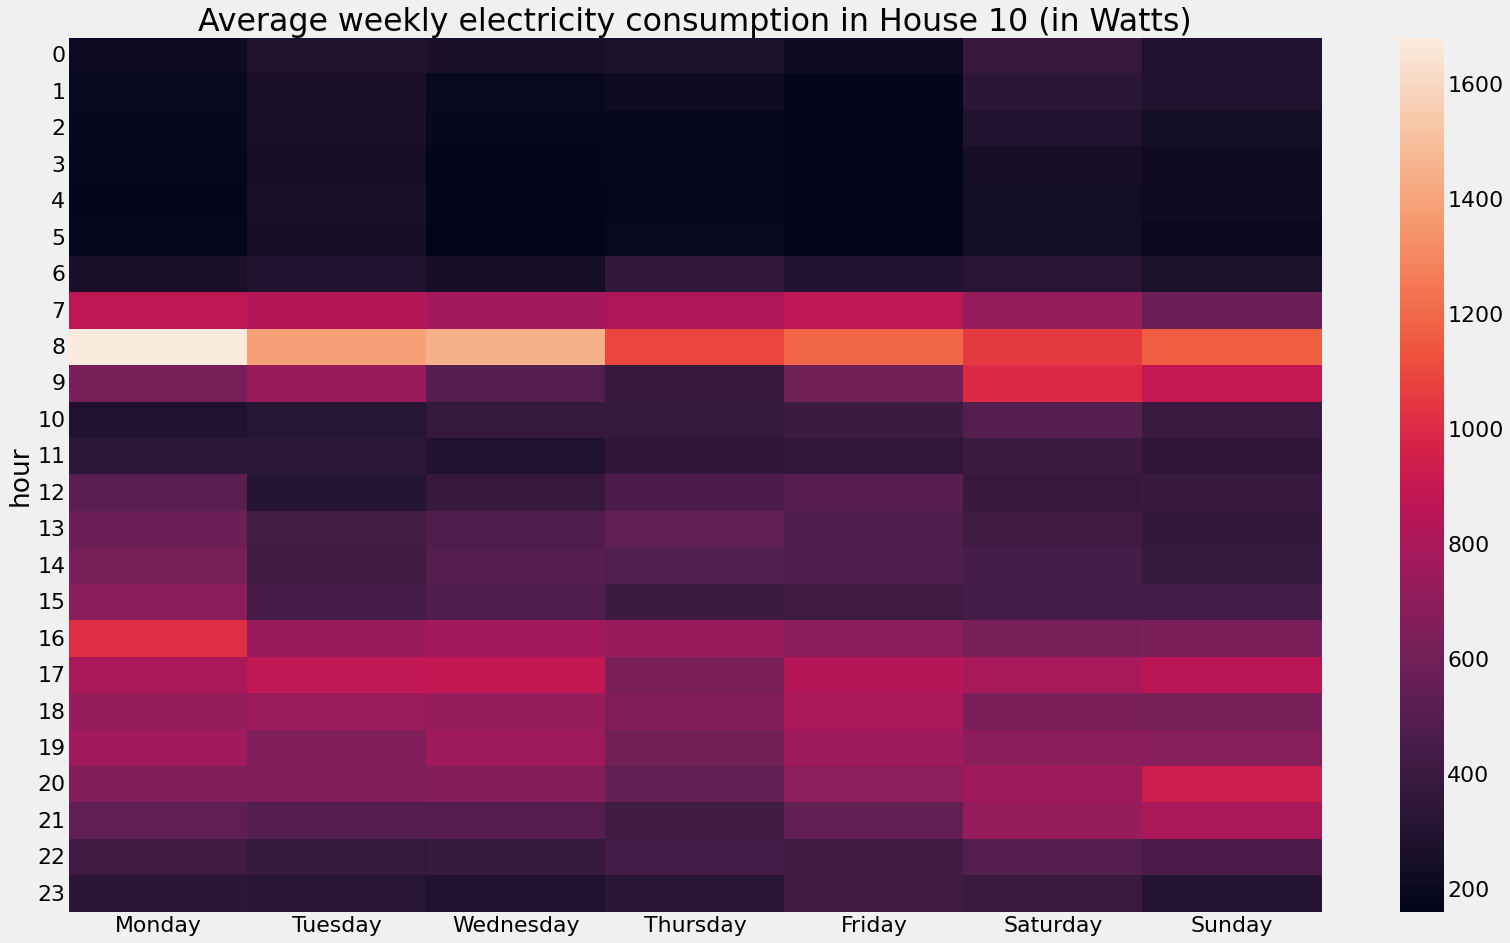

In [17]:
g=sns.heatmap(avg_pivot)

locs, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.title("Average weekly electricity consumption in House 10 (in Watts)")

<AxesSubplot:title={'center':'Electricity consumption of 4 sampled houses'}, xlabel='Time', ylabel='Load (in Watts)'>

<Figure size 1800x1080 with 0 Axes>

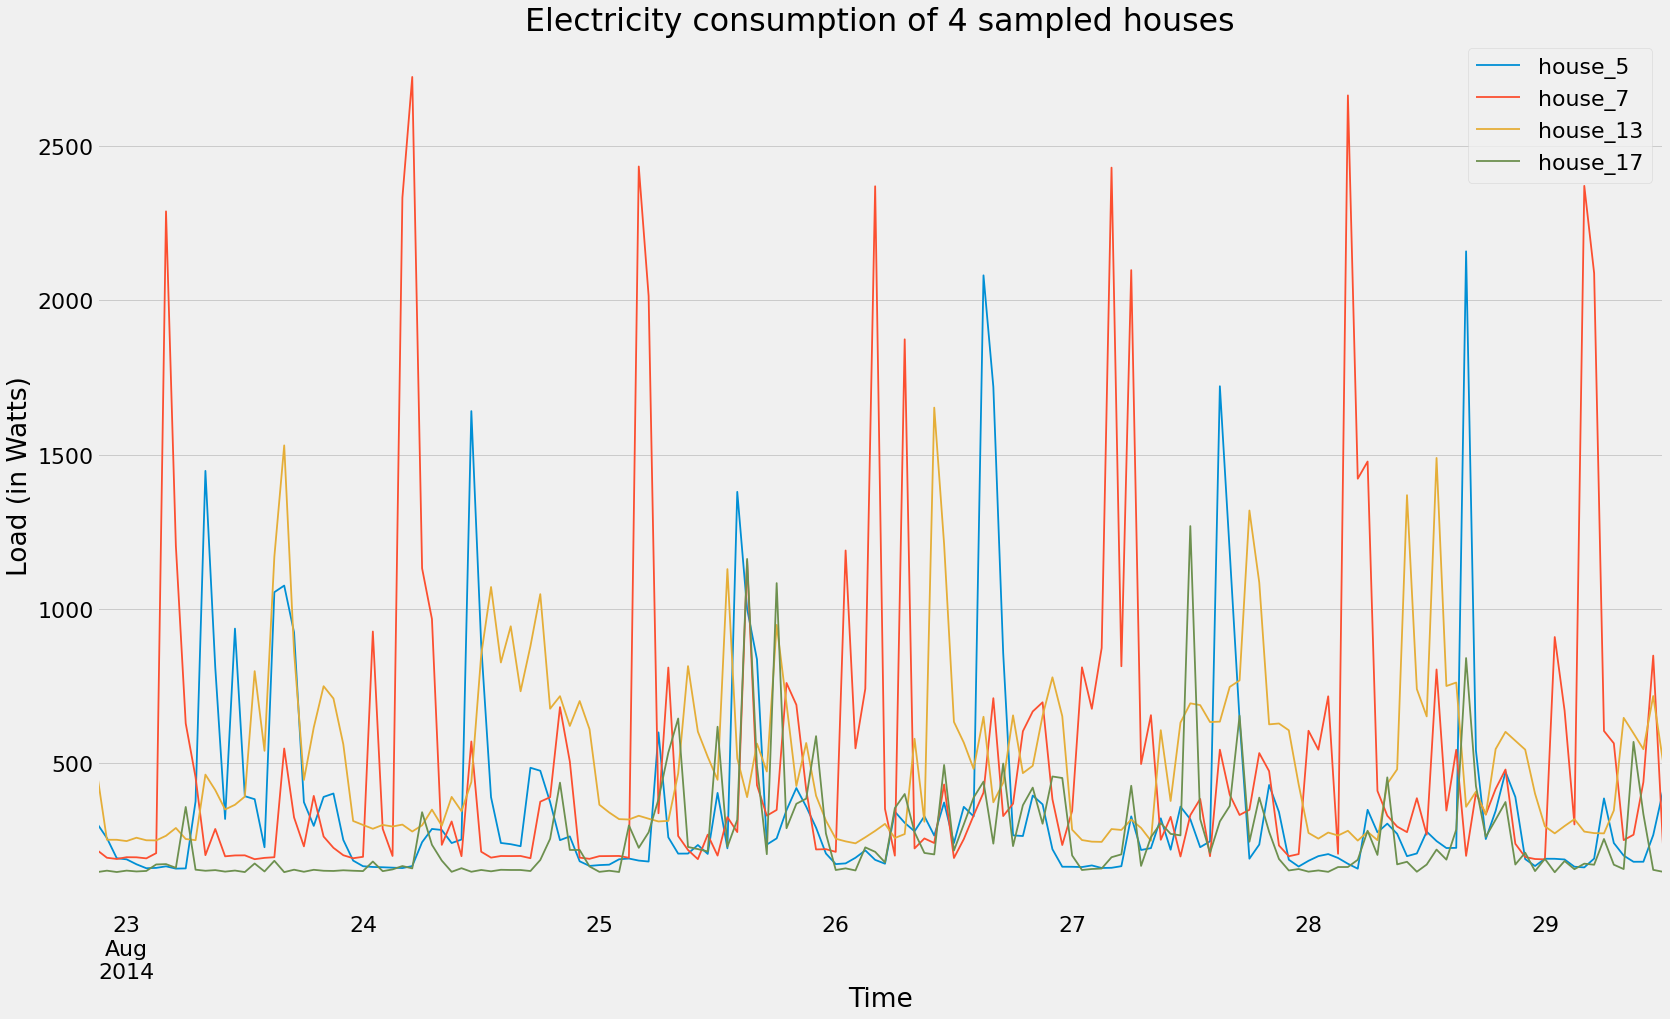

In [70]:
plt.figure()
plt.rcParams.update({'font.size': 22})
refit1.iloc[1220:1380,[5,7,13,17,]].plot(subplots=False, title="Electricity consumption of 4 sampled houses", lw=1.8, 
ylabel="Load (in Watts)", sharey=False)


array([[<AxesSubplot:title={'center':'house_0'}>,
        <AxesSubplot:title={'center':'house_1'}>,
        <AxesSubplot:title={'center':'house_2'}>,
        <AxesSubplot:title={'center':'house_3'}>],
       [<AxesSubplot:title={'center':'house_4'}>,
        <AxesSubplot:title={'center':'house_5'}>,
        <AxesSubplot:title={'center':'house_6'}>,
        <AxesSubplot:title={'center':'house_7'}>],
       [<AxesSubplot:title={'center':'house_8'}>,
        <AxesSubplot:title={'center':'house_9'}>,
        <AxesSubplot:title={'center':'house_10'}>,
        <AxesSubplot:title={'center':'house_11'}>],
       [<AxesSubplot:title={'center':'house_12'}>,
        <AxesSubplot:title={'center':'house_13'}>,
        <AxesSubplot:title={'center':'house_14'}>,
        <AxesSubplot:title={'center':'house_15'}>],
       [<AxesSubplot:title={'center':'house_16'}>,
        <AxesSubplot:title={'center':'house_17'}>,
        <AxesSubplot:title={'center':'house_18'}>,
        <AxesSubplot:title={'center':

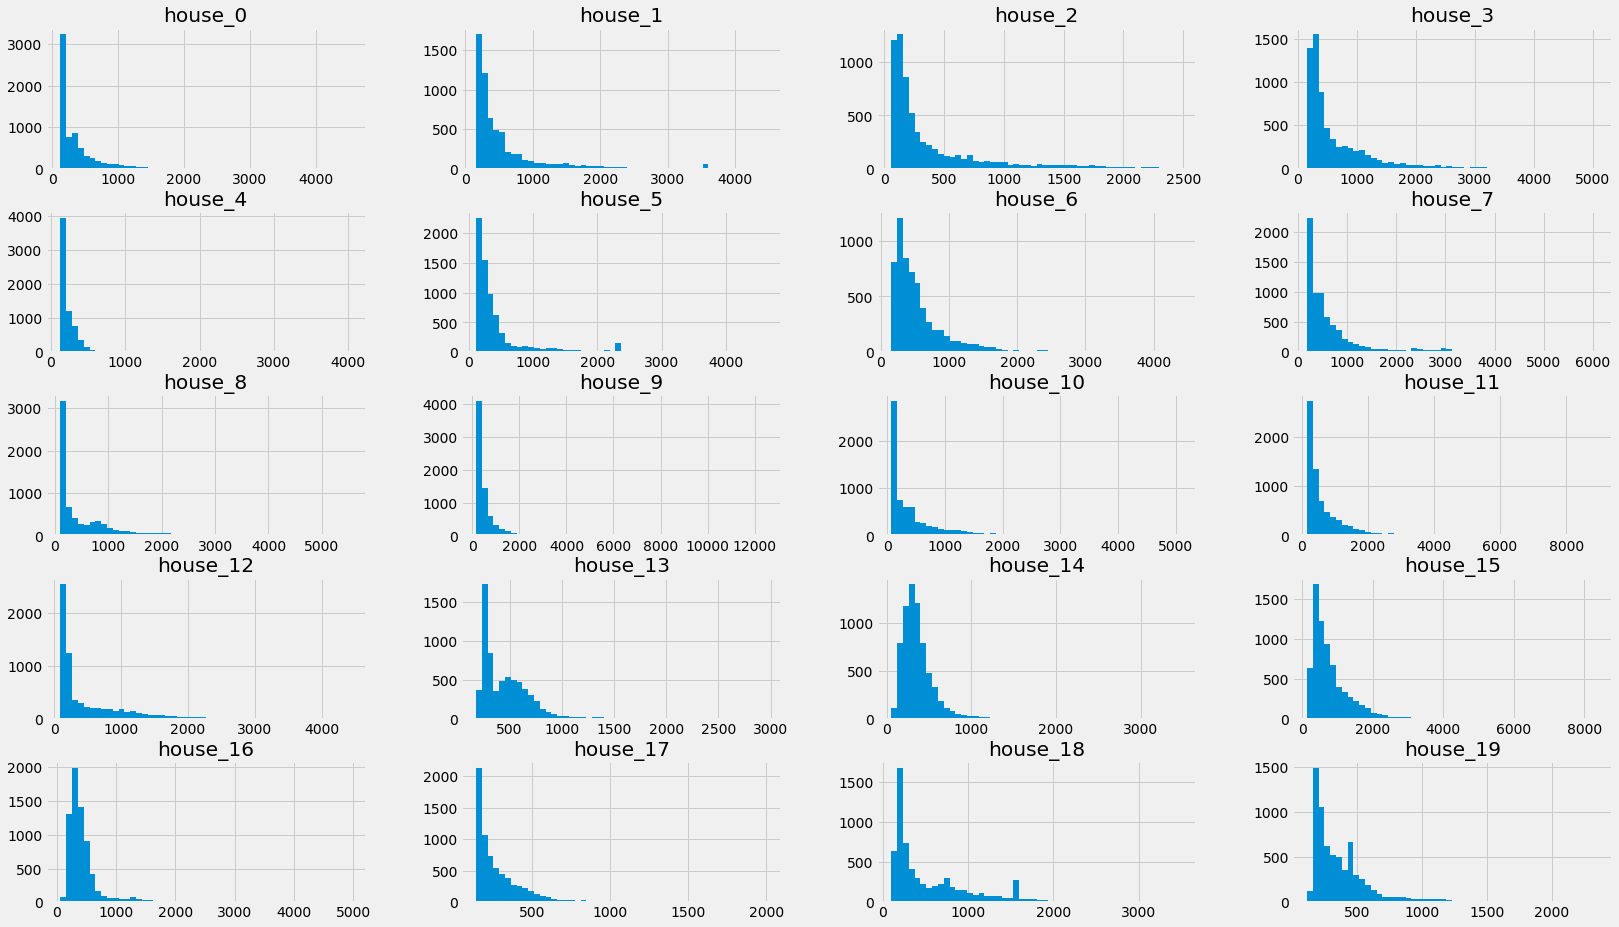

In [387]:
refit.hist(bins=50)

# First try running model without outliers

In [37]:
for home in refit:
    q_99 = refit[home].quantile(0.99)

    refit[home] = np.where(refit[home]>=q_99, q_99, refit[home])



In [7]:
def create_features(df):
    """
    Creates time series features from datetime index.
    """
    # df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['night']= np.where((df['hour']>=18)|(df['hour']<6),1,0)
    df['lag_hour'] = df['Aggregate'].shift(periods=1)
    df['lag_day'] = df['Aggregate'].shift(periods=24)
    df['lag_week'] = df['Aggregate'].shift(periods=168)


# Univariate Benchmark example

In [29]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [77]:
pred_train = {}
pred_test = {}

rmse_train={}
rmse_test = {}

In [86]:
def run_model(home: pd.Series, train_size, timesteps= 1, epochs=50, batch_size= 64):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

    #Define the model
    model = Sequential()
    model.add(LSTM(256))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

    #Fit the data
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    


    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error

    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"simple_lstm_{home.name}"] = scaler.inverse_transform(
                                model.predict(X_train,verbose=0)).flatten()

    pred_test[f'simple_lstm_{home.name}'] = scaler.inverse_transform(model.predict(X_test)).flatten()

    # # plot history
    # plt.plot(history.history['loss'], label='train')
    # plt.plot(history.history['val_loss'], label='test')
    # plt.legend()
    # plt.show()

    # #plot the predictions
    # plt.plot(pred_test[f'true_{home}'])
    # plt.plot(pred_test[f'simple_lstm_{home}'])
    # plt.show()


    rmse_test[f'single_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    rmse_train[f'single_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'single_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'single_{home.name}']}")




    


    

In [87]:
for home in refit:
    run_model(refit[home], train_size=0.8, epochs=50, batch_size=24)

(5539, 1, 1)
231/231 [==============================] - 4s 7ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0262 - val_mse: 0.0262
The RMSE in the train set is: 307.6288026977762
The RMSE in the test set is: 306.47708682349696
(4883, 1, 1)
204/204 [==============================] - 4s 8ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0176 - val_mse: 0.0176
The RMSE in the train set is: 442.91871510926234
The RMSE in the test set is: 454.5030803203081
(5309, 1, 1)
222/222 [==============================] - 3s 7ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0260 - val_mse: 0.0260
The RMSE in the train set is: 276.5125554896094
The RMSE in the test set is: 339.6858534709247
(5488, 1, 1)
229/229 [==============================] - 4s 8ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0323 - val_mse: 0.0323
The RMSE in the train set is: 506.1766373193735
The RMSE in the test set is: 543.6521850815329
(5347, 1, 1)
223/223 [==============================] - 5s 8ms/step - loss: 0.0183

KeyboardInterrupt: 

# Hyperparameter Tuning

In [88]:
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasRegressor
# Function to create model, required for KerasRegresson
def create_model():
	# create model
	model = Sequential()
	model.add(LSTM(256))
	model.add(Dense(1))
	model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

	return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


In [89]:
timesteps= 1

In [94]:
home= refit['house_0']
home= home.dropna()


# train, test split
# split into train and test sets
values = home.values
values= values.reshape(len(values),1)
train, test = train_test_split(values, train_size=0.9, shuffle=False)

# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)


# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [93]:
# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

In [103]:
# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_nodes = [100]
	n_epochs = [50]
	n_batch = [1, 150]
	n_diff = [12]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

In [104]:
# model configs
cfg_list = model_configs()

Total configs: 2


In [105]:
cfg_list

[[12, 100, 50, 1, 12], [12, 100, 50, 150, 12]]

In [ ]:
# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare data


	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
	model.add(Dense(n_nodes))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

In [106]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return np.sqrt(mean_squared_error(actual, predicted))
 
# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]
 
# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
	n_features = 1
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model
 
# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
	x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error
 
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = np.mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_nodes = [100]
	n_epochs = [50]
	n_batch = [1, 150]
	n_diff = [12]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs
 


In [266]:
#install the package
import keras_tuner as kt
import keras.optimizers


In [277]:
def build_model(hp):
  model = Sequential()
  model.add(LSTM(hp.Choice('units',[24,64,128,256,512])))
  model.add(Dense(1, activation='relu'))
  model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-1, 1e-2, 1e-3])), metrics=['mean_squared_error'])

  
  return model

In [278]:
tuner = kt.RandomSearch(
    build_model,
    objective= 'val_mean_squared_error',
    max_trials=20)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [279]:
home= refit['house_0']
home= home.dropna()


# train, test split
# split into train and test sets
values = home.values
values= values.reshape(len(values),1)
train, test = train_test_split(values, train_size=0.9, shuffle=False)

# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)


# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [280]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

INFO:tensorflow:Oracle triggered exit


In [281]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.1
Score: 0.026566781103610992
Trial summary
Hyperparameters:
units: 64
Score: 0.05213840678334236
Trial summary
Hyperparameters:
units: 512
Score: 0.05213840678334236
Trial summary
Hyperparameters:
units: 256
Score: 0.05213840678334236
Trial summary
Hyperparameters:
units: 24
Score: 0.05213840678334236


{'name': 'sequential',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 128,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,
    'dropout': 0.0,
    'recurrent_dropout': 0.0,
    'implementation': 2}},
  {'class_name': '

# Naive Multivariate LSTM approach

In [109]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [110]:
values= refit.values
values = values.astype('float32')

In [111]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [112]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 40 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   home_1(t-1)   6925 non-null   float32
 1   home_2(t-1)   6105 non-null   float32
 2   home_3(t-1)   6637 non-null   float32
 3   home_4(t-1)   6861 non-null   float32
 4   home_5(t-1)   6685 non-null   float32
 5   home_6(t-1)   6987 non-null   float32
 6   home_7(t-1)   6150 non-null   float32
 7   home_8(t-1)   6956 non-null   float32
 8   home_9(t-1)   6980 non-null   float32
 9   home_10(t-1)  6891 non-null   float32
 10  home_11(t-1)  6835 non-null   float32
 11  home_12(t-1)  6903 non-null   float32
 12  home_13(t-1)  6925 non-null   float32
 13  home_14(t-1)  6787 non-null   float32
 14  home_15(t-1)  6933 non-null   float32
 15  home_16(t-1)  6991 non-null   float32
 16  home_17(t-1)  6863 non-null   float32
 17  home_18(t-1)  6986 non-null   float32
 18  home_19(t-1)  6607 non-null 

In [117]:
#Testing house1 
house_1= reframed.iloc[:,:21]
house_2=reframed.iloc[:,np.r_[0:19,21]]
house_3= reframed.iloc[:,np.r_[0:19,22]]
house_4= reframed.iloc[:,np.r_[0:19,23]]
house_5= reframed.iloc[:,np.r_[0:19,24]]
house_6= reframed.iloc[:,np.r_[0:19,25]]
house_7= reframed.iloc[:,np.r_[0:19,26]]
house_8= reframed.iloc[:,np.r_[0:19,27]]
house_9= reframed.iloc[:,np.r_[0:19,28]]
house_10= reframed.iloc[:,np.r_[0:19,29]]
house_11= reframed.iloc[:,np.r_[0:19,30]]
house_12= reframed.iloc[:,np.r_[0:19,31]]
house_13= reframed.iloc[:,np.r_[0:19,32]]
house_14= reframed.iloc[:,np.r_[0:19,33]]
house_15= reframed.iloc[:,np.r_[0:19,34]]
house_16= reframed.iloc[:,np.r_[0:19,35]]
house_17= reframed.iloc[:,np.r_[0:19,36]]
house_18= reframed.iloc[:,np.r_[0:19,37]]
house_19= reframed.iloc[:,np.r_[0:19,38]]
house_20= reframed.iloc[:,np.r_[0:19,39]]



In [124]:
houses = [house_1, house_2, house_3, house_4, house_5, house_6, house_7, house_8, house_9, house_10, house_11, house_12, house_13, house_14, house_15,
        house_16, house_17, house_18, house_19, house_20]

In [134]:
multi_pred_train={}
multi_pred_test={}

multi_rmse_train={}
multi_rmse_test={}

In [147]:
def train_model(df, train_size = 0.8, neurons = 256, epochs=50, batch_size=24, plot=True):
    '''function that takes a cleaned version of the modified dataframe, transforms the data into 
    [Samples, timesteps, features] , splits it into training and testing data, and trains a model on the 
    fitted data to then predict the test data and calculate the root mean squared_error'''    
    #Drop nan values
    df= df.dropna()
    # train, test split
    # split into train and test sets
    values = df.values
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')


    # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    if plot==True:

        # plot history
        plt.plot(history2.history['loss'], label='train')
        #plt.plot(history2.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    else:
        pass

    #Predict model
    yhat= model.predict(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
    inv_yhat = np.concatenate((X_test, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat=inv_yhat[:,-1]
    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    inv_y= np.concatenate((X_test, y_test), axis=1)
    inv_y = scaler.inverse_transform(inv_y)

    inv_y = inv_y[:,-1]

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error
   
    multi_pred_train={}
    multi_pred_test={}

    multi_pred_test['true'] = inv_y
    multi_pred_test['multi'] = inv_yhat

    multi_rmse_test={}
    multi_rmse_test["multi"]  = rmse(multi_pred_test["true"],  multi_pred_test["multi"])

    print(multi_rmse_test)

    multi_pred_test = pd.DataFrame(multi_pred_test)

    if plot==True:
        multi_pred_test.plot(lw=1.5)
    else:
        pass

(3864, 1, 20) (3864,) (966, 1, 20) (966,)
Epoch 1/10
161/161 - 2s - loss: 0.0275 - 2s/epoch - 15ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0254 - 832ms/epoch - 5ms/step
Epoch 3/10
161/161 - 1s - loss: 0.0251 - 664ms/epoch - 4ms/step
Epoch 4/10
161/161 - 1s - loss: 0.0250 - 522ms/epoch - 3ms/step
Epoch 5/10
161/161 - 0s - loss: 0.0249 - 498ms/epoch - 3ms/step
Epoch 6/10
161/161 - 0s - loss: 0.0248 - 480ms/epoch - 3ms/step
Epoch 7/10
161/161 - 0s - loss: 0.0247 - 449ms/epoch - 3ms/step
Epoch 8/10
161/161 - 0s - loss: 0.0247 - 442ms/epoch - 3ms/step
Epoch 9/10
161/161 - 0s - loss: 0.0246 - 448ms/epoch - 3ms/step
Epoch 10/10
161/161 - 1s - loss: 0.0246 - 527ms/epoch - 3ms/step


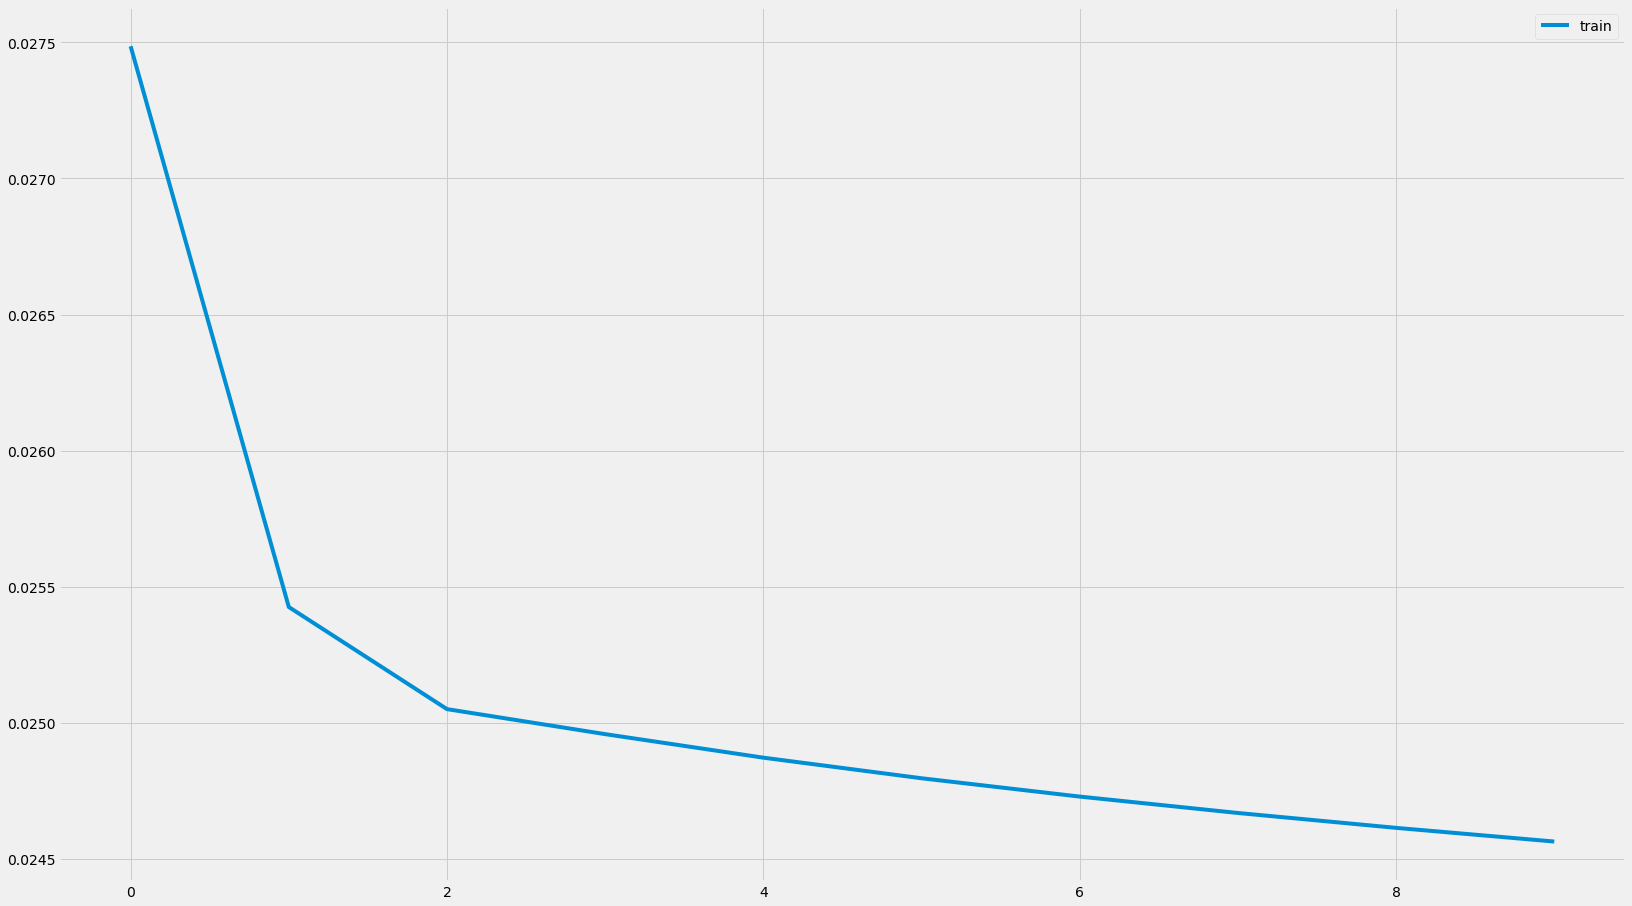

{'multi': 298.67844}
(3856, 1, 19) (3856,) (965, 1, 19) (965,)
Epoch 1/10
161/161 - 2s - loss: 0.0216 - 2s/epoch - 14ms/step
Epoch 2/10
161/161 - 0s - loss: 0.0197 - 484ms/epoch - 3ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0189 - 479ms/epoch - 3ms/step
Epoch 4/10
161/161 - 1s - loss: 0.0186 - 538ms/epoch - 3ms/step
Epoch 5/10
161/161 - 1s - loss: 0.0184 - 681ms/epoch - 4ms/step
Epoch 6/10
161/161 - 1s - loss: 0.0183 - 684ms/epoch - 4ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0182 - 546ms/epoch - 3ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0180 - 509ms/epoch - 3ms/step
Epoch 9/10
161/161 - 1s - loss: 0.0179 - 501ms/epoch - 3ms/step
Epoch 10/10
161/161 - 1s - loss: 0.0178 - 503ms/epoch - 3ms/step


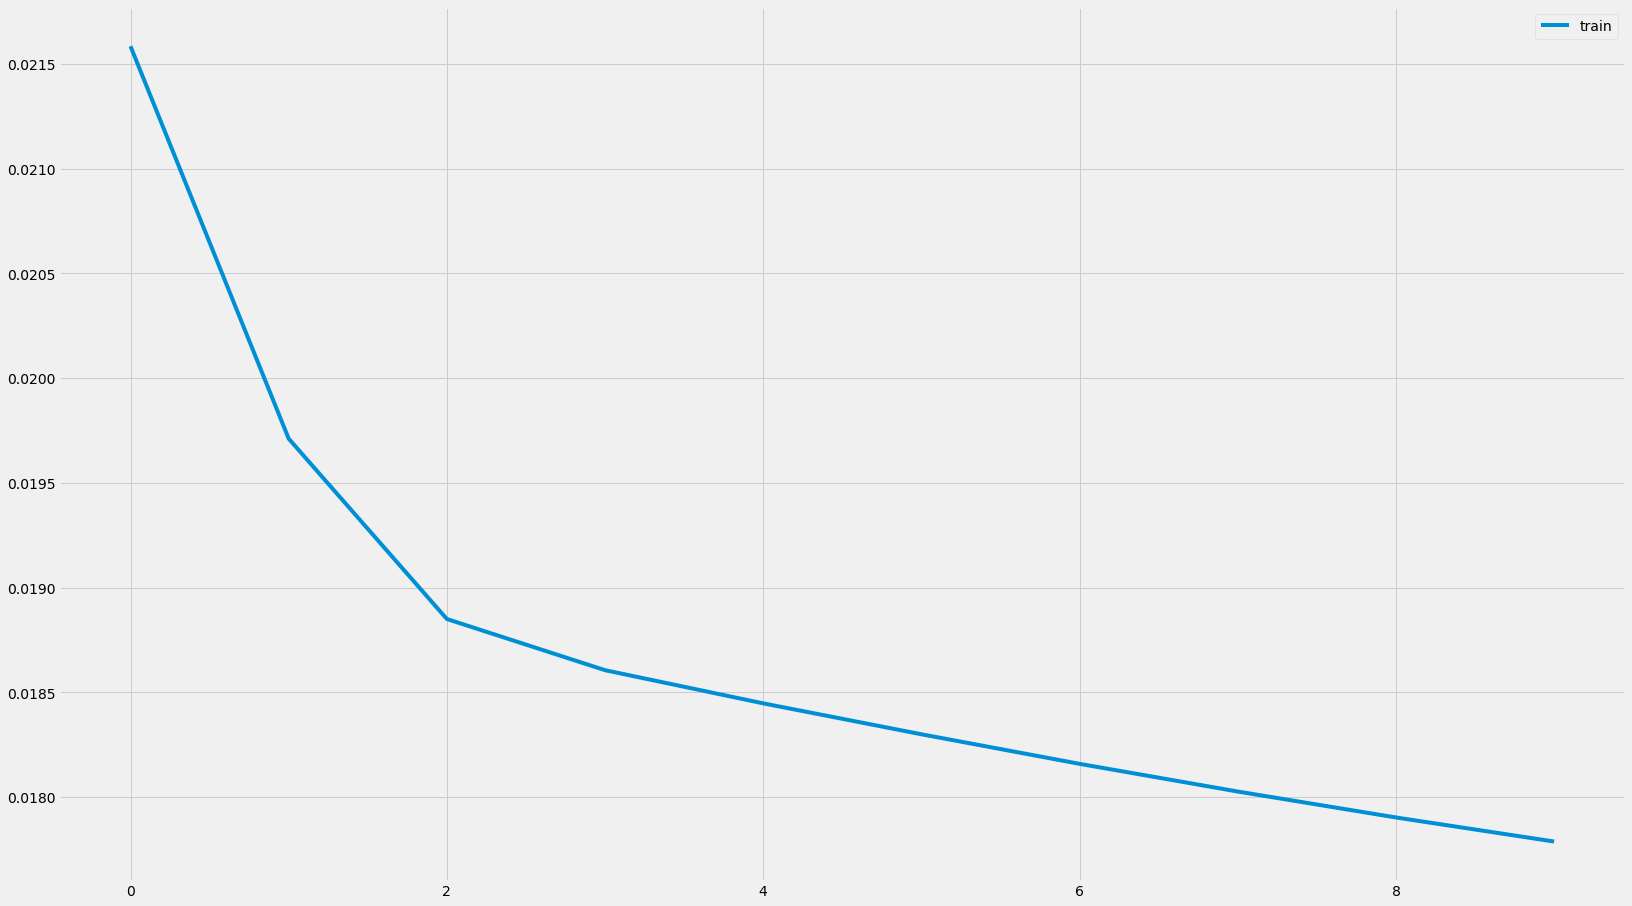

{'multi': 417.36224}
(3864, 1, 19) (3864,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 3s - loss: 0.0271 - 3s/epoch - 21ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0147 - 588ms/epoch - 4ms/step
Epoch 3/10
161/161 - 1s - loss: 0.0123 - 539ms/epoch - 3ms/step
Epoch 4/10
161/161 - 0s - loss: 0.0121 - 441ms/epoch - 3ms/step
Epoch 5/10
161/161 - 0s - loss: 0.0121 - 454ms/epoch - 3ms/step
Epoch 6/10
161/161 - 0s - loss: 0.0120 - 442ms/epoch - 3ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0120 - 602ms/epoch - 4ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0119 - 587ms/epoch - 4ms/step
Epoch 9/10
161/161 - 1s - loss: 0.0119 - 678ms/epoch - 4ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0118 - 426ms/epoch - 3ms/step


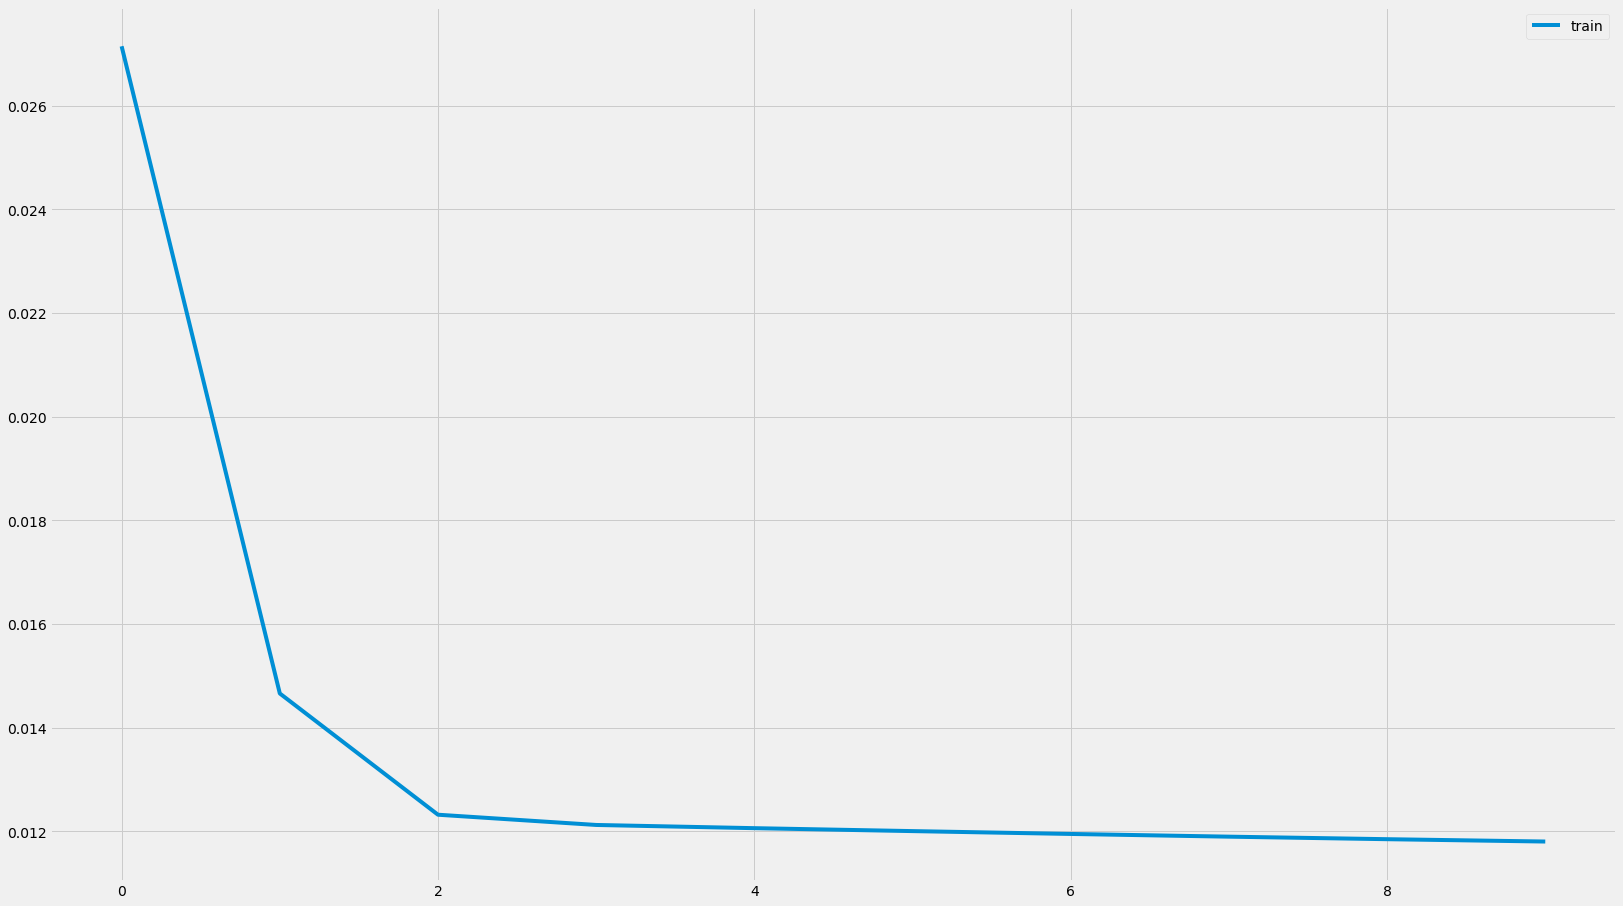

{'multi': 281.5101}
(3861, 1, 19) (3861,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 2s - loss: 0.0297 - 2s/epoch - 12ms/step
Epoch 2/10
161/161 - 0s - loss: 0.0277 - 461ms/epoch - 3ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0273 - 485ms/epoch - 3ms/step
Epoch 4/10
161/161 - 0s - loss: 0.0272 - 459ms/epoch - 3ms/step
Epoch 5/10
161/161 - 1s - loss: 0.0270 - 625ms/epoch - 4ms/step
Epoch 6/10
161/161 - 1s - loss: 0.0269 - 577ms/epoch - 4ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0267 - 857ms/epoch - 5ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0266 - 757ms/epoch - 5ms/step
Epoch 9/10
161/161 - 0s - loss: 0.0265 - 497ms/epoch - 3ms/step
Epoch 10/10
161/161 - 1s - loss: 0.0264 - 571ms/epoch - 4ms/step


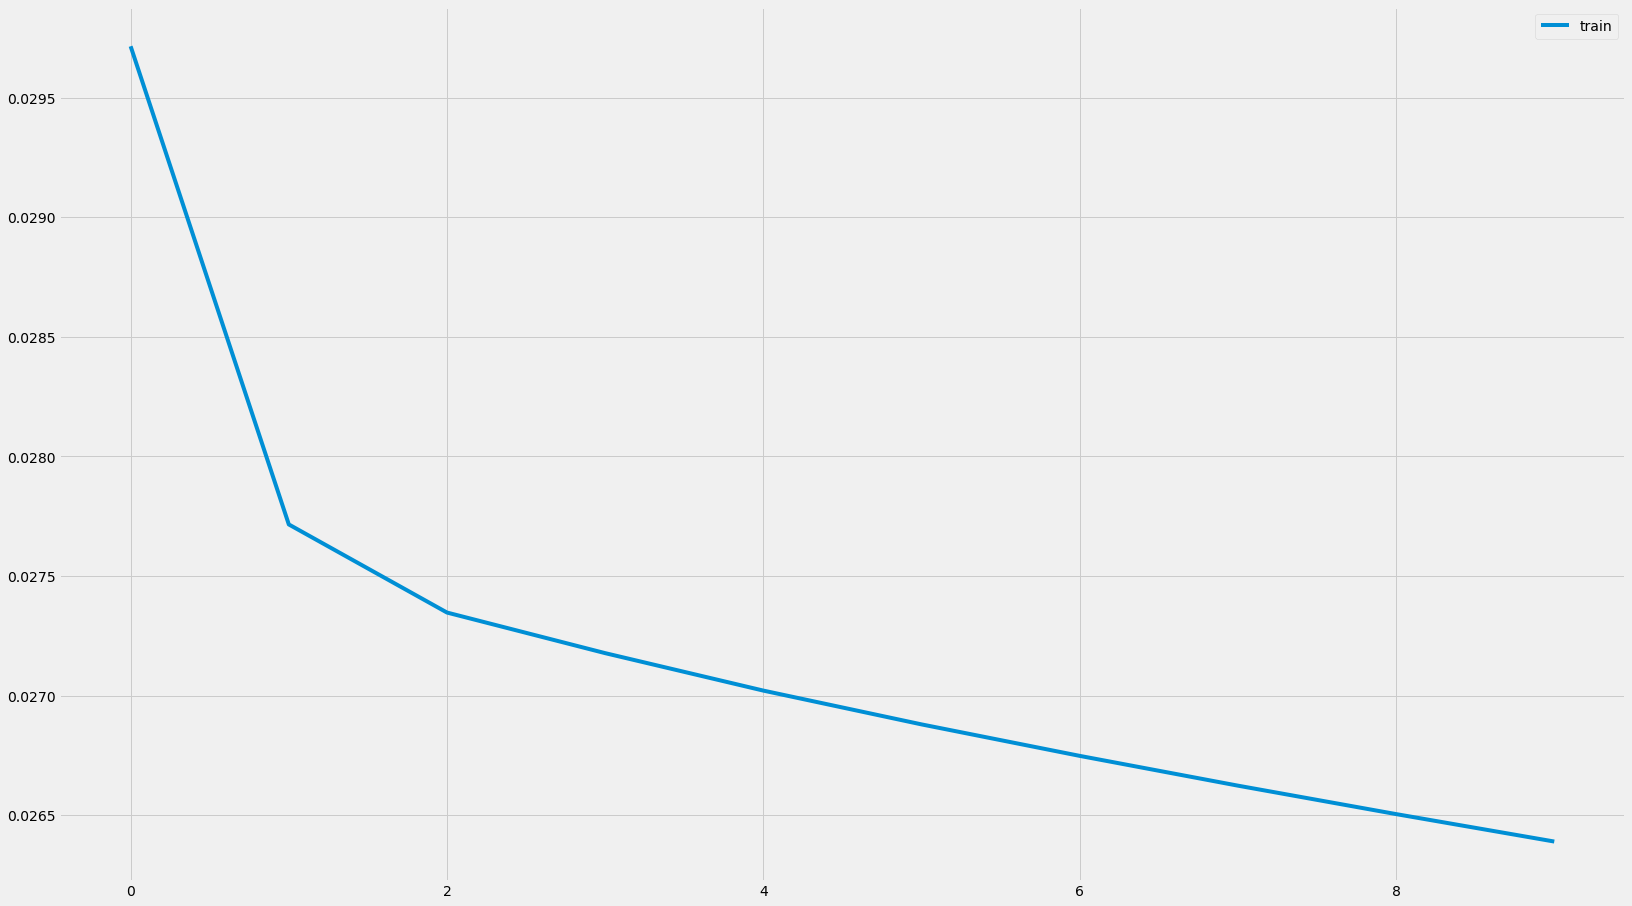

{'multi': 524.61676}
(3863, 1, 19) (3863,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 2s - loss: 0.0206 - 2s/epoch - 16ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0186 - 869ms/epoch - 5ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0185 - 498ms/epoch - 3ms/step
Epoch 4/10
161/161 - 1s - loss: 0.0184 - 761ms/epoch - 5ms/step
Epoch 5/10
161/161 - 1s - loss: 0.0183 - 671ms/epoch - 4ms/step
Epoch 6/10
161/161 - 0s - loss: 0.0182 - 483ms/epoch - 3ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0182 - 501ms/epoch - 3ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0181 - 731ms/epoch - 5ms/step
Epoch 9/10
161/161 - 1s - loss: 0.0181 - 514ms/epoch - 3ms/step
Epoch 10/10
161/161 - 1s - loss: 0.0180 - 514ms/epoch - 3ms/step


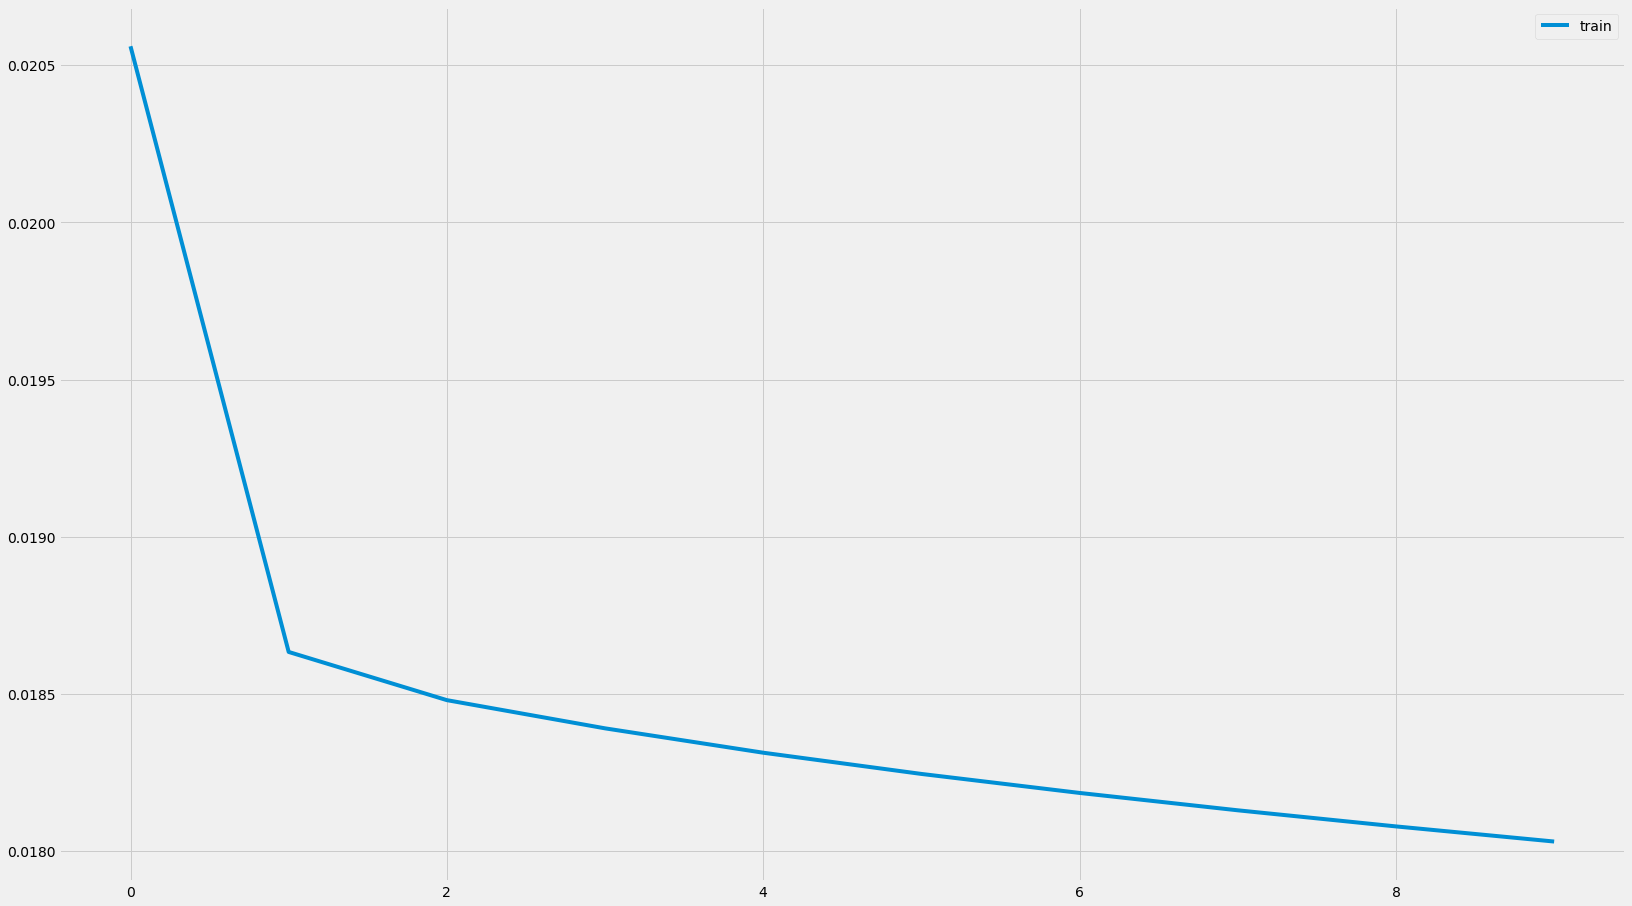

{'multi': 121.60558}
(3864, 1, 19) (3864,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 2s - loss: 0.0340 - 2s/epoch - 12ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0352 - 648ms/epoch - 4ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0332 - 464ms/epoch - 3ms/step
Epoch 4/10
161/161 - 0s - loss: 0.0322 - 450ms/epoch - 3ms/step
Epoch 5/10
161/161 - 0s - loss: 0.0316 - 445ms/epoch - 3ms/step
Epoch 6/10
161/161 - 0s - loss: 0.0311 - 458ms/epoch - 3ms/step
Epoch 7/10
161/161 - 0s - loss: 0.0307 - 446ms/epoch - 3ms/step
Epoch 8/10
161/161 - 0s - loss: 0.0304 - 456ms/epoch - 3ms/step
Epoch 9/10
161/161 - 0s - loss: 0.0301 - 438ms/epoch - 3ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0299 - 457ms/epoch - 3ms/step


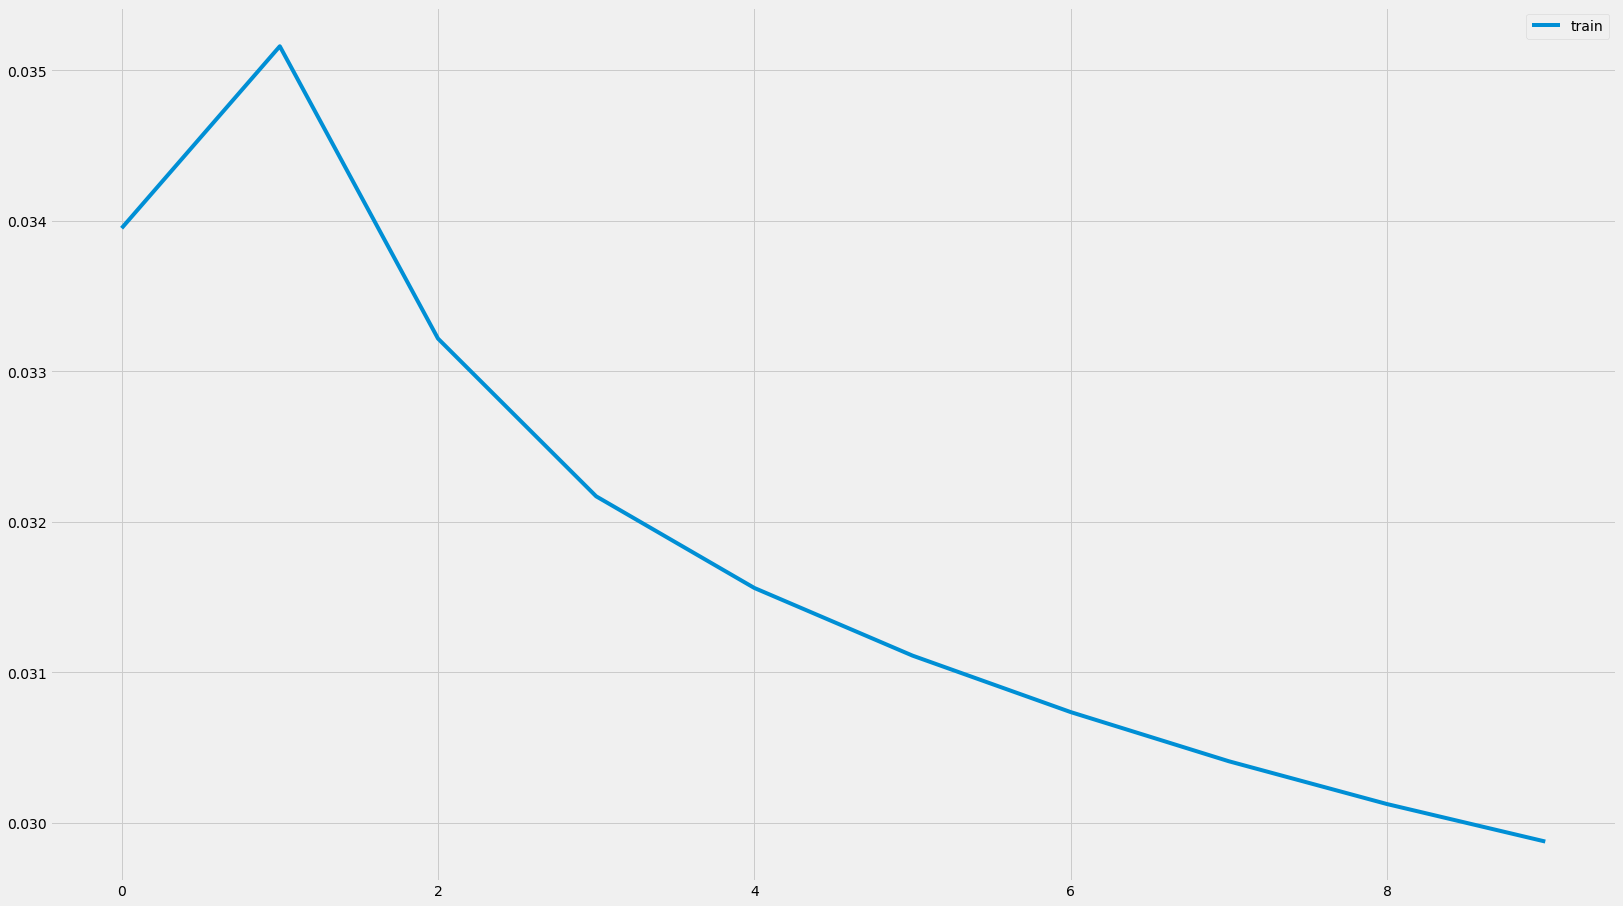

{'multi': 509.5409}
(3861, 1, 19) (3861,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 3s - loss: 0.0306 - 3s/epoch - 19ms/step
Epoch 2/10
161/161 - 0s - loss: 0.0276 - 493ms/epoch - 3ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0273 - 484ms/epoch - 3ms/step
Epoch 4/10
161/161 - 1s - loss: 0.0272 - 559ms/epoch - 3ms/step
Epoch 5/10
161/161 - 1s - loss: 0.0271 - 510ms/epoch - 3ms/step
Epoch 6/10
161/161 - 1s - loss: 0.0271 - 514ms/epoch - 3ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0270 - 560ms/epoch - 3ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0269 - 522ms/epoch - 3ms/step
Epoch 9/10
161/161 - 0s - loss: 0.0269 - 491ms/epoch - 3ms/step
Epoch 10/10
161/161 - 1s - loss: 0.0268 - 541ms/epoch - 3ms/step


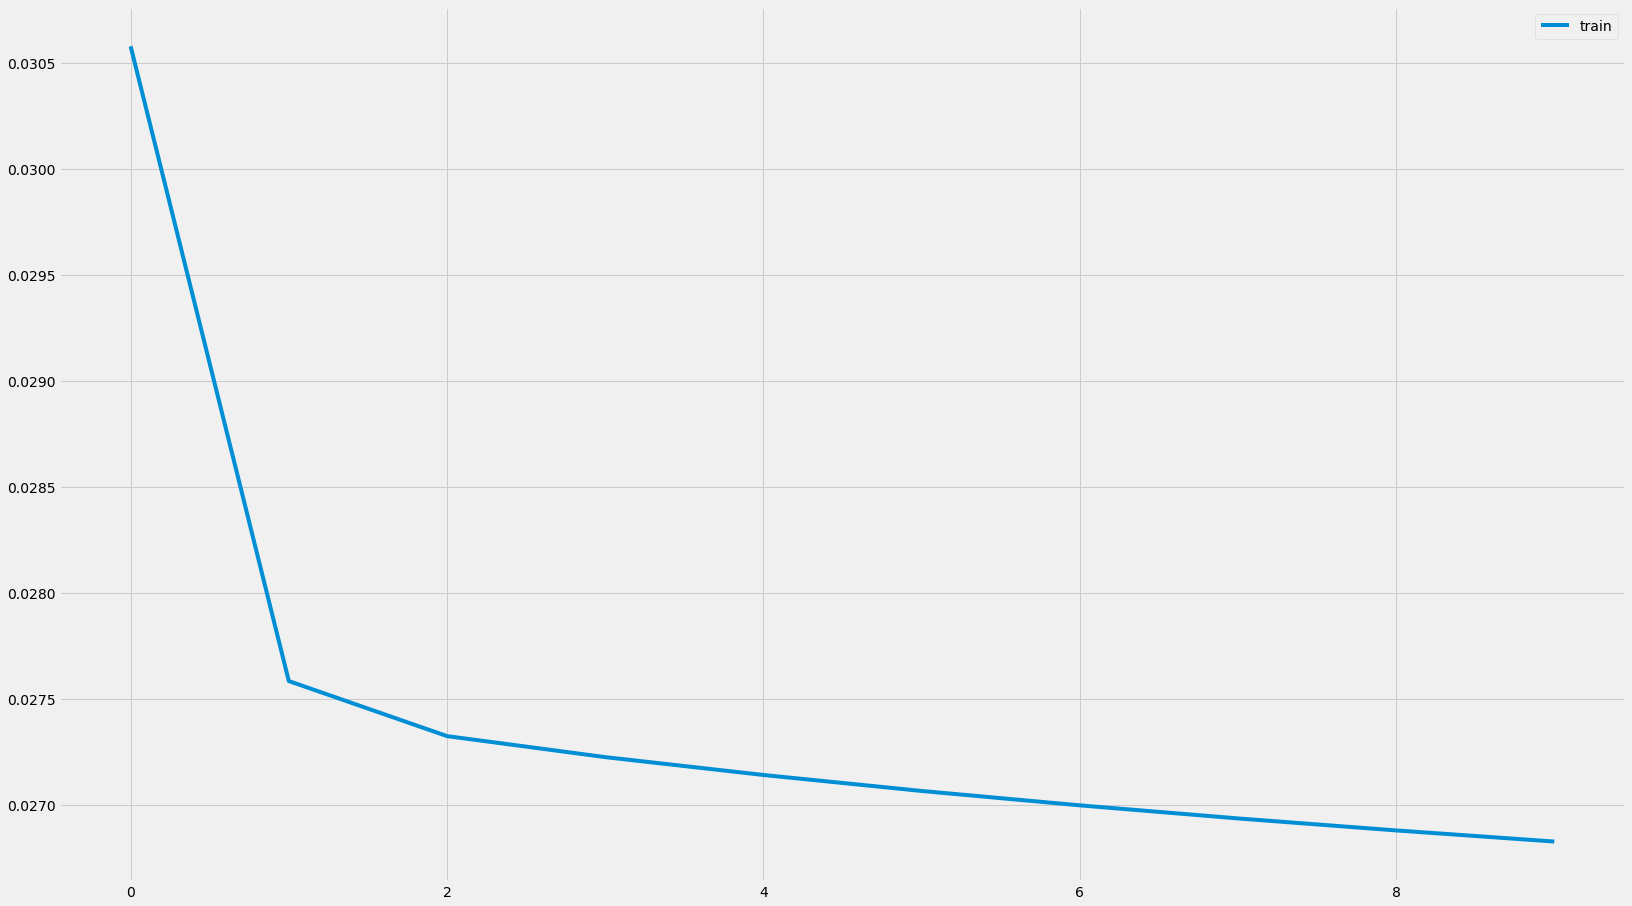

{'multi': 306.76645}
(3864, 1, 19) (3864,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 2s - loss: 0.0386 - 2s/epoch - 13ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0356 - 763ms/epoch - 5ms/step
Epoch 3/10
161/161 - 1s - loss: 0.0348 - 730ms/epoch - 5ms/step
Epoch 4/10
161/161 - 0s - loss: 0.0341 - 460ms/epoch - 3ms/step
Epoch 5/10
161/161 - 0s - loss: 0.0335 - 448ms/epoch - 3ms/step
Epoch 6/10
161/161 - 0s - loss: 0.0331 - 451ms/epoch - 3ms/step
Epoch 7/10
161/161 - 0s - loss: 0.0327 - 454ms/epoch - 3ms/step
Epoch 8/10
161/161 - 0s - loss: 0.0325 - 451ms/epoch - 3ms/step
Epoch 9/10
161/161 - 0s - loss: 0.0322 - 448ms/epoch - 3ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0320 - 457ms/epoch - 3ms/step


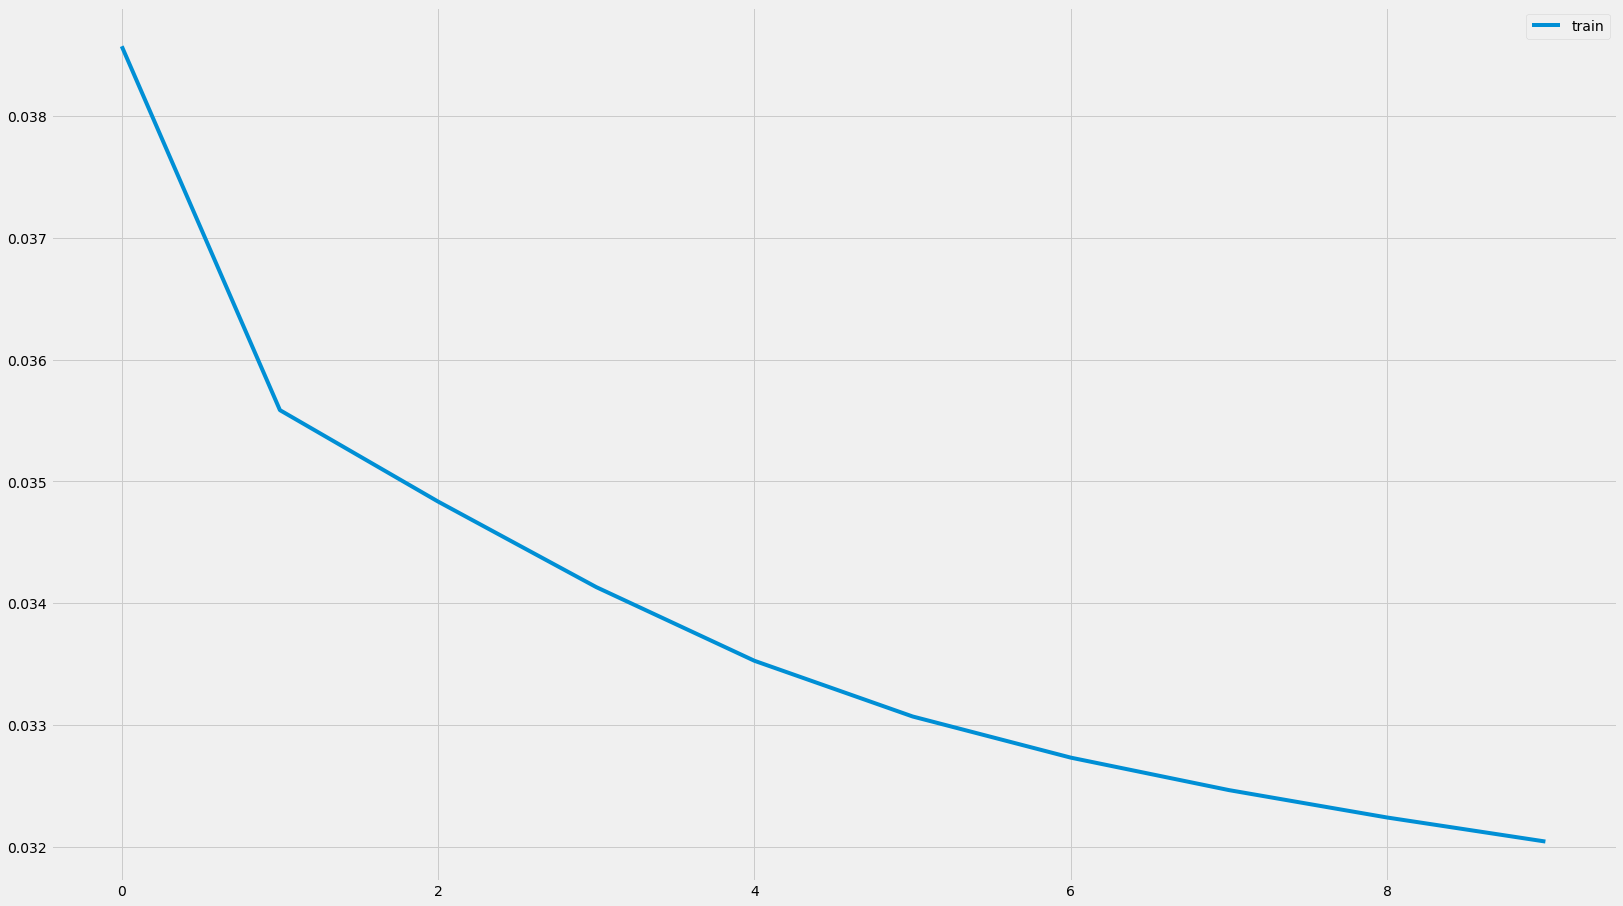

{'multi': 528.3603}
(3864, 1, 19) (3864,) (967, 1, 19) (967,)
Epoch 1/10
161/161 - 2s - loss: 0.0282 - 2s/epoch - 10ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0250 - 681ms/epoch - 4ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0242 - 444ms/epoch - 3ms/step
Epoch 4/10
161/161 - 0s - loss: 0.0240 - 448ms/epoch - 3ms/step
Epoch 5/10
161/161 - 0s - loss: 0.0238 - 466ms/epoch - 3ms/step
Epoch 6/10
161/161 - 0s - loss: 0.0237 - 445ms/epoch - 3ms/step
Epoch 7/10
161/161 - 0s - loss: 0.0235 - 457ms/epoch - 3ms/step
Epoch 8/10
161/161 - 0s - loss: 0.0234 - 450ms/epoch - 3ms/step
Epoch 9/10
161/161 - 0s - loss: 0.0233 - 462ms/epoch - 3ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0233 - 477ms/epoch - 3ms/step


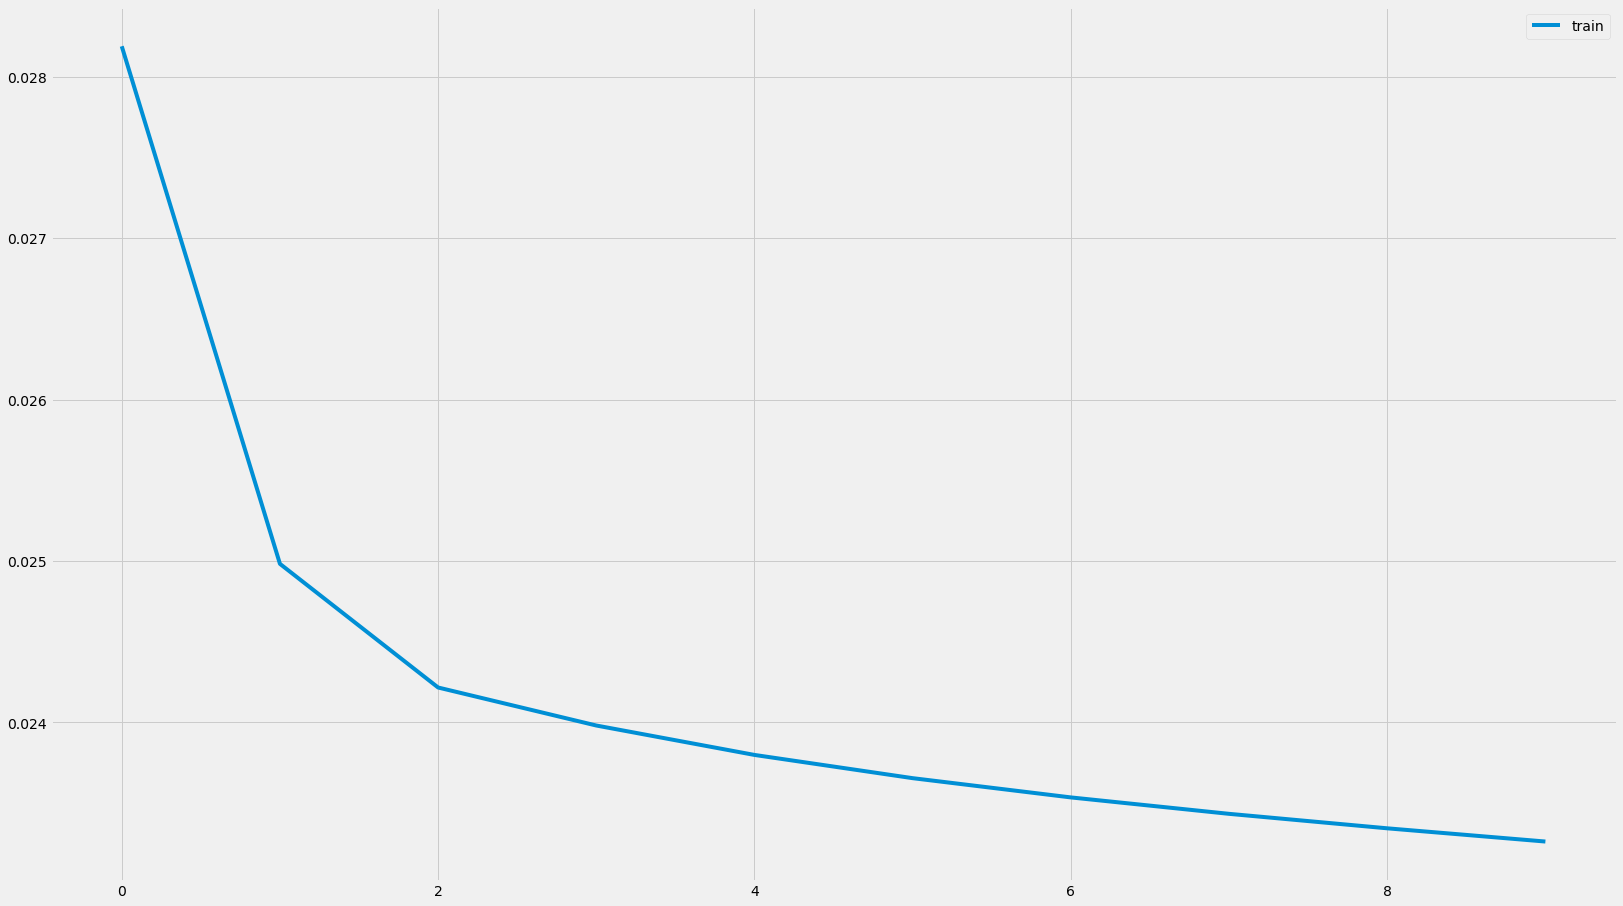

{'multi': 519.8678}
(3861, 1, 19) (3861,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 2s - loss: 0.0331 - 2s/epoch - 15ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0319 - 648ms/epoch - 4ms/step
Epoch 3/10
161/161 - 1s - loss: 0.0312 - 658ms/epoch - 4ms/step
Epoch 4/10
161/161 - 1s - loss: 0.0308 - 762ms/epoch - 5ms/step
Epoch 5/10
161/161 - 1s - loss: 0.0305 - 616ms/epoch - 4ms/step
Epoch 6/10
161/161 - 1s - loss: 0.0303 - 646ms/epoch - 4ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0301 - 559ms/epoch - 3ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0299 - 503ms/epoch - 3ms/step
Epoch 9/10
161/161 - 1s - loss: 0.0298 - 665ms/epoch - 4ms/step
Epoch 10/10
161/161 - 1s - loss: 0.0297 - 754ms/epoch - 5ms/step


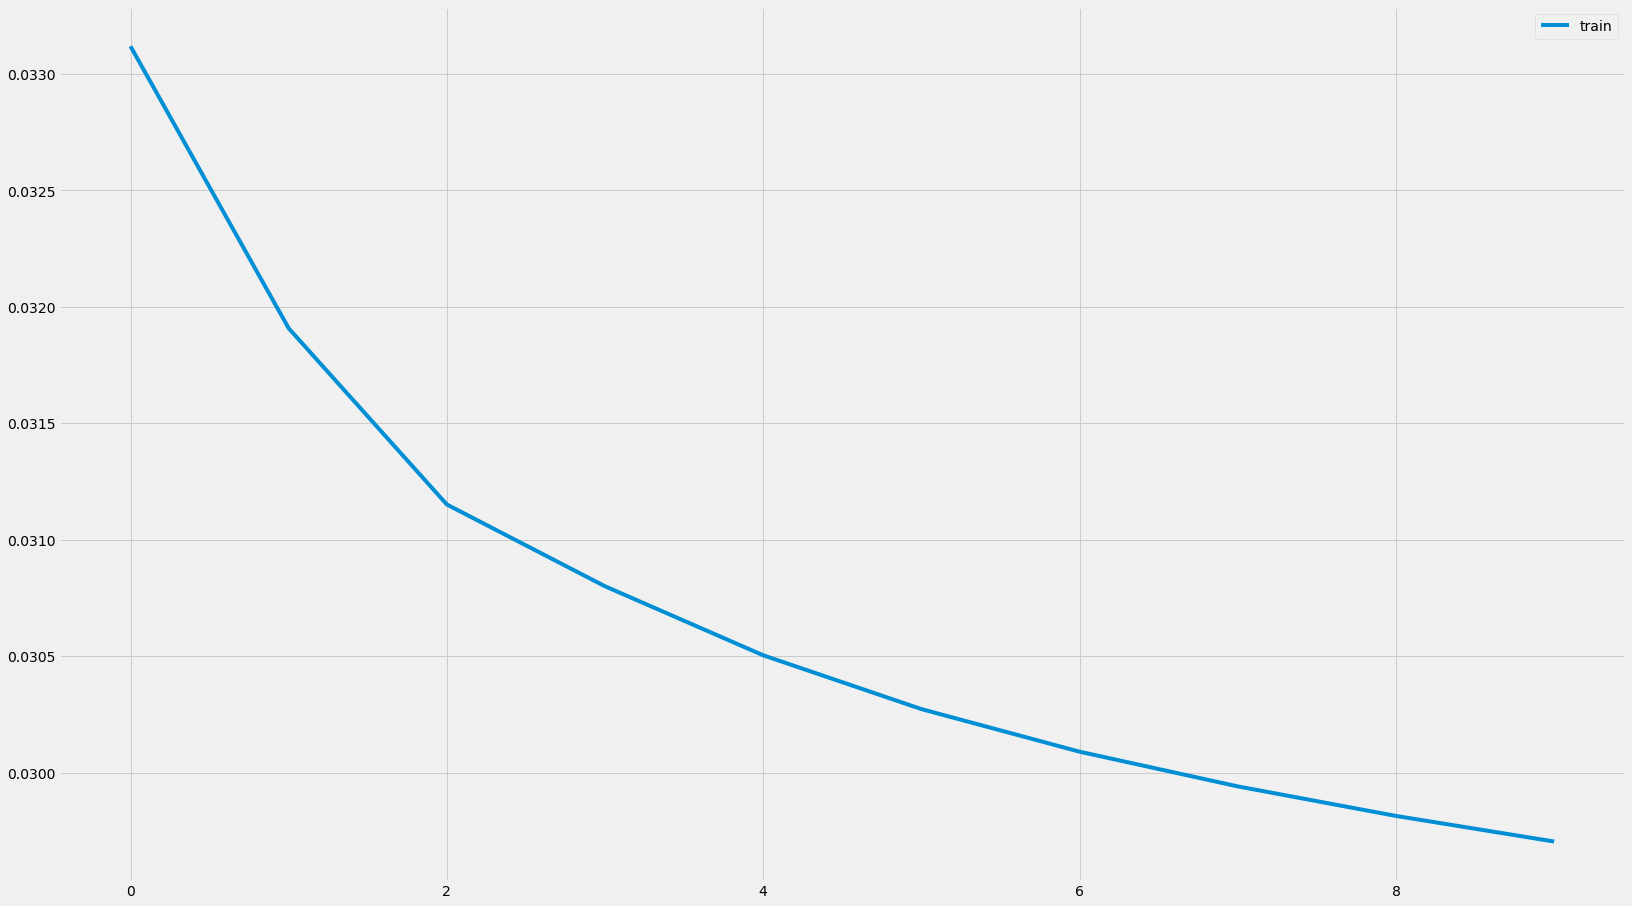

{'multi': 318.6923}
(3861, 1, 19) (3861,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 3s - loss: 0.0310 - 3s/epoch - 20ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0278 - 634ms/epoch - 4ms/step
Epoch 3/10
161/161 - 1s - loss: 0.0274 - 514ms/epoch - 3ms/step
Epoch 4/10
161/161 - 0s - loss: 0.0272 - 490ms/epoch - 3ms/step
Epoch 5/10
161/161 - 1s - loss: 0.0271 - 614ms/epoch - 4ms/step
Epoch 6/10
161/161 - 1s - loss: 0.0270 - 621ms/epoch - 4ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0268 - 536ms/epoch - 3ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0267 - 541ms/epoch - 3ms/step
Epoch 9/10
161/161 - 1s - loss: 0.0266 - 524ms/epoch - 3ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0265 - 494ms/epoch - 3ms/step


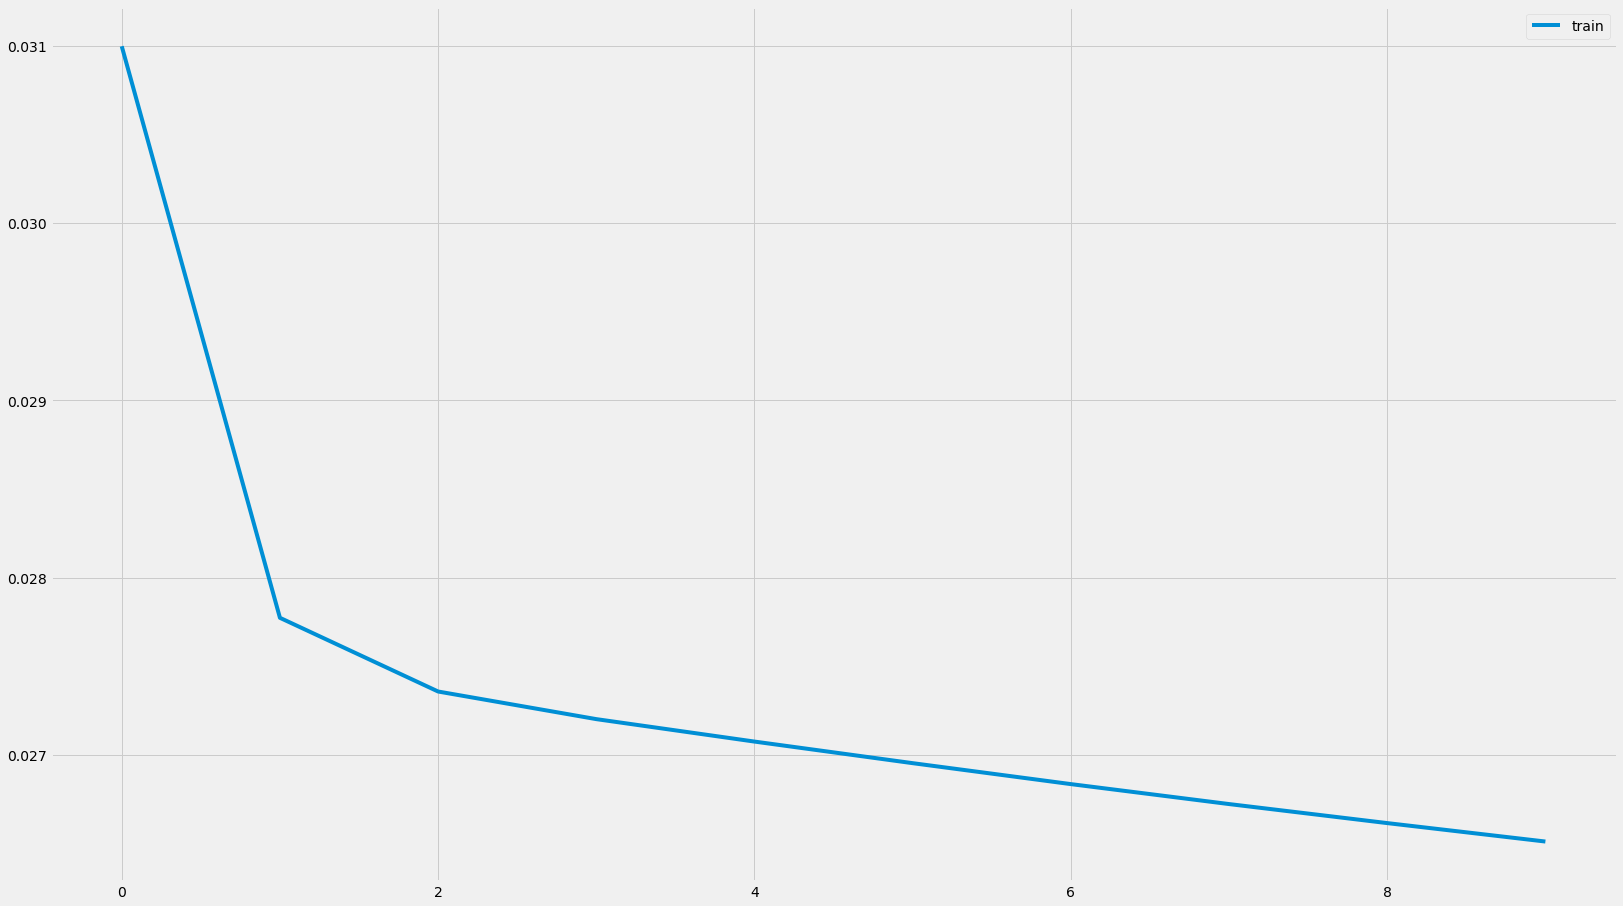

{'multi': 532.90625}
(3864, 1, 19) (3864,) (967, 1, 19) (967,)
Epoch 1/10
161/161 - 3s - loss: 0.0339 - 3s/epoch - 18ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0311 - 742ms/epoch - 5ms/step
Epoch 3/10
161/161 - 1s - loss: 0.0306 - 649ms/epoch - 4ms/step
Epoch 4/10
161/161 - 0s - loss: 0.0304 - 487ms/epoch - 3ms/step
Epoch 5/10
161/161 - 1s - loss: 0.0302 - 728ms/epoch - 5ms/step
Epoch 6/10
161/161 - 1s - loss: 0.0301 - 605ms/epoch - 4ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0300 - 647ms/epoch - 4ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0298 - 609ms/epoch - 4ms/step
Epoch 9/10
161/161 - 1s - loss: 0.0297 - 507ms/epoch - 3ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0297 - 488ms/epoch - 3ms/step


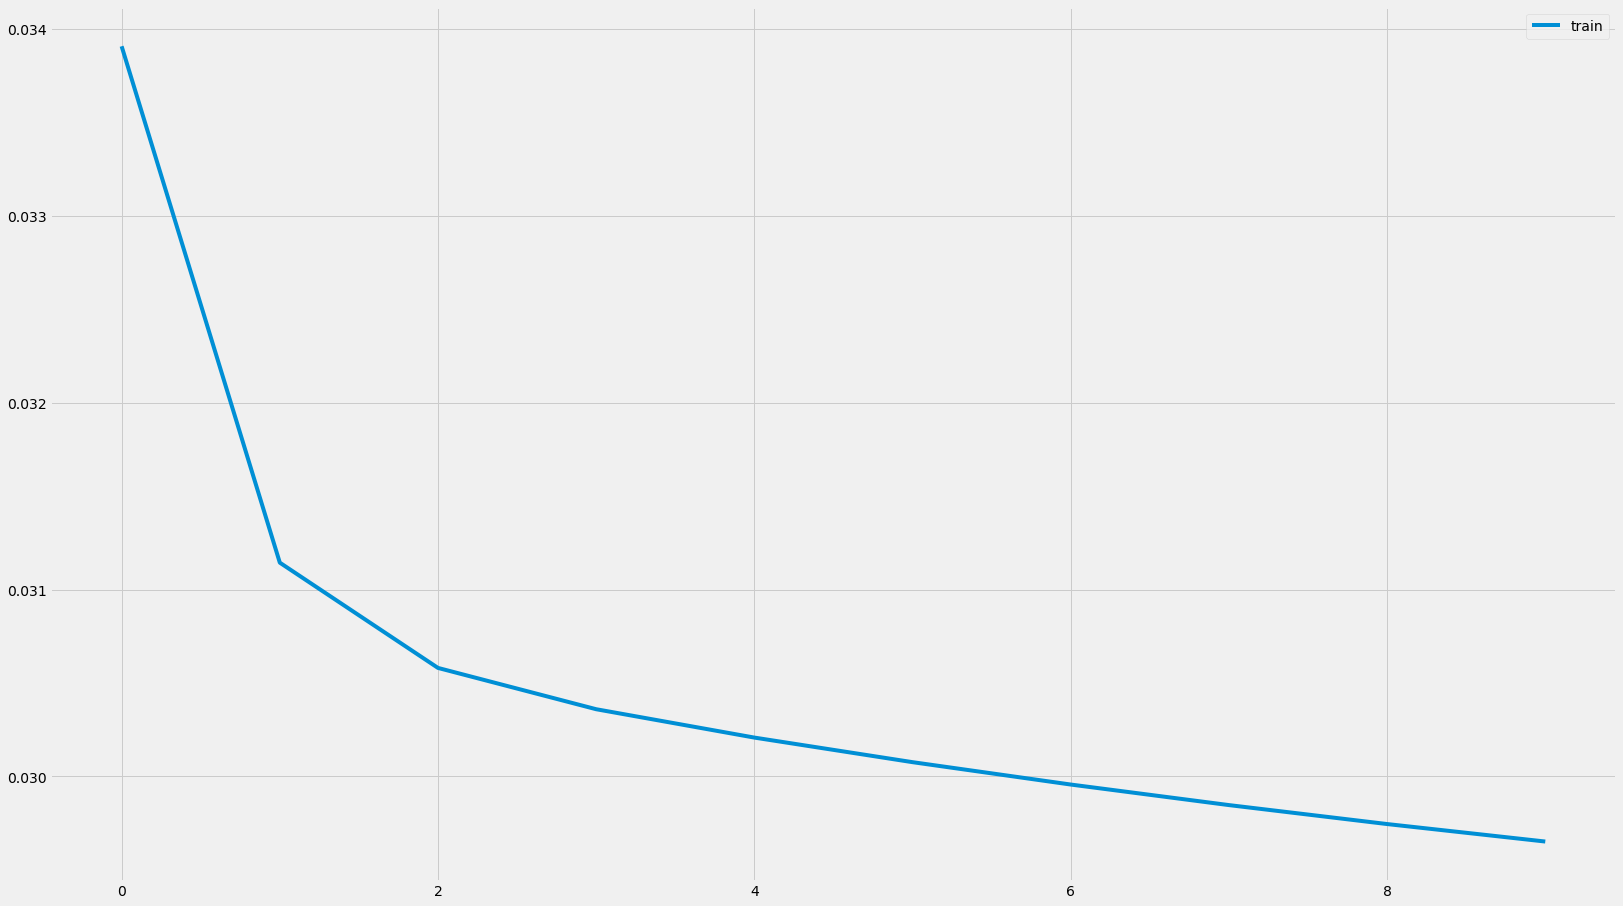

{'multi': 468.58374}
(3861, 1, 19) (3861,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 3s - loss: 0.0350 - 3s/epoch - 17ms/step
Epoch 2/10
161/161 - 0s - loss: 0.0326 - 500ms/epoch - 3ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0324 - 493ms/epoch - 3ms/step
Epoch 4/10
161/161 - 1s - loss: 0.0322 - 515ms/epoch - 3ms/step
Epoch 5/10
161/161 - 1s - loss: 0.0321 - 541ms/epoch - 3ms/step
Epoch 6/10
161/161 - 1s - loss: 0.0320 - 561ms/epoch - 3ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0318 - 532ms/epoch - 3ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0317 - 592ms/epoch - 4ms/step
Epoch 9/10
161/161 - 1s - loss: 0.0316 - 580ms/epoch - 4ms/step
Epoch 10/10
161/161 - 1s - loss: 0.0316 - 550ms/epoch - 3ms/step


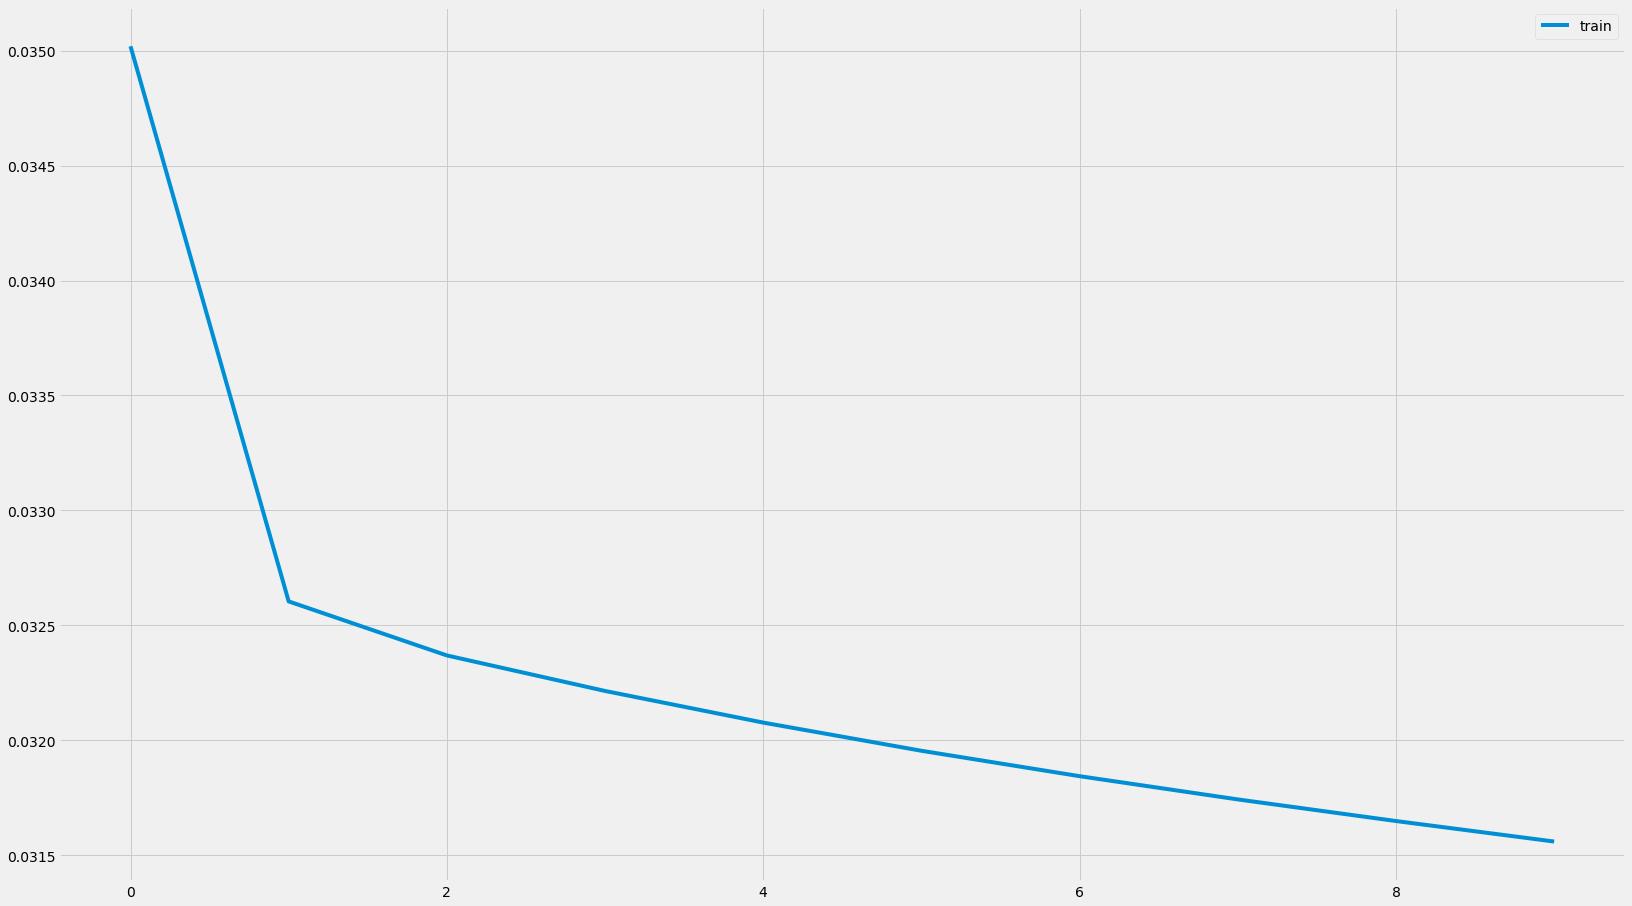

{'multi': 462.9894}
(3862, 1, 19) (3862,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 3s - loss: 0.0241 - 3s/epoch - 17ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0201 - 610ms/epoch - 4ms/step
Epoch 3/10
161/161 - 1s - loss: 0.0196 - 586ms/epoch - 4ms/step
Epoch 4/10
161/161 - 1s - loss: 0.0194 - 819ms/epoch - 5ms/step
Epoch 5/10
161/161 - 1s - loss: 0.0192 - 631ms/epoch - 4ms/step
Epoch 6/10
161/161 - 1s - loss: 0.0191 - 590ms/epoch - 4ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0190 - 617ms/epoch - 4ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0189 - 672ms/epoch - 4ms/step
Epoch 9/10
161/161 - 1s - loss: 0.0188 - 689ms/epoch - 4ms/step
Epoch 10/10
161/161 - 1s - loss: 0.0187 - 773ms/epoch - 5ms/step


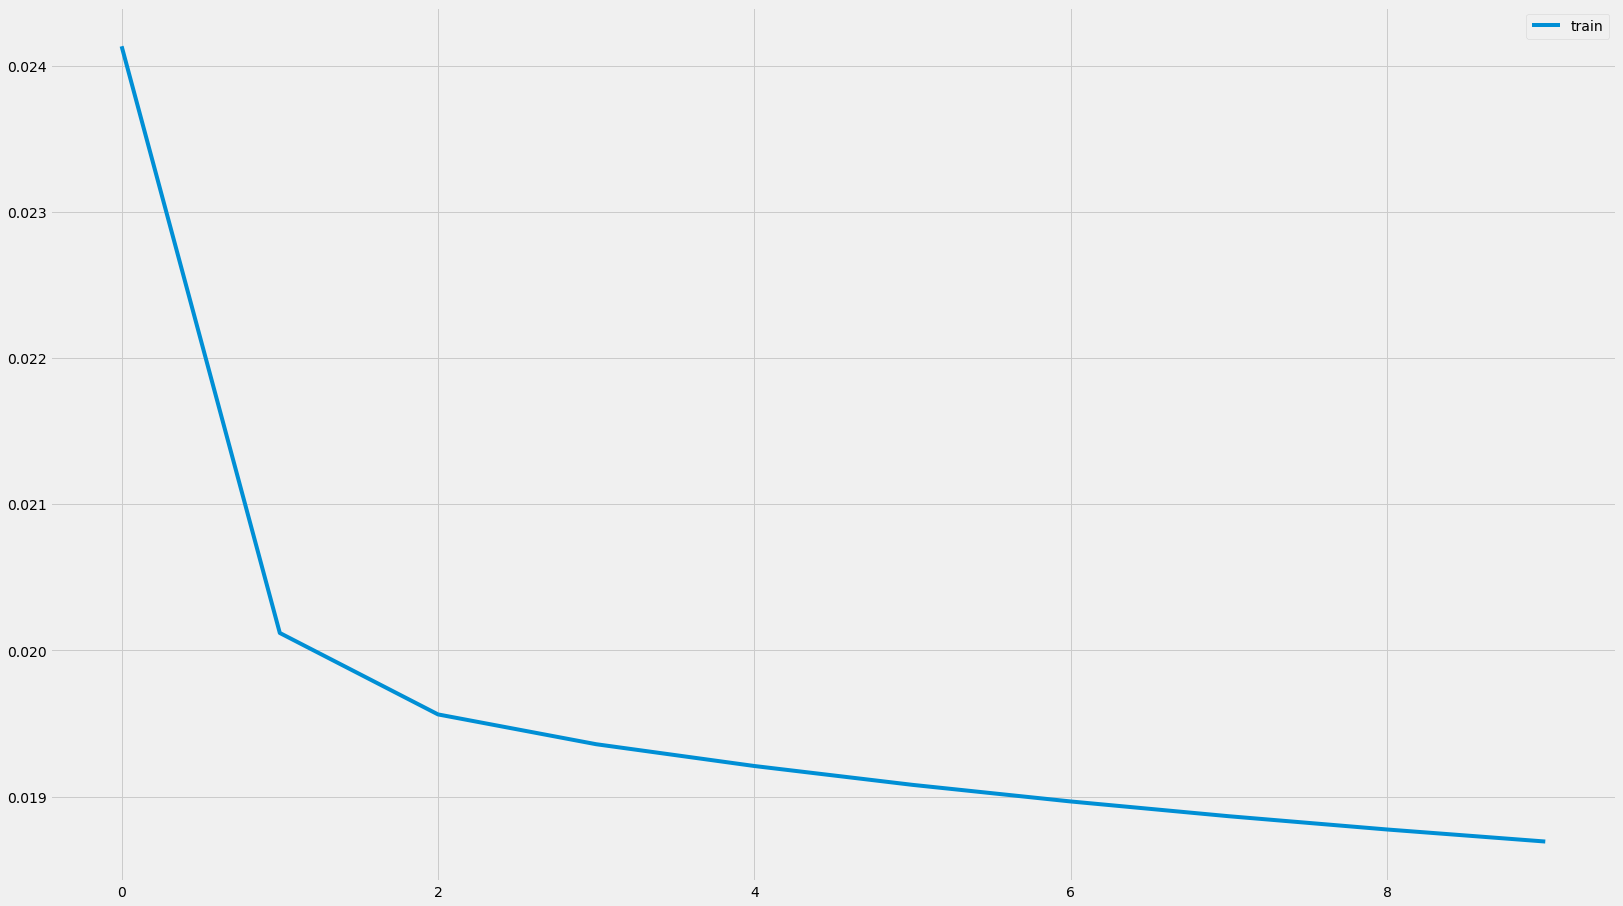

{'multi': 154.32986}
(3864, 1, 19) (3864,) (967, 1, 19) (967,)
Epoch 1/10
161/161 - 5s - loss: 0.0294 - 5s/epoch - 32ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0260 - 591ms/epoch - 4ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0257 - 500ms/epoch - 3ms/step
Epoch 4/10
161/161 - 1s - loss: 0.0256 - 627ms/epoch - 4ms/step
Epoch 5/10
161/161 - 0s - loss: 0.0255 - 449ms/epoch - 3ms/step
Epoch 6/10
161/161 - 1s - loss: 0.0254 - 748ms/epoch - 5ms/step
Epoch 7/10
161/161 - 1s - loss: 0.0253 - 711ms/epoch - 4ms/step
Epoch 8/10
161/161 - 1s - loss: 0.0252 - 587ms/epoch - 4ms/step
Epoch 9/10
161/161 - 1s - loss: 0.0251 - 616ms/epoch - 4ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0251 - 463ms/epoch - 3ms/step


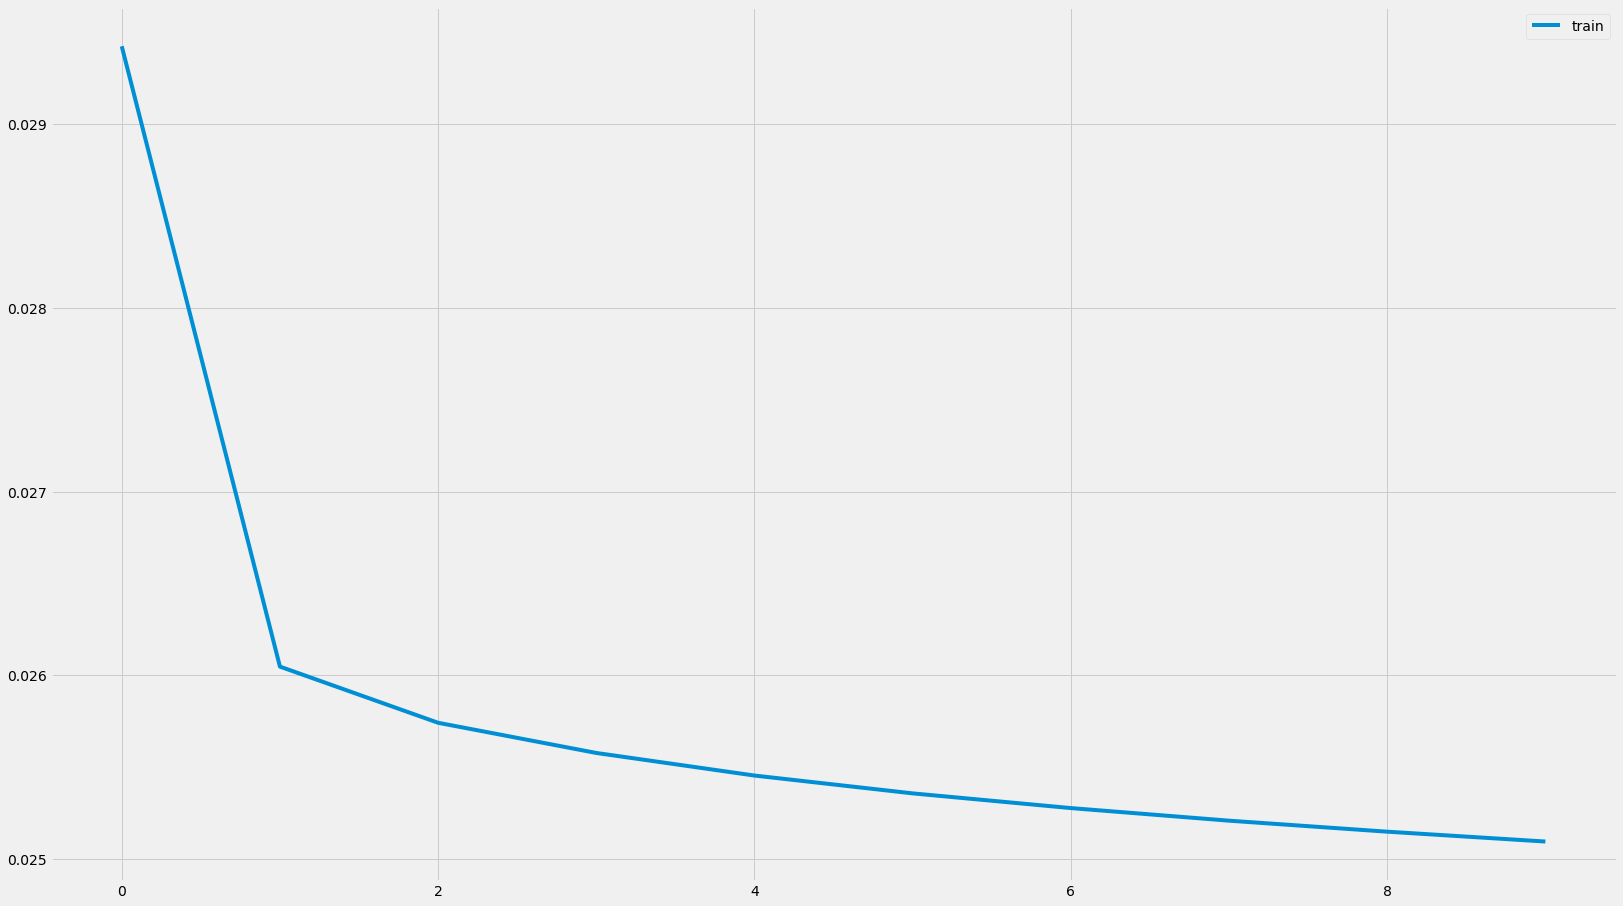

{'multi': 154.23076}
(3865, 1, 19) (3865,) (967, 1, 19) (967,)
Epoch 1/10
162/162 - 2s - loss: 0.0298 - 2s/epoch - 13ms/step
Epoch 2/10
162/162 - 0s - loss: 0.0244 - 496ms/epoch - 3ms/step
Epoch 3/10
162/162 - 0s - loss: 0.0234 - 494ms/epoch - 3ms/step
Epoch 4/10
162/162 - 1s - loss: 0.0232 - 506ms/epoch - 3ms/step
Epoch 5/10
162/162 - 0s - loss: 0.0231 - 484ms/epoch - 3ms/step
Epoch 6/10
162/162 - 1s - loss: 0.0230 - 504ms/epoch - 3ms/step
Epoch 7/10
162/162 - 1s - loss: 0.0229 - 512ms/epoch - 3ms/step
Epoch 8/10
162/162 - 1s - loss: 0.0228 - 534ms/epoch - 3ms/step
Epoch 9/10
162/162 - 0s - loss: 0.0228 - 486ms/epoch - 3ms/step
Epoch 10/10
162/162 - 0s - loss: 0.0227 - 491ms/epoch - 3ms/step


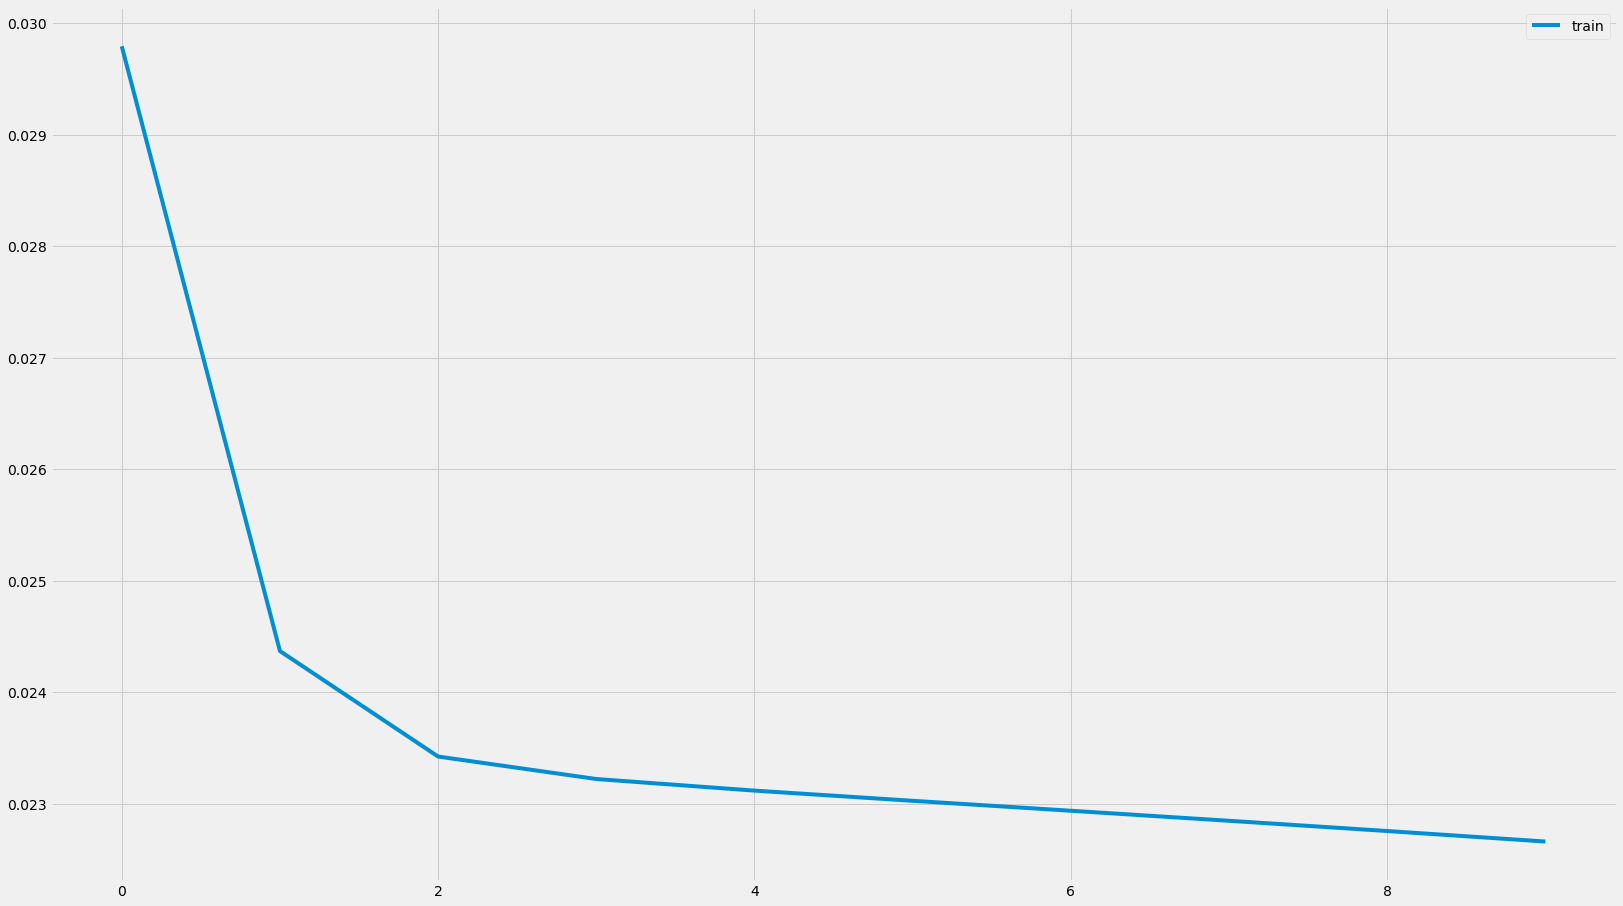

{'multi': 394.03818}
(3864, 1, 19) (3864,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 2s - loss: 0.0261 - 2s/epoch - 11ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0200 - 665ms/epoch - 4ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0190 - 436ms/epoch - 3ms/step
Epoch 4/10
161/161 - 1s - loss: 0.0186 - 535ms/epoch - 3ms/step
Epoch 5/10
161/161 - 0s - loss: 0.0184 - 458ms/epoch - 3ms/step
Epoch 6/10
161/161 - 0s - loss: 0.0183 - 495ms/epoch - 3ms/step
Epoch 7/10
161/161 - 0s - loss: 0.0183 - 444ms/epoch - 3ms/step
Epoch 8/10
161/161 - 0s - loss: 0.0182 - 446ms/epoch - 3ms/step
Epoch 9/10
161/161 - 0s - loss: 0.0181 - 449ms/epoch - 3ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0180 - 463ms/epoch - 3ms/step


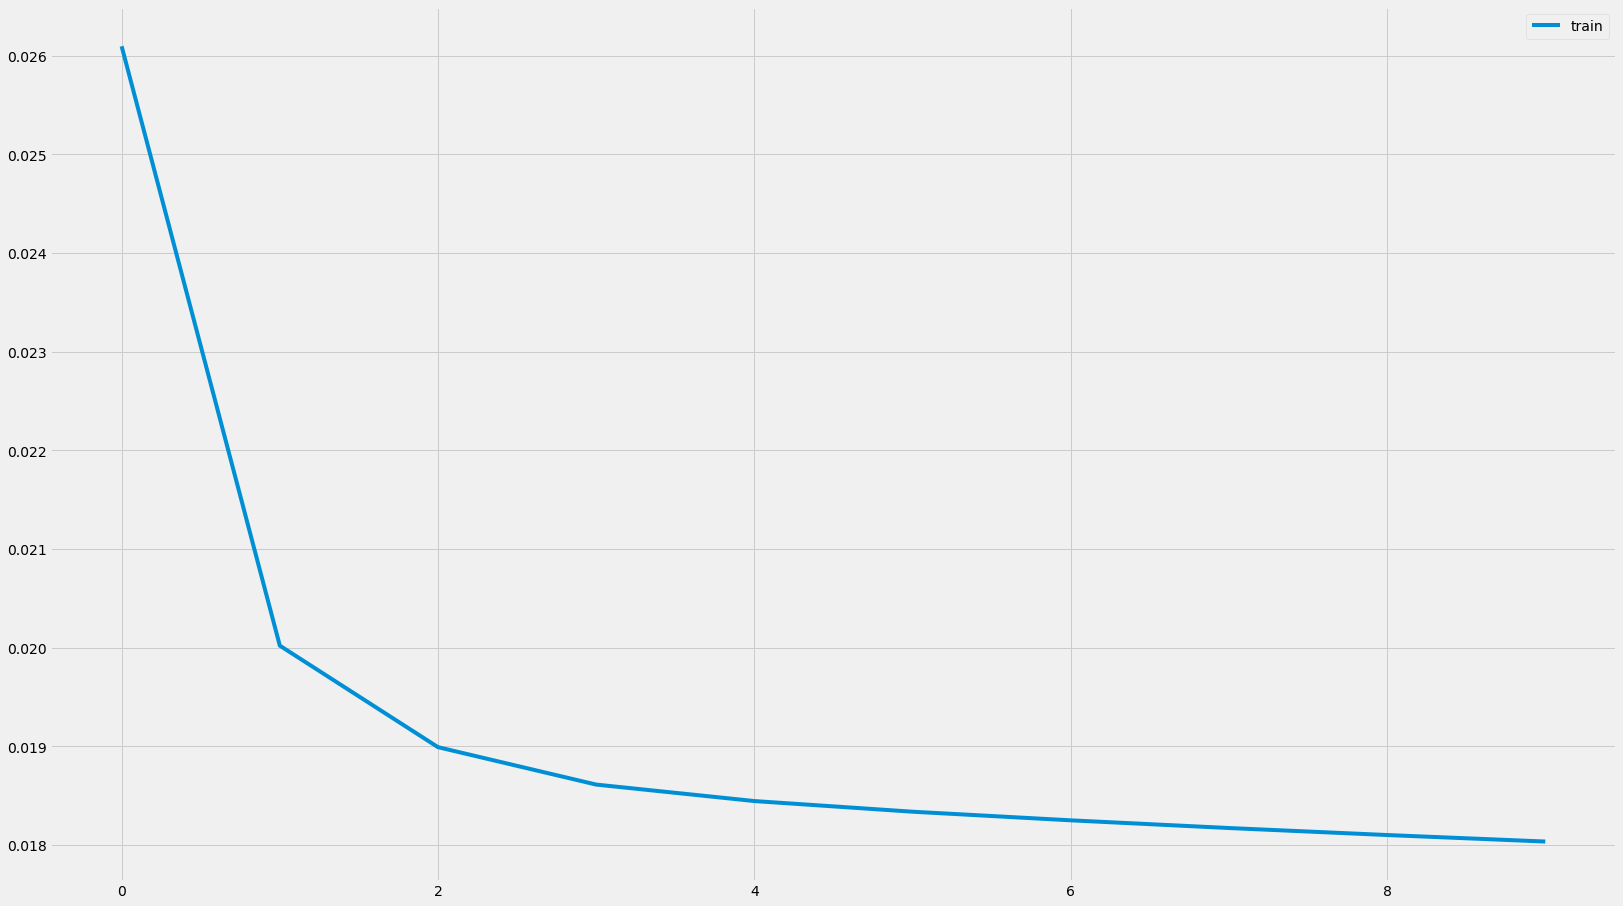

{'multi': 242.49013}
(3864, 1, 19) (3864,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 2s - loss: 0.0273 - 2s/epoch - 14ms/step
Epoch 2/10
161/161 - 0s - loss: 0.0256 - 442ms/epoch - 3ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0253 - 442ms/epoch - 3ms/step
Epoch 4/10
161/161 - 0s - loss: 0.0251 - 444ms/epoch - 3ms/step
Epoch 5/10
161/161 - 0s - loss: 0.0250 - 450ms/epoch - 3ms/step
Epoch 6/10
161/161 - 0s - loss: 0.0249 - 450ms/epoch - 3ms/step
Epoch 7/10
161/161 - 0s - loss: 0.0248 - 452ms/epoch - 3ms/step
Epoch 8/10
161/161 - 0s - loss: 0.0247 - 447ms/epoch - 3ms/step
Epoch 9/10
161/161 - 0s - loss: 0.0246 - 443ms/epoch - 3ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0245 - 446ms/epoch - 3ms/step


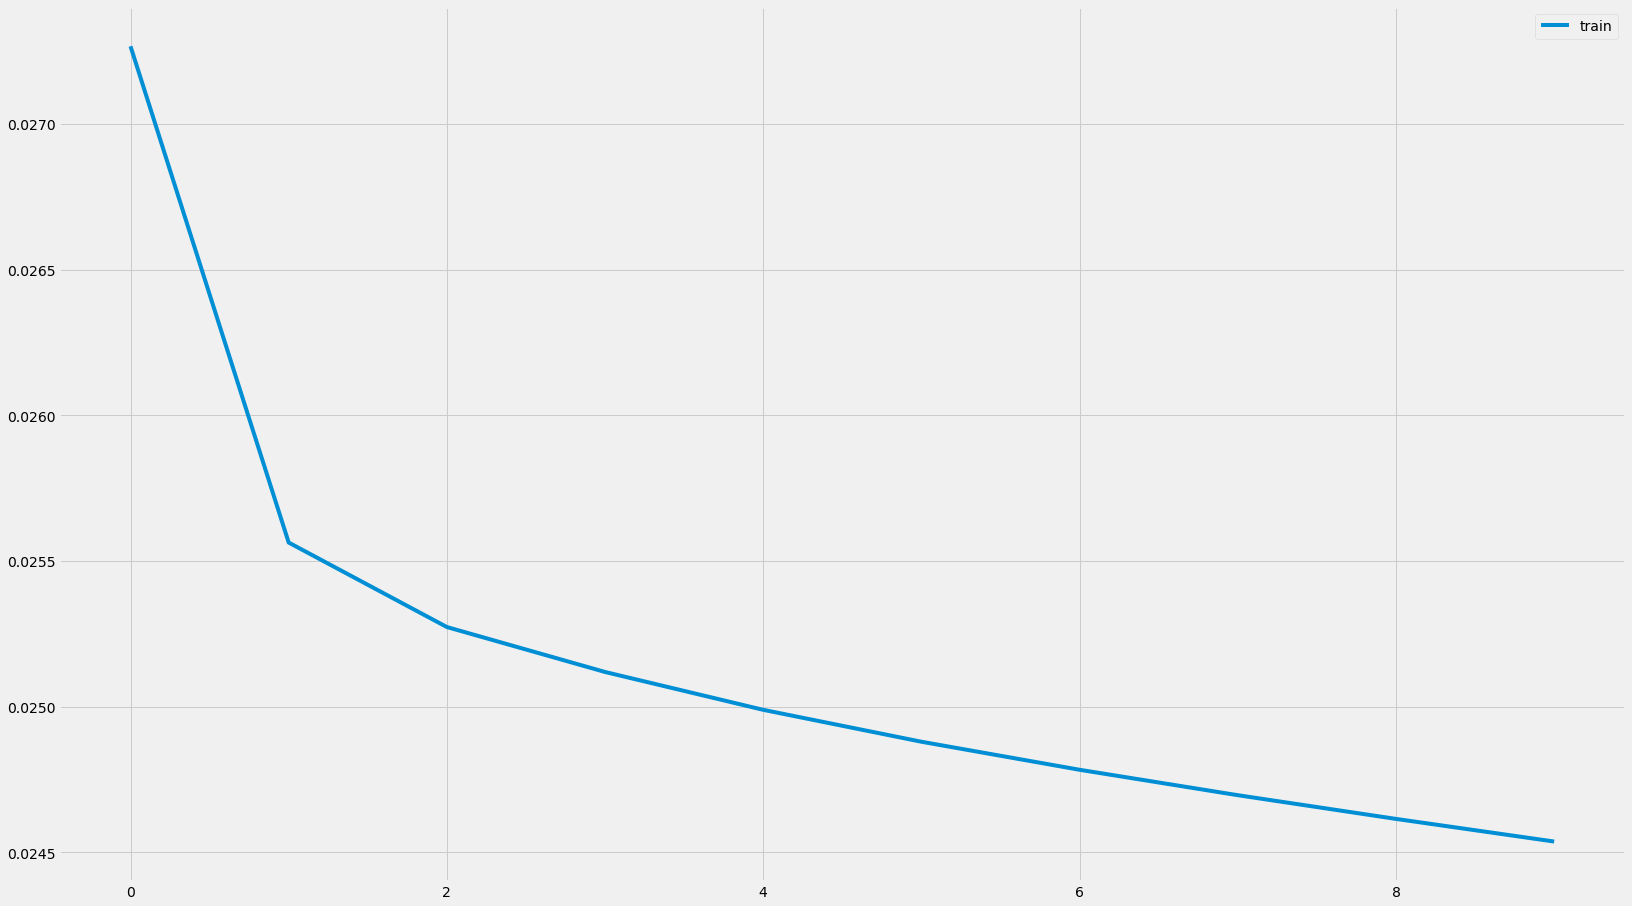

{'multi': 162.5305}
(3864, 1, 19) (3864,) (966, 1, 19) (966,)
Epoch 1/10
161/161 - 2s - loss: 0.0498 - 2s/epoch - 10ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0357 - 710ms/epoch - 4ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0318 - 444ms/epoch - 3ms/step
Epoch 4/10
161/161 - 0s - loss: 0.0306 - 440ms/epoch - 3ms/step
Epoch 5/10
161/161 - 0s - loss: 0.0300 - 439ms/epoch - 3ms/step
Epoch 6/10
161/161 - 0s - loss: 0.0297 - 464ms/epoch - 3ms/step
Epoch 7/10
161/161 - 0s - loss: 0.0294 - 457ms/epoch - 3ms/step
Epoch 8/10
161/161 - 0s - loss: 0.0292 - 447ms/epoch - 3ms/step
Epoch 9/10
161/161 - 0s - loss: 0.0290 - 449ms/epoch - 3ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0288 - 443ms/epoch - 3ms/step


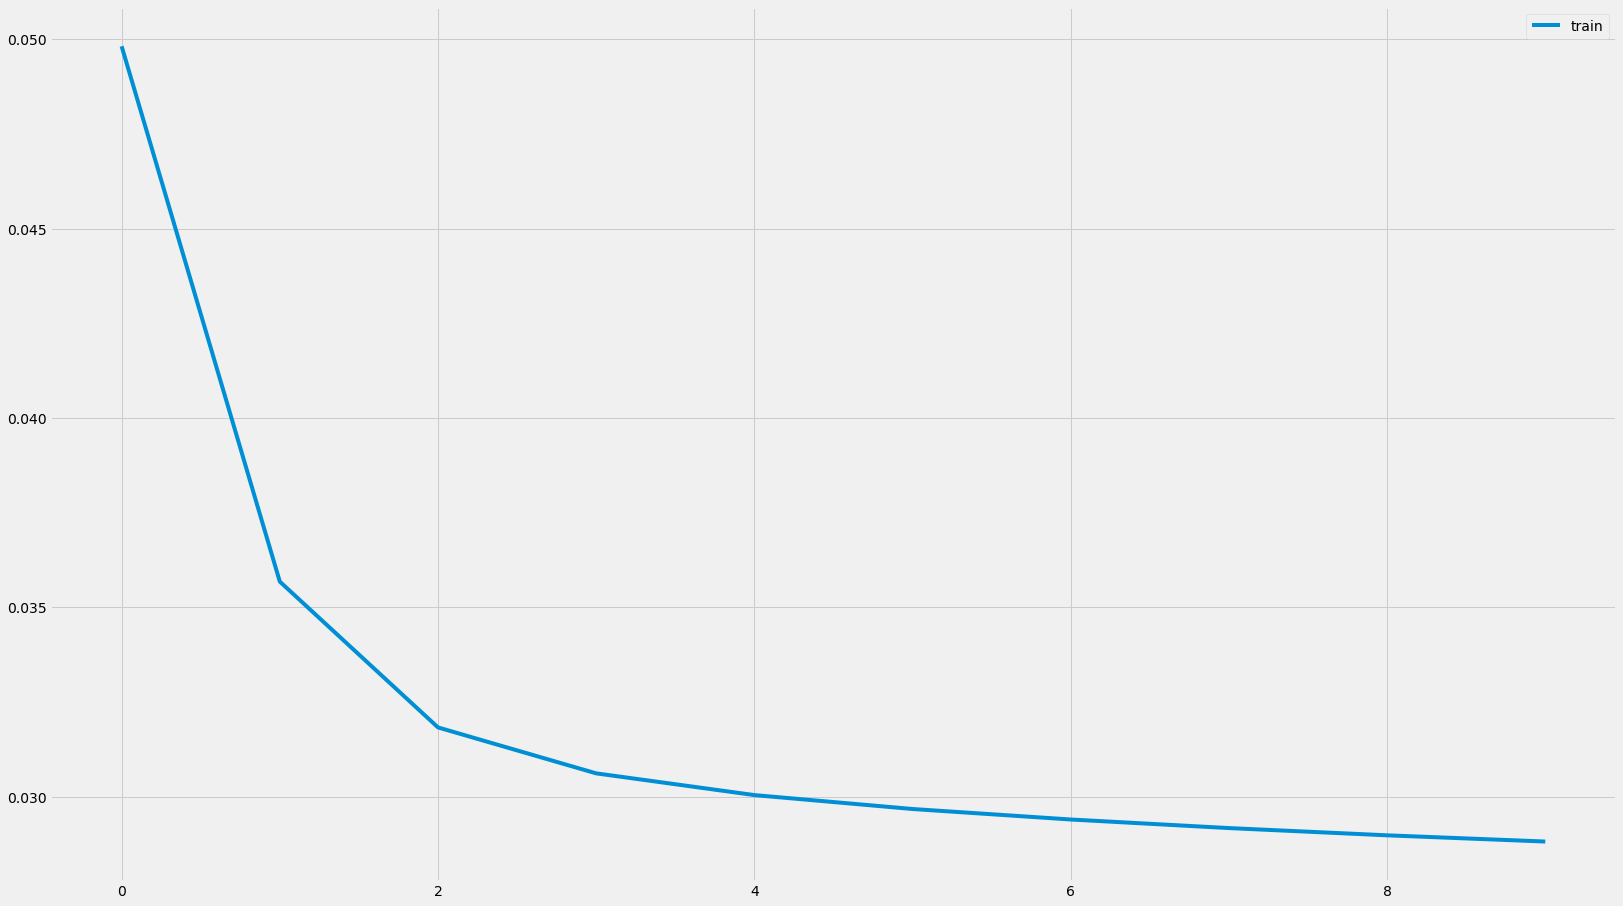

{'multi': 342.56534}
(3865, 1, 19) (3865,) (967, 1, 19) (967,)
Epoch 1/10
162/162 - 2s - loss: 0.0322 - 2s/epoch - 14ms/step
Epoch 2/10
162/162 - 0s - loss: 0.0304 - 498ms/epoch - 3ms/step
Epoch 3/10
162/162 - 0s - loss: 0.0301 - 492ms/epoch - 3ms/step
Epoch 4/10
162/162 - 0s - loss: 0.0299 - 499ms/epoch - 3ms/step
Epoch 5/10
162/162 - 0s - loss: 0.0298 - 492ms/epoch - 3ms/step
Epoch 6/10
162/162 - 0s - loss: 0.0297 - 491ms/epoch - 3ms/step
Epoch 7/10
162/162 - 0s - loss: 0.0296 - 491ms/epoch - 3ms/step
Epoch 8/10
162/162 - 1s - loss: 0.0295 - 505ms/epoch - 3ms/step
Epoch 9/10
162/162 - 1s - loss: 0.0295 - 510ms/epoch - 3ms/step
Epoch 10/10
162/162 - 0s - loss: 0.0294 - 500ms/epoch - 3ms/step


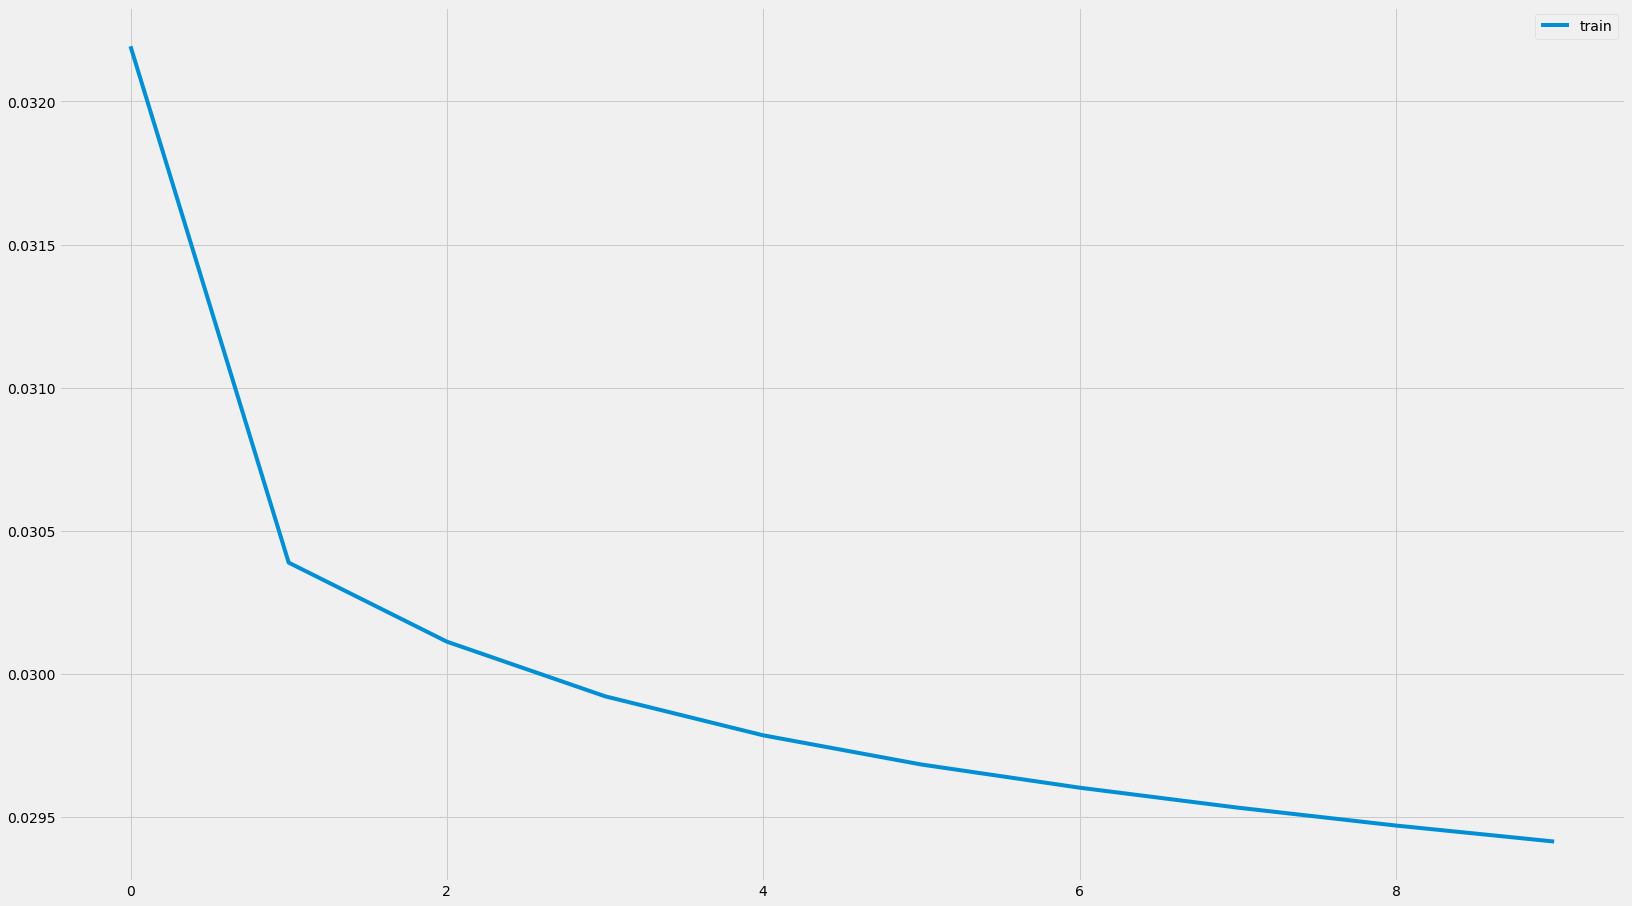

{'multi': 226.27444}


In [149]:
for house in houses:
    train_model(house, epochs=10, plot=False)

# Federated version

In [48]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_percentage_error

In [49]:
class SimpleLSTM:
    @staticmethod
    def build(neurons, timesteps =1, n_features=1):
        model = Sequential()
        model.add(LSTM(neurons, input_shape =(timesteps,n_features)))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])
        
        
        return model

In [61]:
def weight_scalling_factor(clients_trn_data, client_name):
    #client_names = list(homes.columns())
    #get the bs
    #bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clients
    global_count = sum([len(clients_trn_data[client_name].dropna()) for client_name in client_names])
    # get the total number of data points held by a client
    local_count = len(clients_trn_data[client_name].dropna())
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

def mape(y_true,y_score):
    error = mean_absolute_percentage_error(y_true, y_score)
    return error
    
def test_model(X_test, Y_test,  model, comm_round, home):
    preds= model.predict(X_test)
    loss = rmse(Y_test, preds)
    scaled_preds = scaler.inverse_transform(preds)
    scaled_loss = rmse(scaler.inverse_transform(Y_test), scaled_preds)
    print('comm_round: {} |loss_in_{}: {} | scaled_loss_in_{}: {}'.format(comm_round,home,loss, home, scaled_loss))
    return loss, scaled_loss, preds, scaled_preds

In [62]:
def prepare_task(home: pd.Series, train_size= 0.9, timesteps= 1):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    #print(X_train.shape)

    return X_train, y_train, X_test, y_test, scaler


In [63]:
comms_round = 10
    
#create optimizer
lr = 0.1 
loss='mean_squared_error'
metrics = ['mse']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 



In [64]:
client_names = refit.columns

In [65]:
#initialize global model
smlp_global = SimpleLSTM()
global_model = smlp_global.build(128, 1, 1)
        


In [66]:

pred_train={}
pred_test= {}

rmse_train={}
rmse_test={}

mape_train ={}
mape_test ={}

In [60]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for house in refit:
        smlp_local = SimpleLSTM()
        local_model = smlp_local.build(128)
        local_model.compile(loss=loss, 
                        optimizer=optimizer, #Trying out adam
                        metrics=metrics)
        
        
    #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        #scaler = MinMaxScaler(feature_range=(0, 1))
        X_train, y_train, X_test, y_test, scaler= prepare_task(refit[house])


        local_model.fit(X_train, y_train, epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(refit, house)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        local_loss = test_model(X_test, y_test, global_model, comm_round, house)


        pred_train[f"true_{house}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
        pred_test[f"true_{house}"]  = scaler.inverse_transform(y_test).flatten() 

        pred_train[f"fed_{house}"] = scaler.inverse_transform(
                                    local_model.predict(X_train)).flatten()

        pred_test[f"fed_{house}"] = scaler.inverse_transform(local_model.predict(X_test)).flatten()

        rmse_test[f'fed_{house}'] = rmse(pred_test[f'true_{house}'], pred_test[f'fed_{house}'])
        rmse_train[f'fed_{house}'] = rmse(pred_train[f'true_{house}'], pred_train[f'fed_{house}'])

        mape_train[f'fed_{house}'] = mape(pred_train[f'true_{house}'], pred_train[f'fed_{house}'])
        mape_test[f'fed_{house}'] = mape(pred_test[f'true_{house}'], pred_test[f'fed_{house}'])

        # #plot the predictions
        # plt.plot(pred_test[f'true_{home}'])
        # plt.plot(pred_test[f'simple_lstm_{home}'])
        # plt.show()

        K.clear_session()
    
            
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
  

comm_round: 0 |loss_in_house_0: 0.10829603768457474 | scaled_loss_in_house_0: 478.1090206187166
comm_round: 0 |loss_in_house_1: 0.14193282669558285 | scaled_loss_in_house_1: 610.4064035713803
comm_round: 0 |loss_in_house_2: 0.36015713656481807 | scaled_loss_in_house_2: 874.7396469897755


KeyboardInterrupt: 

In [263]:
pd.DataFrame.from_dict(rmse_test, orient='index').to_csv("results.csv")

## ARIMA

In [12]:
#ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [16]:
#Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(dataframes_list[0]['Aggregate'].dropna(),autolag="AIC")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.686660
p-value: 0.000000


In [18]:
#Time Series split
from sklearn.model_selection import TimeSeriesSplit
tscv= TimeSeriesSplit(n_splits=15,max_train_size=780)

In [51]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [29]:
X_train, X_test = train_test_split(dataframes_list[0], train_size=0.8, shuffle=False)

In [32]:

nums= X_train.select_dtypes("float64")

In [41]:
X_train[nums.columns]

Aggregate  Appliance1  Appliance2  Appliance3  \
Time                                                                  
2014-03-07 10:00:00  320.854839    0.000000    4.870968    1.000000   
2014-03-07 11:00:00  328.612457    0.001730    4.858131    1.152249   
2014-03-07 12:00:00  138.138840    0.000000    4.894552    1.001757   
2014-03-07 13:00:00  156.106061   86.231602    4.885281    1.000000   
2014-03-07 14:00:00  139.351852    9.205387    4.877104    1.001684   
...                         ...         ...         ...         ...   
2015-04-01 09:00:00  153.953125   49.479167    4.885417    0.000000   
2015-04-01 10:00:00  153.953125   49.479167    4.885417    0.000000   
2015-04-01 11:00:00  153.953125   49.479167    4.885417    0.000000   
2015-04-01 12:00:00  153.953125   49.479167    4.885417    0.000000   
2015-04-01 13:00:00  153.953125   49.479167    4.885417    0.000000   

                     Appliance4  Appliance5  Appliance6  Appliance7  \
Time                                                                  
2014-03-07 10:00:00         0.0         0.0         0.0         0.0   
2014-03-07 11:00:00         0.0         0.0         0.0         0.0   
2014-03-07 12:00:00         0.0         0.0         0.0         0.0   
2014-03-07 13:00:00         0.0         0.0         0.0         0.0   
2014-03-07 14:00:00         0.0         0.0         0.0         0.0   
...                         ...         ...         ...         ...   
2015-04-01 09:00:00         0.0         0.0         0.0         0.0   
2015-04-01 10:00:00         0.0         0.0         0.0         0.0   
2015-04-01 11:00:00         0.0         0.0         0.0         0.0   
2015-04-01 12:00:00         0.0         0.0         0.0         0.0   
2015-04-01 13:00:00         0.0         0.0         0.0         0.0   

                     Appliance8  Appliance9    lag_hour     lag_day  \
Time                                                                  
2014-03-07 10:00:00         0.0         0.0         NaN         NaN   
2014-03-07 11:00:00         0.0         0.0  320.854839         NaN   
2014-03-07 12:00:00         0.0         0.0  328.612457         NaN   
2014-03-07 13:00:00         0.0         0.0  138.138840         NaN   
2014-03-07 14:00:00         0.0         0.0  156.106061         NaN   
...                         ...         ...         ...         ...   
2015-04-01 09:00:00         0.0         0.0  153.953125  153.953125   
2015-04-01 10:00:00         0.0         0.0  153.953125  153.953125   
2015-04-01 11:00:00         0.0         0.0  153.953125  153.953125   
2015-04-01 12:00:00         0.0         0.0  153.953125  153.953125   
2015-04-01 13:00:00         0.0         0.0  153.953125  153.953125   

                       lag_week  
Time                             
2014-03-07 10:00:00         NaN  
2014-03-07 11:00:00         NaN  
2014-03-07 12:00:00         NaN  
2014-03-07 13:00:00         NaN  
2014-03-07 14:00:00         NaN  
...                         ...  
2015-04-01 09:00:00  149.805941  
2015-04-01 10:00:00  149.823413  
2015-04-01 11:00:00  217.244533  
2015-04-01 12:00:00  438.905433  
2015-04-01 13:00:00  352.930412  

[9364 rows x 13 columns]

In [42]:
# Scaling the data to the interval [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X_train[nums.columns])

X_train[nums.columns] = scaler.transform(X_train[nums.columns])
X_test[nums.columns] = scaler.transform(X_test[nums.columns])

/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [46]:
X_train.describe()

Aggregate   Appliance1   Appliance2   Appliance3   Appliance4  \
count  9364.000000  9364.000000  9364.000000  9364.000000  9364.000000   
mean      0.056341     0.206215     0.187975     0.012732     0.060427   
std       0.084459     0.172323     0.300955     0.055202     0.129457   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.007070     0.019450     0.002136     0.000000     0.000000   
50%       0.023257     0.198772     0.016314     0.002794     0.000000   
75%       0.067386     0.348341     0.237162     0.002794     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

        Appliance5   Appliance6  Appliance7  Appliance8  Appliance9  ...  \
count  9364.000000  9364.000000      9364.0      9364.0      9364.0  ...   
mean      0.009603     0.050610         0.0         0.0         0.0  ...   
std       0.062287     0.181085         0.0         0.0         0.0  ...   
min       0.000000     0.000000         0.0         0.0         0.0  ...   
25%       0.000000     0.000000         0.0         0.0         0.0  ...   
50%       0.000000     0.000000         0.0         0.0         0.0  ...   
75%       0.000000     0.000000         0.0         0.0         0.0  ...   
max       1.000000     1.000000         0.0         0.0         0.0  ...   

         dayofweek      quarter        month         year    dayofyear  \
count  9364.000000  9364.000000  9364.000000  9364.000000  9364.000000   
mean      3.000000     2.413712     6.300085  2014.232166   176.259504   
std       2.004268     1.140896     3.444418     0.422237   105.116303   
min       0.000000     1.000000     1.000000  2014.000000     1.000000   
25%       1.000000     1.000000     3.000000  2014.000000    82.000000   
50%       3.000000     2.000000     6.000000  2014.000000   170.000000   
75%       5.000000     3.000000     9.000000  2014.000000   268.000000   
max       6.000000     4.000000    12.000000  2015.000000   365.000000   

        dayofmonth        night     lag_hour      lag_day     lag_week  
count  9364.000000  9364.000000  9363.000000  9340.000000  9196.000000  
mean     15.917984     0.499786     0.056346     0.056468     0.056224  
std       8.753065     0.500027     0.084462     0.084531     0.083744  
min       1.000000     0.000000     0.000000     0.000000     0.000000  
25%       8.000000     0.000000     0.007071     0.007105     0.007080  
50%      16.000000     0.000000     0.023258     0.023439     0.023418  
75%      23.000000     1.000000     0.067393     0.067634     0.067362  
max      31.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 21 columns]

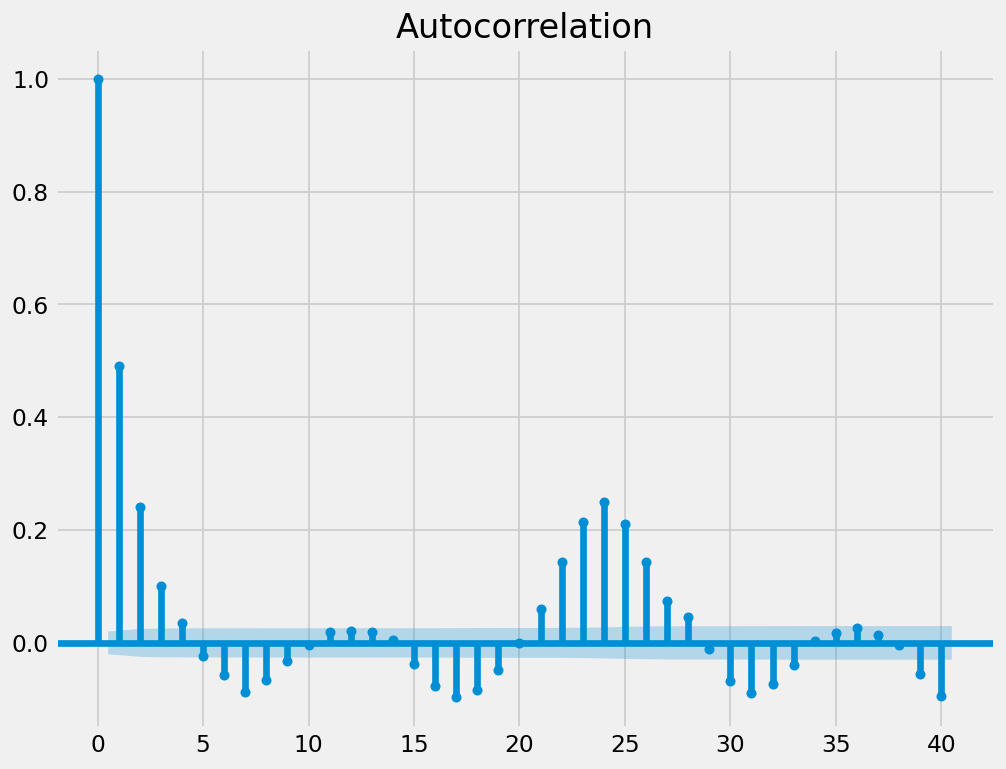

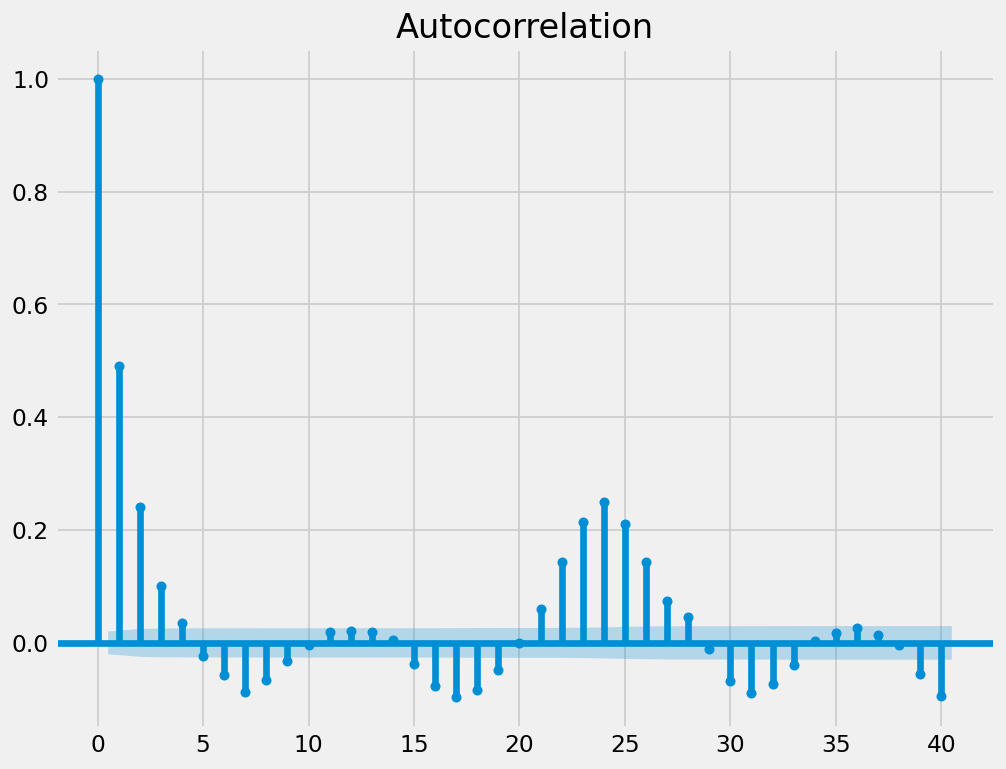

In [44]:
plot_acf(X_train['Aggregate'])


In [47]:
model= pm.auto_arima(X_train["Aggregate"], seasonal=True, suppress_warnings=True)


In [49]:

preds, conf_int = model.predict(n_periods=X_test.shape[0], return_conf_int=True)

In [52]:
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(X_test['Aggregate'], preds)))

Test RMSE: 0.075


Text(0.5, 0, 'Year')

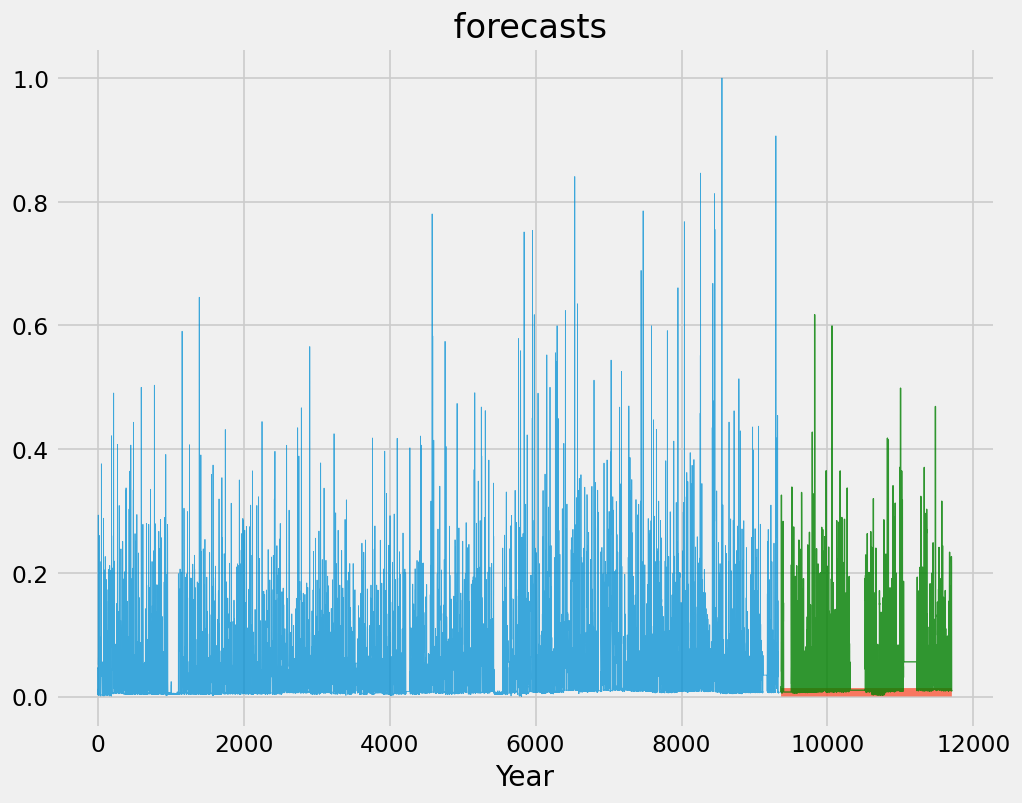

In [53]:
# Plot the points and the forecasts
x_axis = np.arange(X_train.shape[0] + preds.shape[0])
x_years = x_axis 

plt.plot(x_years[x_axis[:X_train.shape[0]]], X_train['Aggregate'], alpha=0.75, lw=0.5)
plt.plot(x_years[x_axis[X_train.shape[0]:]], preds, alpha=0.75, lw=5)  # Forecasts
plt.plot(x_years[x_axis[X_train.shape[0]:]], X_test['Aggregate'],
            alpha=0.8, c="g", lw=0.8)  # Test data
# plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='b')
plt.title(" forecasts")
plt.xlabel("Year")

In [77]:

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    


[ 320.85483871  328.61245675  138.13884007  156.10606061  139.35185185
  163.66331658  176.08658009  162.96367521 1418.65892857  350.1957672
  401.89212329  263.69860627  152.12878788  175.82490975  160.87341772
  135.87114338  131.84162063  143.26775956  143.1261426   131.40699816
  154.96428571 1068.54166667 1272.56672761  529.65280289  140.26691042
  263.44144144  234.12363636  218.00544465  546.15699659  140.09563758
  310.55387205  219.64655172  547.43133803  345.37659963  444.36
  310.26666667  256.26545455  144.14673913  157.25840708  140.03085299
  127.99267399  136.84909091  138.37892791  127.42115028  339.0749543
 1043.04136691 1086.82817869  728.38018018  318.44262295  306.76311031
  867.37163375 1784.13309353  858.42980936  907.99643494  271.16420664
  267.75719424  325.06118881  338.11484099  294.73083779  286.05820106
  196.3540146   136.25090909  131.6024735   137.39927405  139.14981949
  135.28228782  131.6101083   140.93967093  370.61001789  324.70178571
  145.09821429

## Prophet

In [173]:
#Prophet

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [175]:
dataframes_list[0]['Agg_transformed']

Time
2014-03-07 10:00:00    1.129658
2014-03-07 11:00:00    1.129805
2014-03-07 12:00:00    1.121940
2014-03-07 13:00:00    1.123439
2014-03-07 14:00:00    1.122052
                         ...   
2015-07-07 22:00:00    1.131198
2015-07-07 23:00:00    1.124752
2015-07-08 00:00:00    1.123899
2015-07-08 01:00:00    1.124126
2015-07-08 02:00:00    1.124255
Freq: H, Name: Agg_transformed, Length: 11705, dtype: float64

In [182]:
X = dataframes_list[0]

In [183]:
X_train, X_test = train_test_split(X, test_size=0.1, shuffle=False)

In [184]:
X_train['ds']= X_train.index
X_test['ds'] = X_test.index

X_train = X_train[['ds','Agg_transformed']]
X_test = X_test[['ds','Agg_transformed']]

/var/folders/nm/jvmw76_11mbgvd6lxfqd3cg00000gq/T/ipykernel_67757/2259697320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ds']= X_train.index
/var/folders/nm/jvmw76_11mbgvd6lxfqd3cg00000gq/T/ipykernel_67757/2259697320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ds'] = X_test.index


In [188]:
# Format data for prophet model using ds and y
X_train =X_train.reset_index()
X_train= X_train[['ds','Agg_transformed']]
X_train =X_train.rename(columns={"Agg_transformed":"y"})


In [193]:
model= Prophet(interval_width=0.95,yearly_seasonality=False, weekly_seasonality=True,daily_seasonality=True)
model.fit(X_train)

Initial log joint probability = -2.14227


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       56180.8   0.000450998       14647.4        0.53        0.53      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       56201.3   0.000492814       3501.14           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       56211.1    0.00013198       10232.5           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       56221.5   1.90669e-06       2740.34      0.3105      0.3105      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       56233.4   8.44491e-05       6847.05      0.6656      0.6656      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599    

In [194]:
prediction = model.predict(X_test)

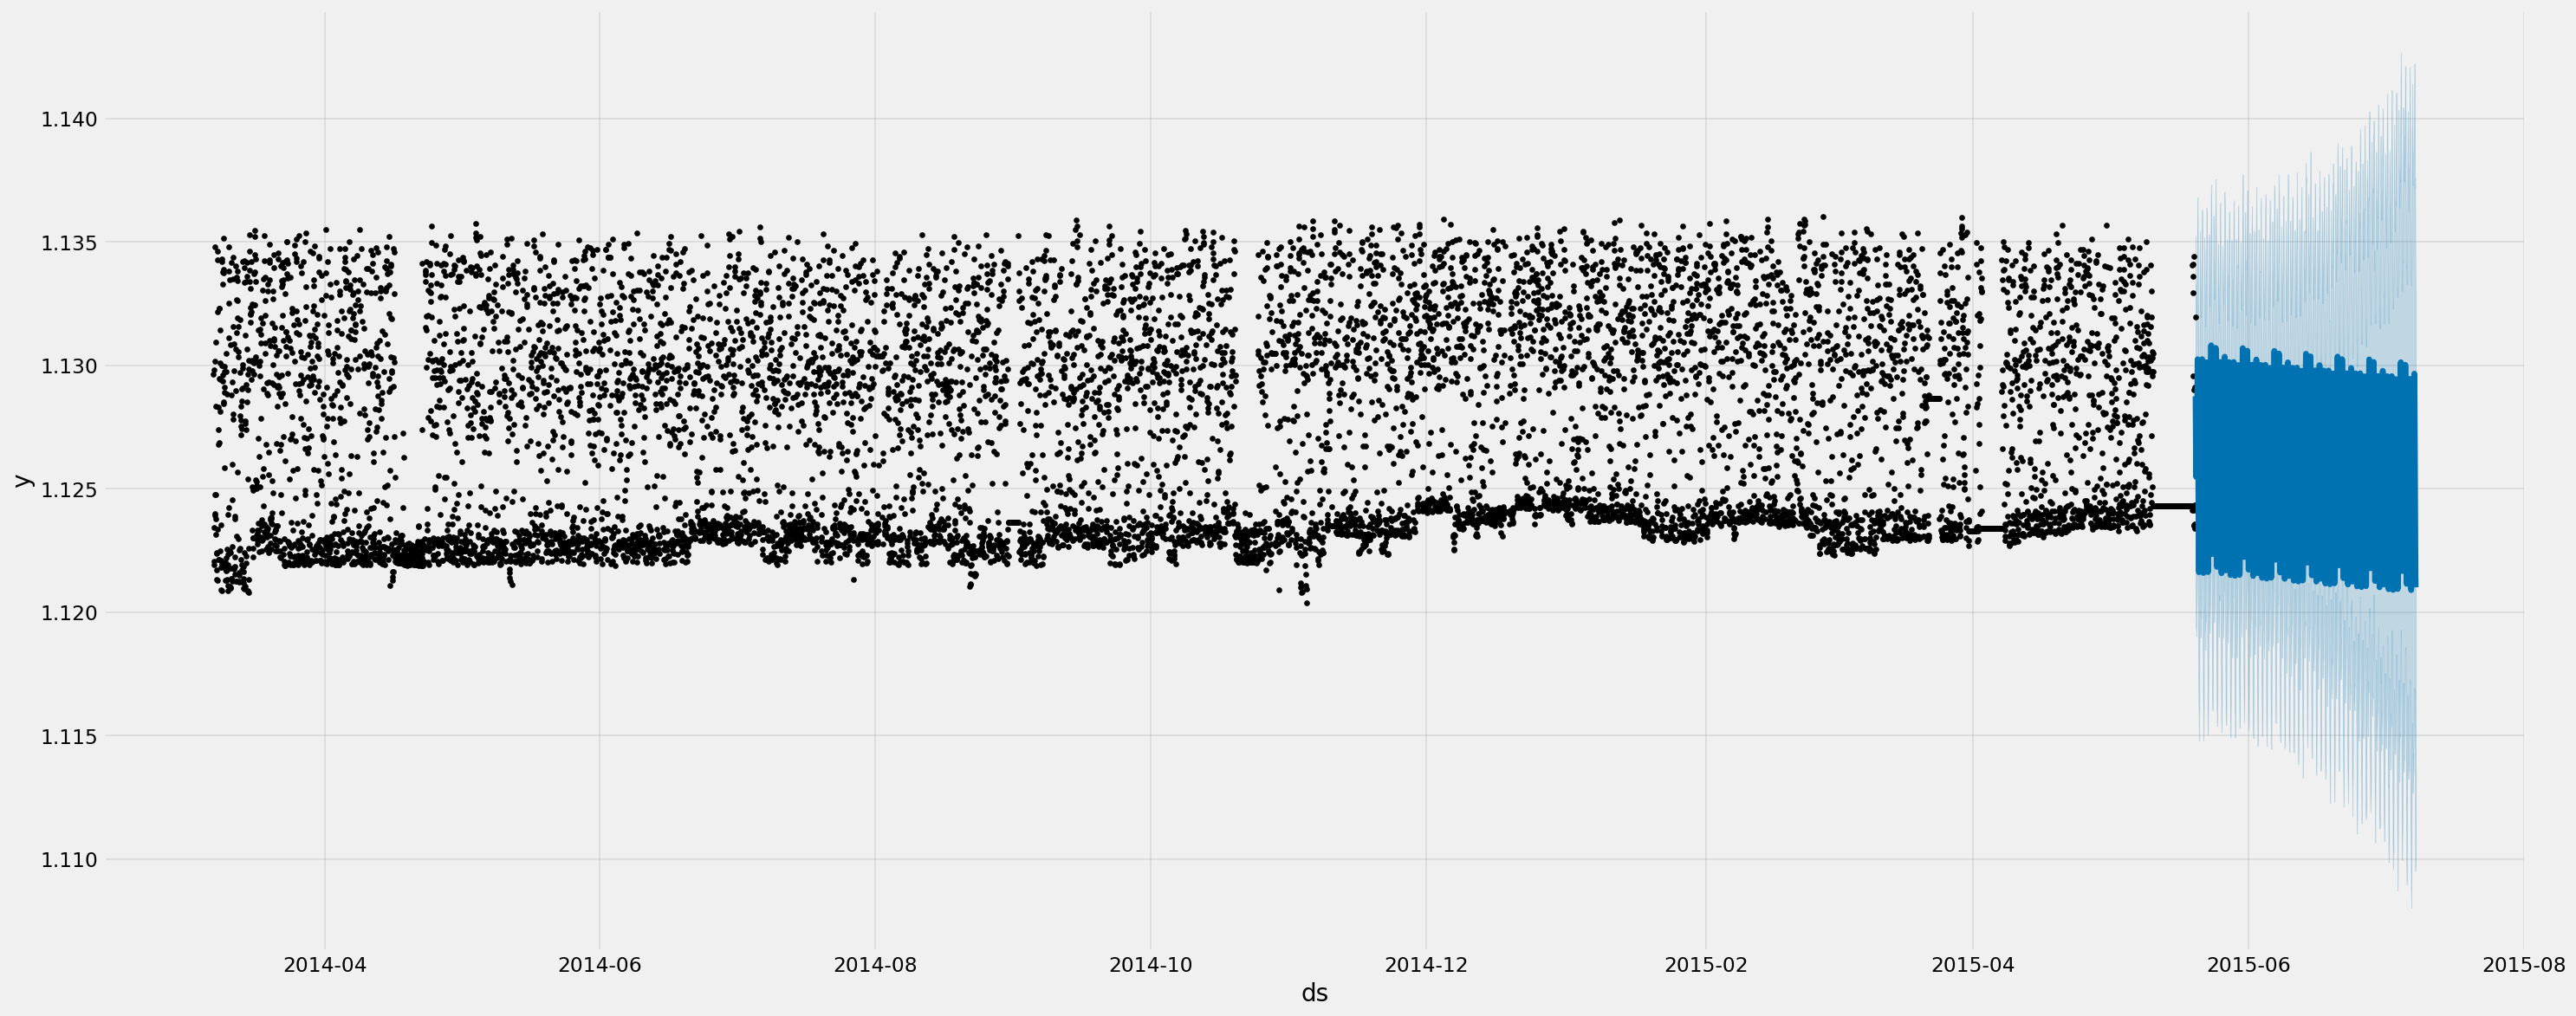

In [195]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(25)
fig = model.plot(prediction,
                 ax=ax)
plt.show()

In [196]:
type(prediction)

pandas.core.frame.DataFrame

In [209]:
prediction.index= prediction.ds

In [210]:
prediction

ds     trend  yhat_lower  yhat_upper  \
ds                                                                          
2015-05-20 08:00:00 2015-05-20 08:00:00  1.126385    1.122377    1.135244   
2015-05-20 09:00:00 2015-05-20 09:00:00  1.126384    1.120714    1.133504   
2015-05-20 10:00:00 2015-05-20 10:00:00  1.126383    1.119377    1.132595   
2015-05-20 11:00:00 2015-05-20 11:00:00  1.126383    1.119549    1.131978   
2015-05-20 12:00:00 2015-05-20 12:00:00  1.126382    1.119027    1.132429   
...                                 ...       ...         ...         ...   
2015-07-07 22:00:00 2015-07-07 22:00:00  1.125591    1.113027    1.137185   
2015-07-07 23:00:00 2015-07-07 23:00:00  1.125590    1.110238    1.137598   
2015-07-08 00:00:00 2015-07-08 00:00:00  1.125590    1.109522    1.134773   
2015-07-08 01:00:00 2015-07-08 01:00:00  1.125589    1.109992    1.133779   
2015-07-08 02:00:00 2015-07-08 02:00:00  1.125588    1.109861    1.132838   

                     trend_lower  trend_upper  additive_terms  \
ds                                                              
2015-05-20 08:00:00     1.126385     1.126385        0.002363   
2015-05-20 09:00:00     1.126384     1.126384        0.001231   
2015-05-20 10:00:00     1.126383     1.126383       -0.000147   
2015-05-20 11:00:00     1.126383     1.126383       -0.000898   
2015-05-20 12:00:00     1.126382     1.126382       -0.000799   
...                          ...          ...             ...   
2015-07-07 22:00:00     1.114969     1.136264       -0.000196   
2015-07-07 23:00:00     1.114954     1.136275       -0.001976   
2015-07-08 00:00:00     1.114939     1.136286       -0.003235   
2015-07-08 01:00:00     1.114924     1.136296       -0.004081   
2015-07-08 02:00:00     1.114908     1.136307       -0.004578   

                     additive_terms_lower  additive_terms_upper     daily  \
ds                                                                          
2015-05-20 08:00:00              0.002363              0.002363  0.002440   
2015-05-20 09:00:00              0.001231              0.001231  0.001321   
2015-05-20 10:00:00             -0.000147             -0.000147 -0.000047   
2015-05-20 11:00:00             -0.000898             -0.000898 -0.000786   
2015-05-20 12:00:00             -0.000799             -0.000799 -0.000676   
...                                   ...                   ...       ...   
2015-07-07 22:00:00             -0.000196             -0.000196 -0.000212   
2015-07-07 23:00:00             -0.001976             -0.001976 -0.001986   
2015-07-08 00:00:00             -0.003235             -0.003235 -0.003239   
2015-07-08 01:00:00             -0.004081             -0.004081 -0.004077   
2015-07-08 02:00:00             -0.004578             -0.004578 -0.004566   

                     daily_lower  daily_upper    weekly  weekly_lower  \
ds                                                                      
2015-05-20 08:00:00     0.002440     0.002440 -0.000077     -0.000077   
2015-05-20 09:00:00     0.001321     0.001321 -0.000089     -0.000089   
2015-05-20 10:00:00    -0.000047    -0.000047 -0.000101     -0.000101   
2015-05-20 11:00:00    -0.000786    -0.000786 -0.000112     -0.000112   
2015-05-20 12:00:00    -0.000676    -0.000676 -0.000123     -0.000123   
...                          ...          ...       ...           ...   
2015-07-07 22:00:00    -0.000212    -0.000212  0.000016      0.000016   
2015-07-07 23:00:00    -0.001986    -0.001986  0.000011      0.000011   
2015-07-08 00:00:00    -0.003239    -0.003239  0.000004      0.000004   
2015-07-08 01:00:00    -0.004077    -0.004077 -0.000003     -0.000003   
2015-07-08 02:00:00    -0.004566    -0.004566 -0.000012     -0.000012   

                     weekly_upper  multiplicative_terms  \
ds                                                        
2015-05-20 08:00:00     -0.000077                   0.0   
2015-05-20 09:00:00     -0.000089                   0.0   
2

In [218]:
X_train.index= X_train.ds

<AxesSubplot:xlabel='Time'>

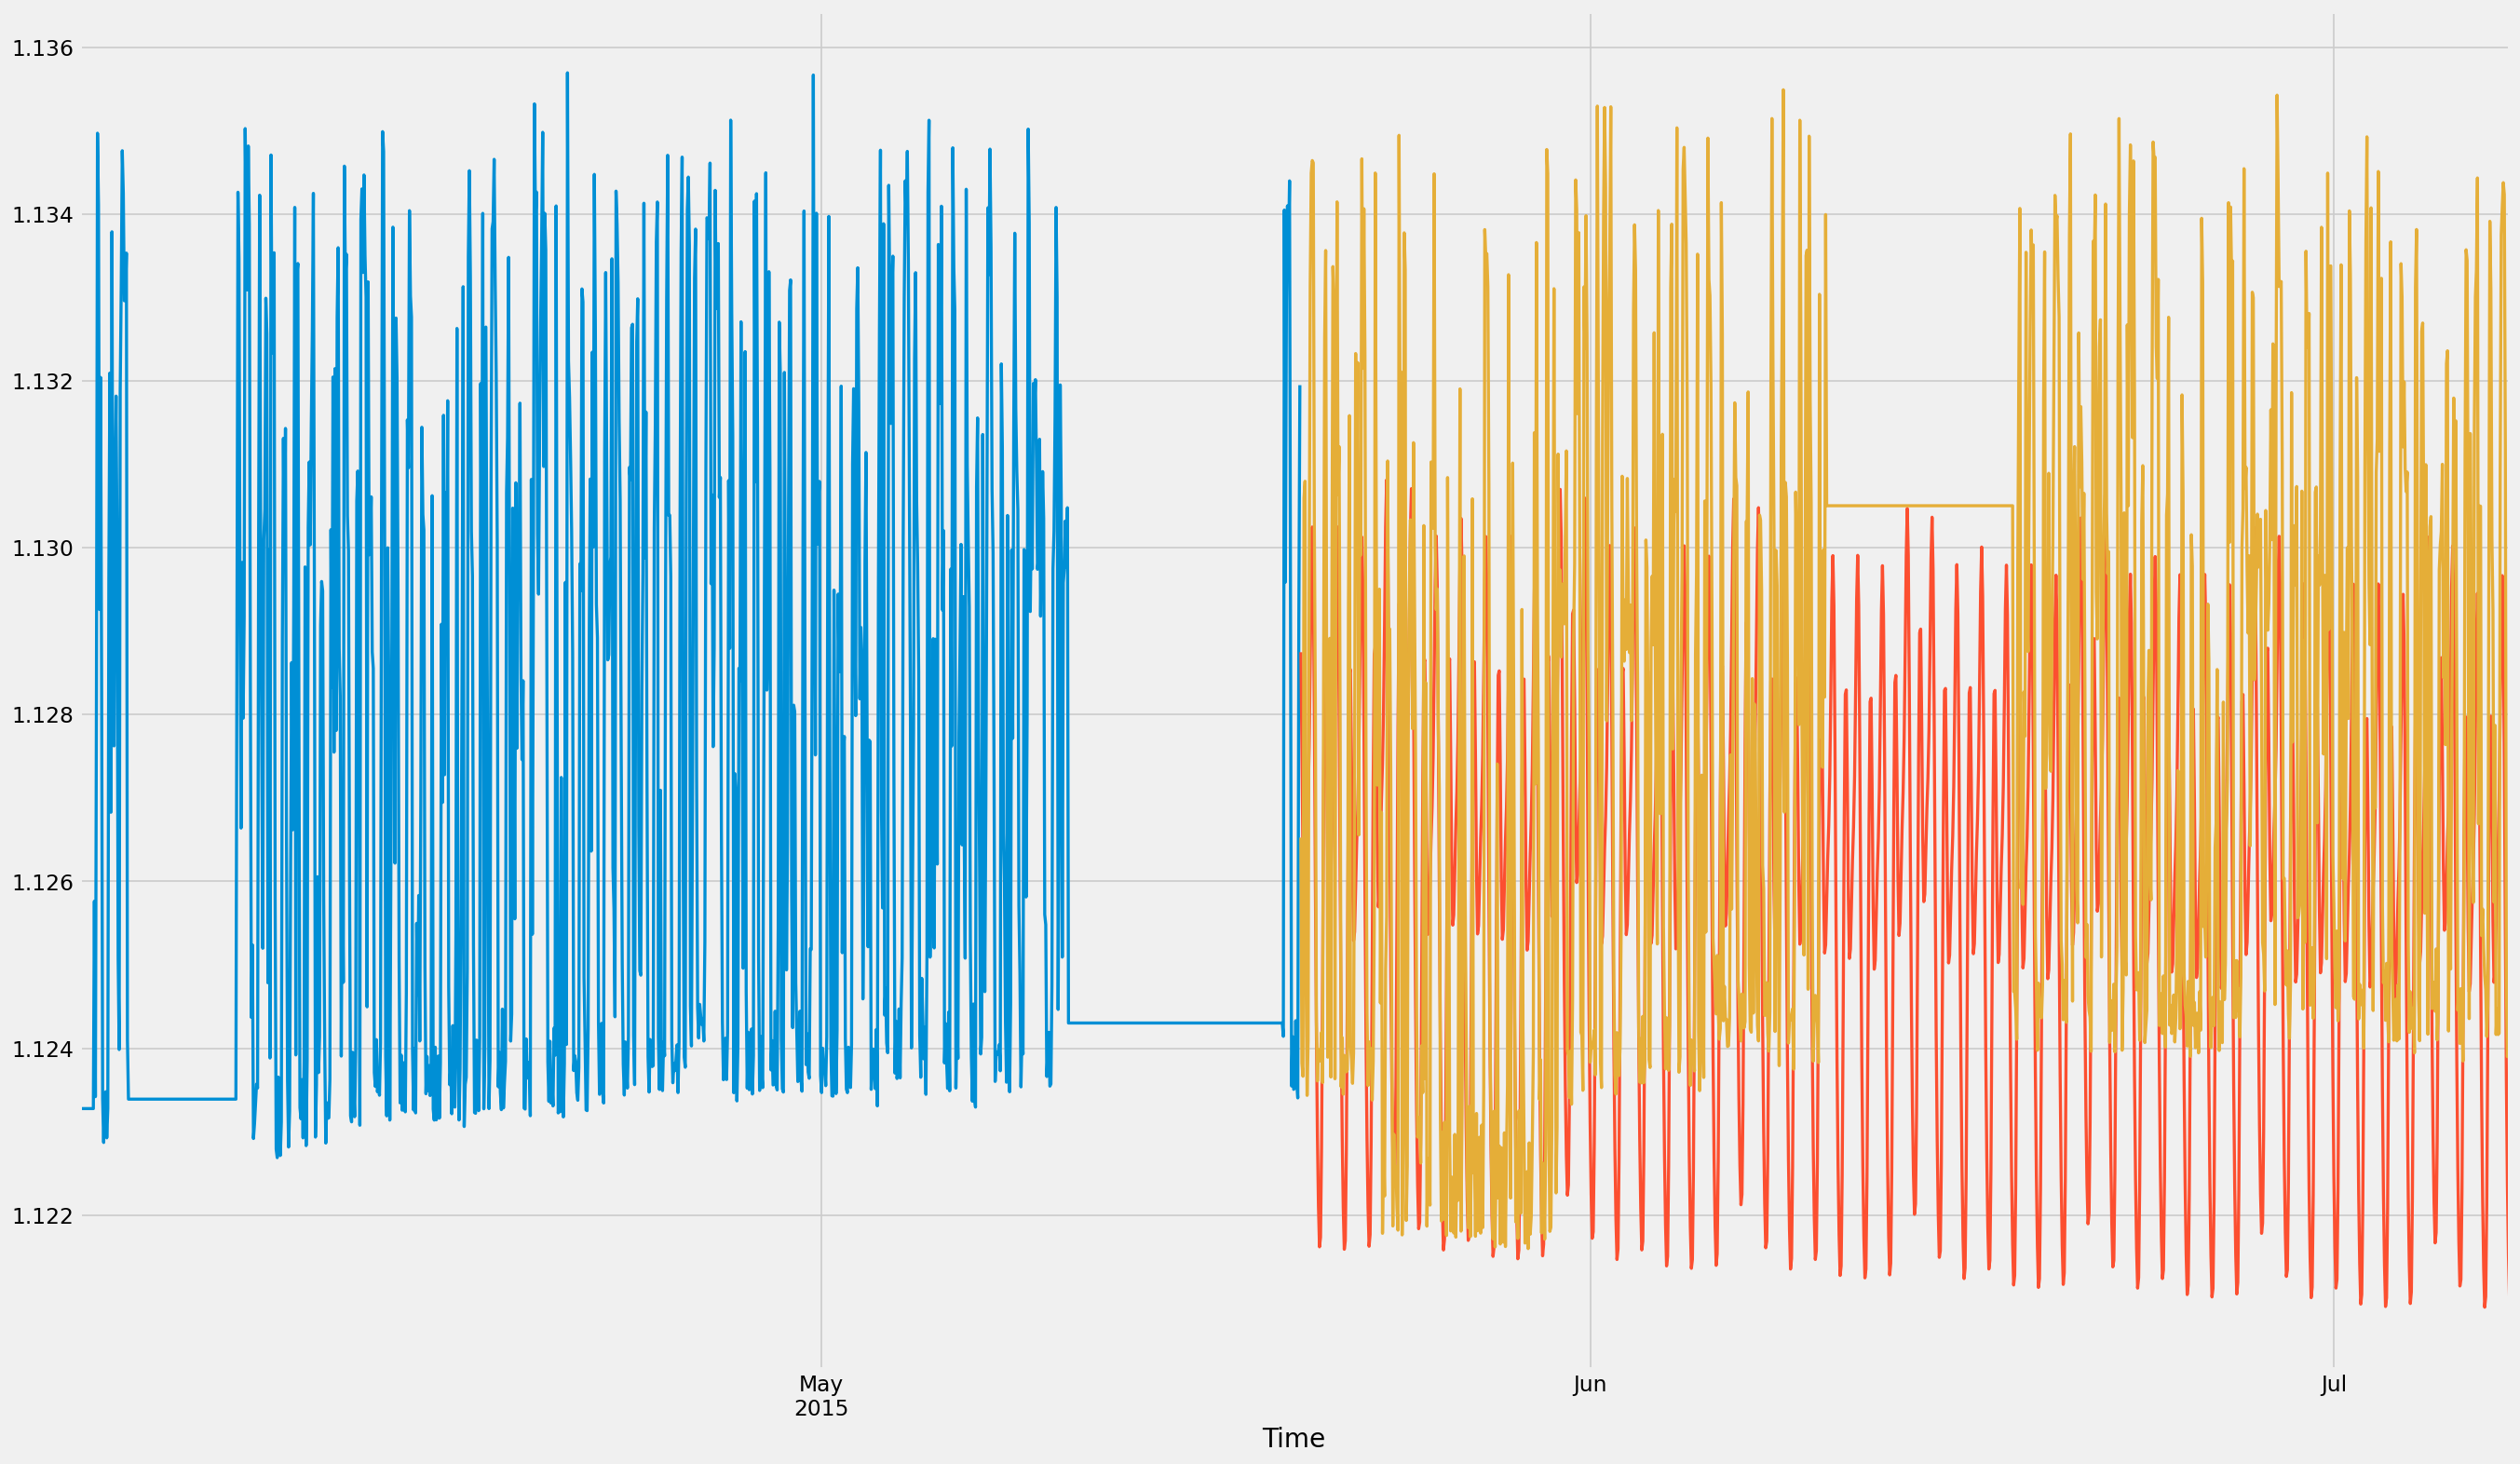

In [223]:
X_train['y'].loc[X_train.index>"2015-04-01"].plot(lw=2, figsize=(25,15))
prediction['yhat'].plot(lw=2, figsize=(25,15))
X_test['Agg_transformed'].plot(lw=2, figsize=(25,15))

<AxesSubplot:xlabel='Time'>

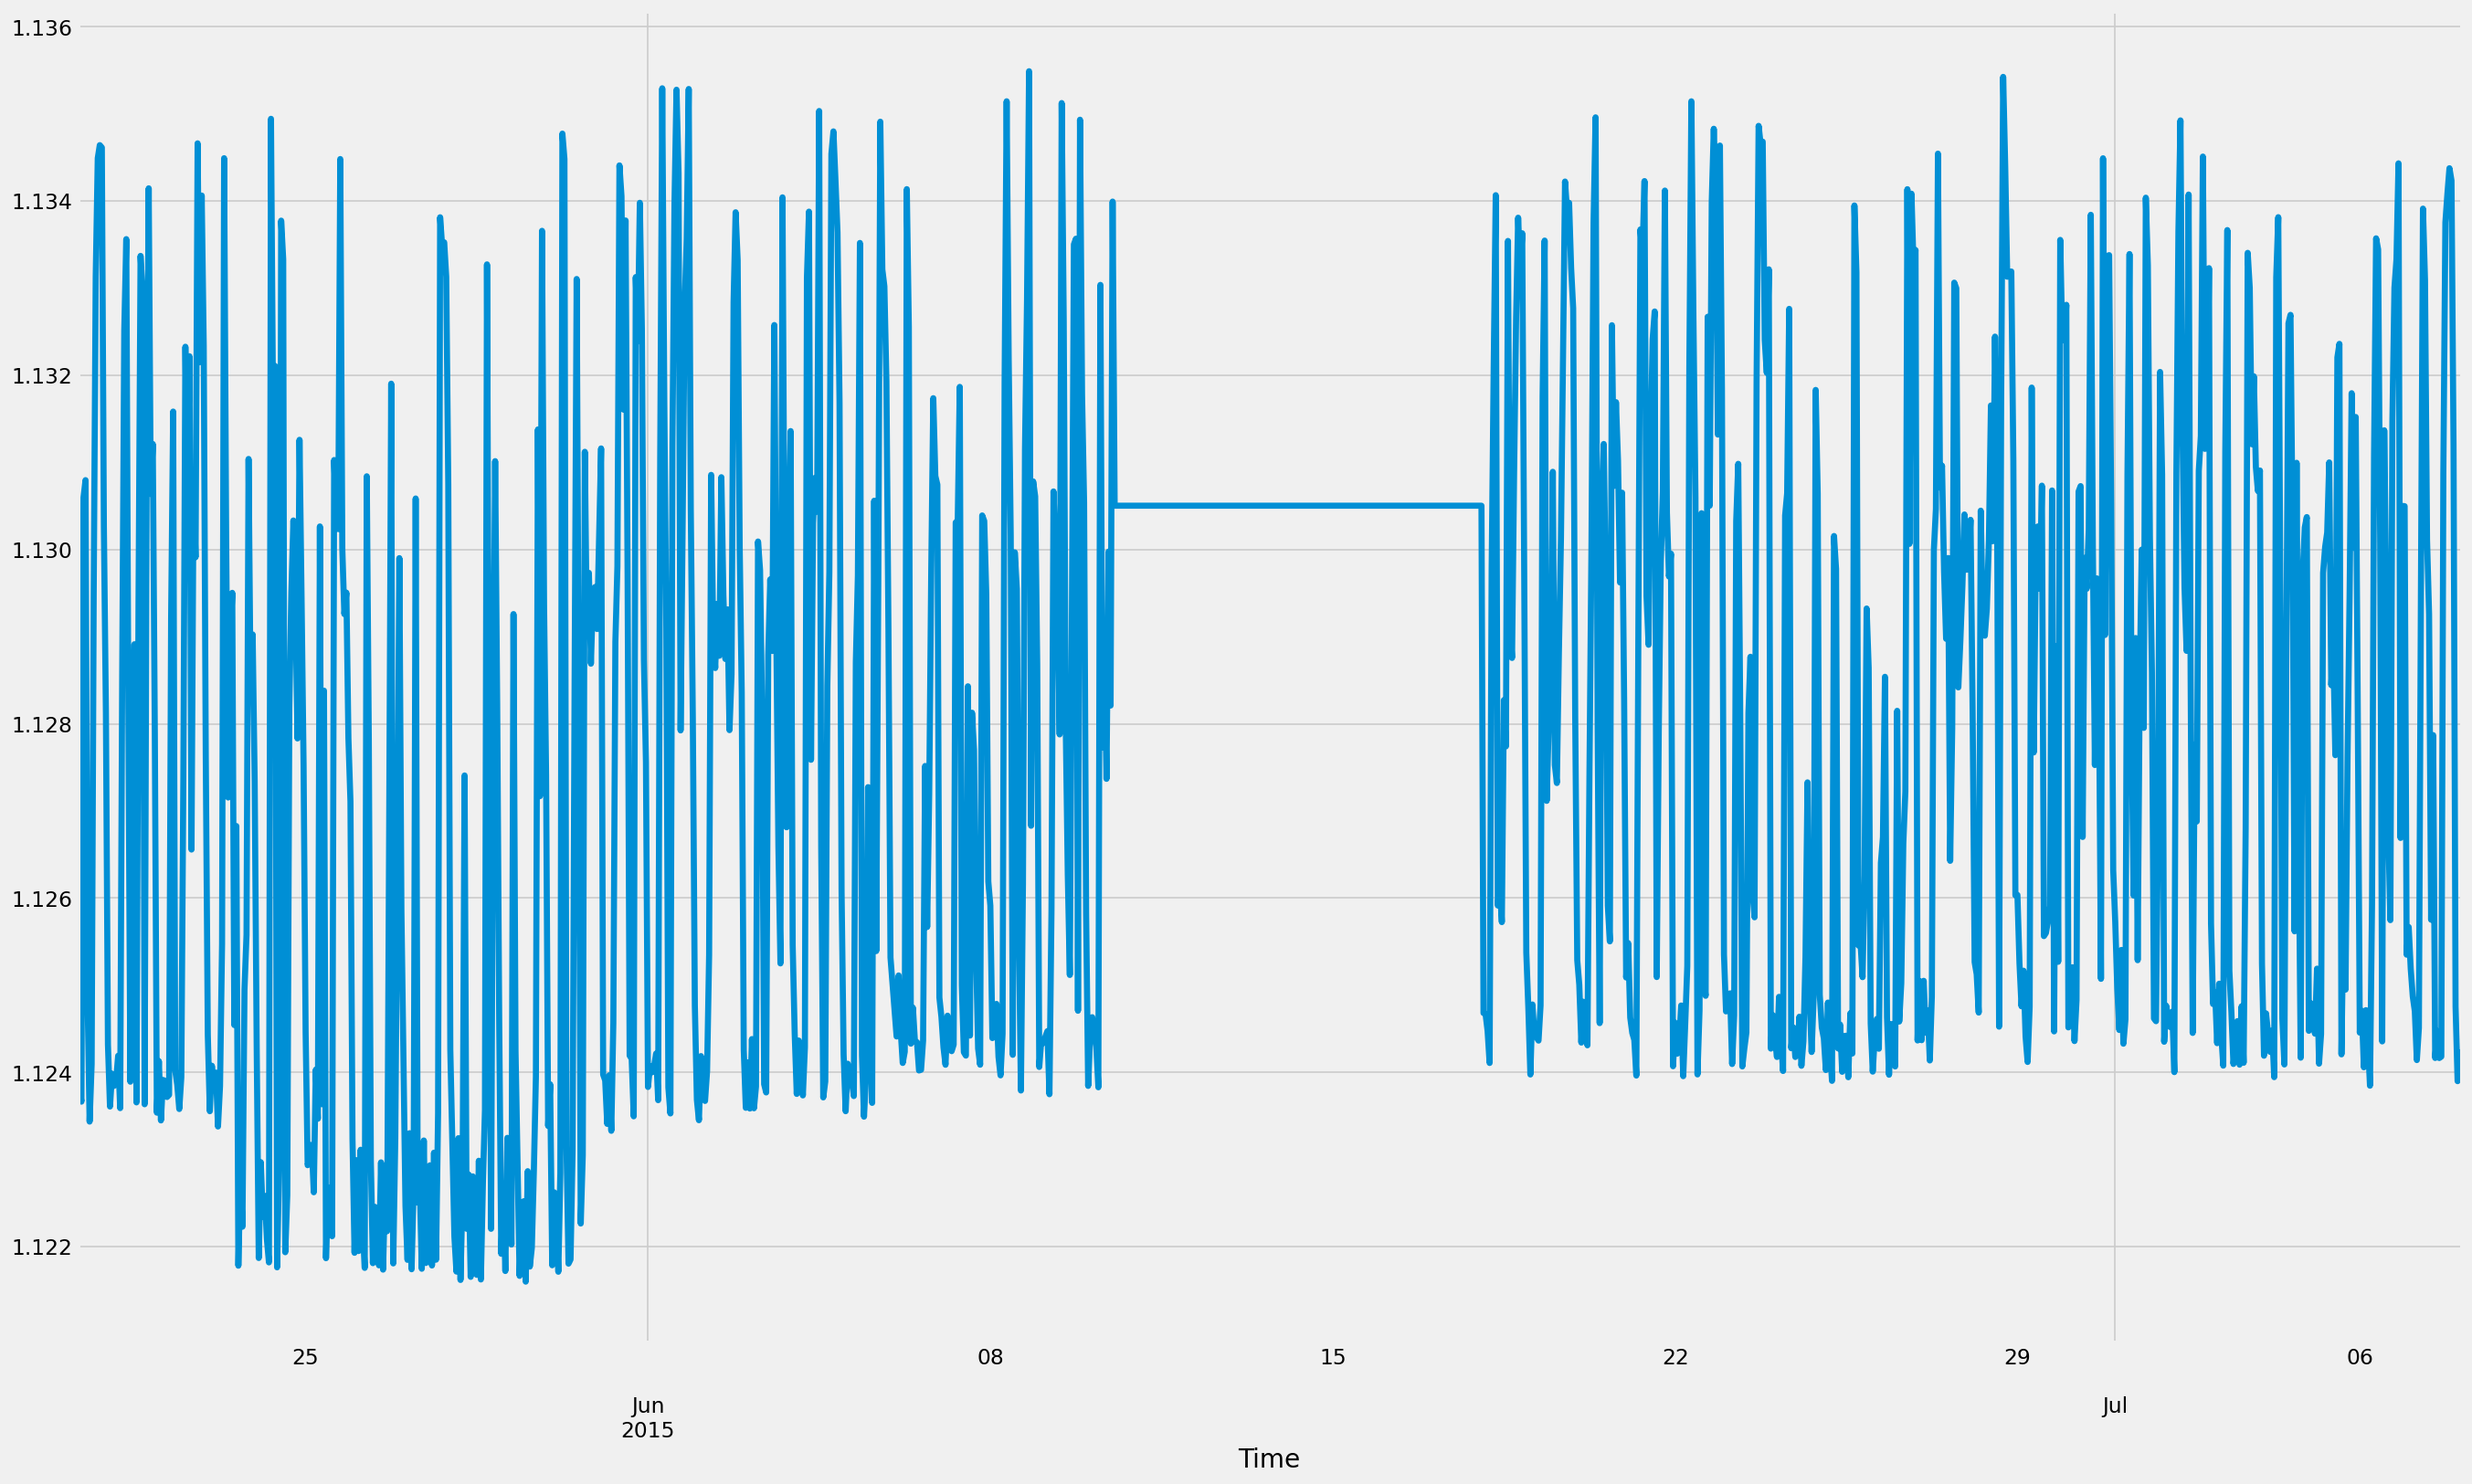

In [207]:
X_test['Agg_transformed'].plot(lw=4, figsize=(25,15))

In [229]:
#Cross validation
from prophet.diagnostics import cross_validation
from ipywidgets import IntProgress

In [231]:
df_cv = cross_validation(model, initial='30 days', horizon="1 day",disable_tqdm=True)


INFO:prophet:Making 816 forecasts with cutoffs between 2014-04-06 19:00:00 and 2015-05-19 07:00:00


Initial log joint probability = -2.02882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3944.33   6.20058e-05        462.79           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3944.63   0.000385884       310.767           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       3944.65   6.43924e-06       136.075   7.407e-08       0.001      323  LS failed, Hessian reset 
     299       3944.69   0.000111275       270.241           1           1      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3944.75   3.22392e-06       193.446      0.2054      0.2054      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     447       3944.76    8.9815e-08    

In [235]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [236]:
df_p

horizon       mse      rmse       mae      mape     mdape  \
0  0 days 03:00:00  0.000014  0.003757  0.003199  0.002835  0.002802   
1  0 days 04:00:00  0.000013  0.003626  0.003080  0.002731  0.002563   
2  0 days 05:00:00  0.000011  0.003305  0.002654  0.002354  0.002070   
3  0 days 06:00:00  0.000009  0.003035  0.002282  0.002024  0.001531   
4  0 days 07:00:00  0.000009  0.002938  0.002179  0.001934  0.001308   
5  0 days 08:00:00  0.000009  0.002917  0.002154  0.001912  0.001239   
6  0 days 09:00:00  0.000009  0.002986  0.002247  0.001994  0.001404   
7  0 days 10:00:00  0.000011  0.003300  0.002678  0.002375  0.002076   
8  0 days 11:00:00  0.000013  0.003615  0.003001  0.002661  0.002466   
9  0 days 12:00:00  0.000014  0.003702  0.002990  0.002650  0.002328   
10 0 days 13:00:00  0.000014  0.003693  0.002935  0.002600  0.002186   
11 0 days 14:00:00  0.000014  0.003753  0.003067  0.002717  0.002468   
12 0 days 15:00:00  0.000014  0.003796  0.003230  0.002862  0.002819   
13 0 days 16:00:00  0.000013  0.003659  0.003107  0.002755  0.002599   
14 0 days 17:00:00  0.000011  0.003335  0.002675  0.002373  0.002104   
15 0 days 18:00:00  0.000009  0.003059  0.002297  0.002038  0.001512   
16 0 days 19:00:00  0.000009  0.002958  0.002191  0.001945  0.001304   
17 0 days 20:00:00  0.000009  0.002940  0.002169  0.001925  0.001282   
18 0 days 21:00:00  0.000009  0.003013  0.002263  0.002007  0.001401   
19 0 days 22:00:00  0.000011  0.003327  0.002698  0.002393  0.002037   
20 0 days 23:00:00  0.000013  0.003643  0.003023  0.002680  0.002475   
21 1 days 00:00:00  0.000014  0.003735  0.003012  0.002669  0.002344   

       smape  coverage  
0   0.002835  0.948434  
1   0.002732  0.943930  
2   0.002355  0.945158  
3   0.002025  0.956398  
4   0.001934  0.972940  
5   0.001912  0.977433  
6   0.001994  0.972219  
7   0.002375  0.960782  
8   0.002660  0.935553  
9   0.002648  0.913697  
10  0.002599  0.908599  
11  0.002716  0.931480  
12  0.002863  0.946187  
13  0.002756  0.943930  
14  0.002374  0.944853  
15  0.002039  0.954661  
16  0.001945  0.969264  
17  0.001925  0.974471  
18  0.002007  0.968339  
19  0.002393  0.956492  
20  0.002679  0.932490  
21  0.002668  0.905935

## XGBoost

In [12]:
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

import re
from colorama import Fore, Back, Style
import plotly.express as px
from matplotlib.patches import Patch

plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
import warnings
warnings.filterwarnings('ignore')

In [13]:
df=dataframes_list[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11705 entries, 2014-03-07 10:00:00 to 2015-07-08 02:00:00
Freq: H
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Aggregate   11705 non-null  float64       
 1   Appliance1  11705 non-null  float64       
 2   Appliance2  11705 non-null  float64       
 3   Appliance3  11705 non-null  float64       
 4   Appliance4  11705 non-null  float64       
 5   Appliance5  11705 non-null  float64       
 6   Appliance6  11705 non-null  float64       
 7   Appliance7  11705 non-null  float64       
 8   Appliance8  11705 non-null  float64       
 9   Appliance9  11705 non-null  float64       
 10  date        11705 non-null  datetime64[ns]
 11  hour        11705 non-null  int64         
 12  dayofweek   11705 non-null  int64         
 13  quarter     11705 non-null  int64         
 14  month       11705 non-null  int64         
 15  year        11705 non-null 

In [56]:
df

Aggregate  Appliance1  Appliance2  Appliance3  \
Time                                                                  
2014-03-07 10:00:00  320.854839    0.000000    4.870968    1.000000   
2014-03-07 11:00:00  328.612457    0.001730    4.858131    1.152249   
2014-03-07 12:00:00  138.138840    0.000000    4.894552    1.001757   
2014-03-07 13:00:00  156.106061   86.231602    4.885281    1.000000   
2014-03-07 14:00:00  139.351852    9.205387    4.877104    1.001684   
...                         ...         ...         ...         ...   
2015-07-07 22:00:00  424.424361   89.447937    4.921415    0.000000   
2015-07-07 23:00:00  175.826772   40.911417    4.927165    0.000000   
2015-07-08 00:00:00  162.523529   59.480392    4.966667    0.000000   
2015-07-08 01:00:00  165.882122   70.781925    4.933202    0.000000   
2015-07-08 02:00:00  167.838710   96.440860    4.924731    0.000000   

                     Appliance4  Appliance5  Appliance6  Appliance7  \
Time                                                                  
2014-03-07 10:00:00    0.000000         0.0    0.000000         0.0   
2014-03-07 11:00:00    0.000000         0.0    0.000000         0.0   
2014-03-07 12:00:00    0.000000         0.0    0.000000         0.0   
2014-03-07 13:00:00    0.000000         0.0    0.000000         0.0   
2014-03-07 14:00:00    0.000000         0.0    0.000000         0.0   
...                         ...         ...         ...         ...   
2015-07-07 22:00:00  120.239686         0.0  108.554028         0.0   
2015-07-07 23:00:00    0.000000         0.0   19.889764         0.0   
2015-07-08 00:00:00    0.000000         0.0    0.000000         0.0   
2015-07-08 01:00:00    0.000000         0.0    0.000000         0.0   
2015-07-08 02:00:00    0.000000         0.0    0.000000         0.0   

                     Appliance8  Appliance9  ... dayofweek  quarter  month  \
Time                                         ...                             
2014-03-07 10:00:00         0.0         0.0  ...         4        1      3   
2014-03-07 11:00:00         0.0         0.0  ...         4        1      3   
2014-03-07 12:00:00         0.0         0.0  ...         4        1      3   
2014-03-07 13:00:00         0.0         0.0  ...         4        1      3   
2014-03-07 14:00:00         0.0         0.0  ...         4        1      3   
...                         ...         ...  ...       ...      ...    ...   
2015-07-07 22:00:00         0.0         0.0  ...         1        3      7   
2015-07-07 23:00:00         0.0         0.0  ...         1        3      7   
2015-07-08 00:00:00         0.0         0.0  ...         2        3      7   
2015-07-08 01:00:00         0.0         0.0  ...         2        3      7   
2015-07-08 02:00:00         0.0         0.0  ...         2        3      7   

                     year  dayofyear  dayofmonth  night     lag_hour  \
Time                                                                   
2014-03-07 10:00:00  2014         66           7      0          NaN   
2014-03-07 11:00:00  2014         66           7      0   320.854839   
2014-03-07 12:00:00  2014         66           7      0   328.612457   
2014-03-07 13:00:00  2014         66           7      0   138.138840   
2014-03-07 14:00:00  2014         66           7      0   156.106061   
...                   ...        ...         ...    ...          ...   
2015-07-07 22:00:00  2015        188           7      1  1050.237052   
2015-07-07 23:00:00  2015        188           7      1   424.424361   
2015-07-08 00:00:00  2015        189           8      1   175.826772   
2015-07-08 01:00:00  2015        189           8      1   162.523529   
2015-07-08 02:00:00  2015        189           8      1   165.882122   

                        lag_day    lag_week  
Time                                         
2014-03-07 10:00:00         NaN         NaN  
2014-03-07 11:00:00         NaN         NaN  
2014-03-07 12:00:00         NaN       

In [15]:
X= df.drop(['date','Aggregate'],axis=1)

y= df['Aggregate'].values

In [17]:
X= X.values

(11705, 20)

In [20]:
X_train, X_test = train_test_split(X,train_size=0.8, shuffle=False)
y_train, y_test = train_test_split(y, train_size=0.8, shuffle=False)

NameError: name 'train_test_split' is not defined

In [93]:
y_train = y_train.reshape(-1,1)

In [95]:
#scaling the data after partition

scaler = MinMaxScaler(feature_range=(0,1))

X_train[nums.columns] = scaler.fit_transform(X_train[nums.columns])

y_train = scaler.fit_transform(y_train)



In [96]:
y_train.shape

(9364, 1)

In [97]:
reg = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}


In [98]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [99]:
from xgboost import plot_importance, plot_tree

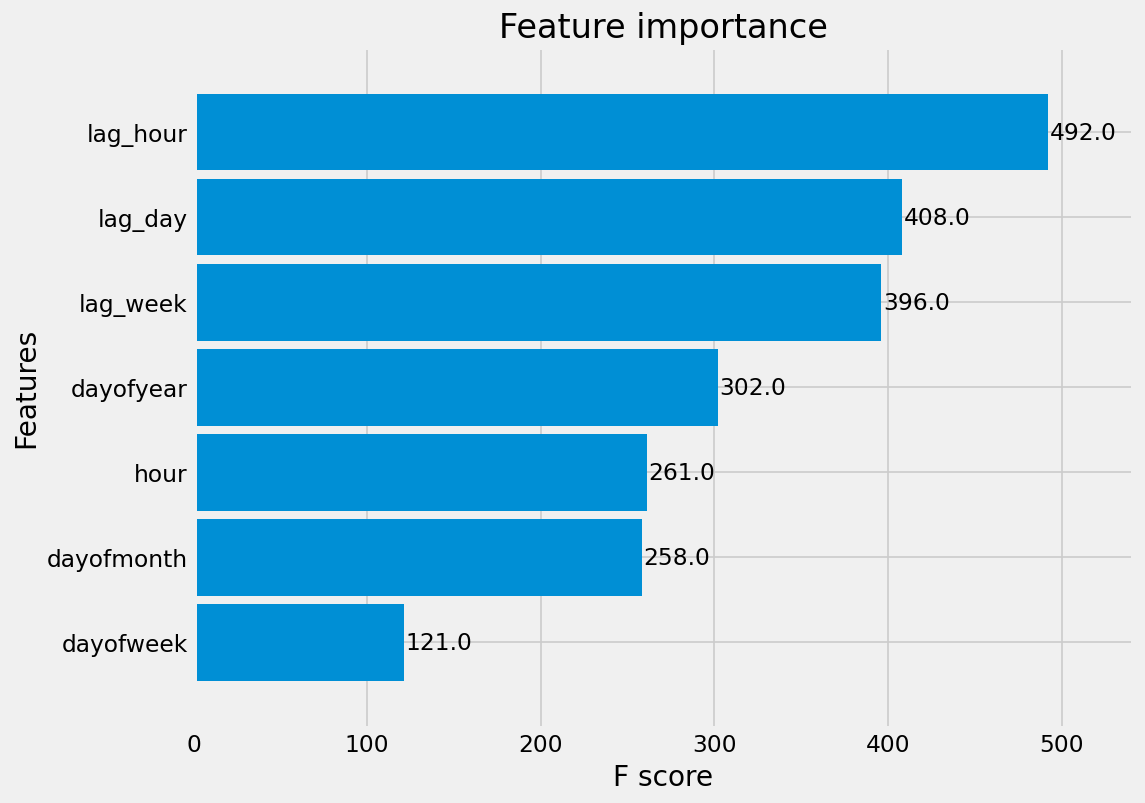

In [100]:
_ = plot_importance(reg, height=0.9)

In [110]:
X_test[nums.columns] = scaler.transform(X_test[nums.columns])

ValueError: X has 3 features, but MinMaxScaler is expecting 1 features as input.

In [101]:
X_test['Prediction'] = reg.predict(X_test)

In [106]:
y_test= y_test.reshape(-1,1)
y_test = scaler.transform(y_test)

In [107]:
X_test['actual'] = y_test

In [108]:
X_test

dayofmonth  dayofyear  month  quarter  dayofweek  hour  \
Time                                                                          
2015-04-01 14:00:00           1         91      4        2          2    14   
2015-04-01 15:00:00           1         91      4        2          2    15   
2015-04-01 16:00:00           1         91      4        2          2    16   
2015-04-01 17:00:00           1         91      4        2          2    17   
2015-04-01 18:00:00           1         91      4        2          2    18   
...                         ...        ...    ...      ...        ...   ...   
2015-07-07 22:00:00           7        188      7        3          1    22   
2015-07-07 23:00:00           7        188      7        3          1    23   
2015-07-08 00:00:00           8        189      7        3          2     0   
2015-07-08 01:00:00           8        189      7        3          2     1   
2015-07-08 02:00:00           8        189      7        3          2     2   

                        lag_hour     lag_day    lag_week  Prediction  \
Time                                                                   
2015-04-01 14:00:00   153.953125  153.953125  183.304950    0.413364   
2015-04-01 15:00:00   153.953125  153.953125  156.031621    0.413364   
2015-04-01 16:00:00   153.953125  153.953125  320.498039    0.413364   
2015-04-01 17:00:00   194.458599  153.953125  384.061144    0.413364   
2015-04-01 18:00:00   155.847222  153.953125  226.865347    0.413364   
...                          ...         ...         ...         ...   
2015-07-07 22:00:00  1050.237052  370.565815  372.911243    0.504051   
2015-07-07 23:00:00   424.424361  186.427451  206.452055    0.504051   
2015-07-08 00:00:00   175.826772  192.558000  193.706349    0.413364   
2015-07-08 01:00:00   162.523529  183.421782  179.343874    0.413364   
2015-07-08 02:00:00   165.882122  177.832117  171.465753    0.413364   

                         actual  
Time                             
2015-04-01 14:00:00  153.953125  
2015-04-01 15:00:00  153.953125  
2015-04-01 16:00:00  194.458599  
2015-04-01 17:00:00  155.847222  
2015-04-01 18:00:00  263.071918  
...                         ...  
2015-07-07 22:00:00  424.424361  
2015-07-07 23:00:00  175.826772  
2015-07-08 00:00:00  162.523529  
2015-07-08 01:00:00  165.882122  
2015-07-08 02:00:00  167.838710  

[2341 rows x 11 columns]

<AxesSubplot:xlabel='Time'>

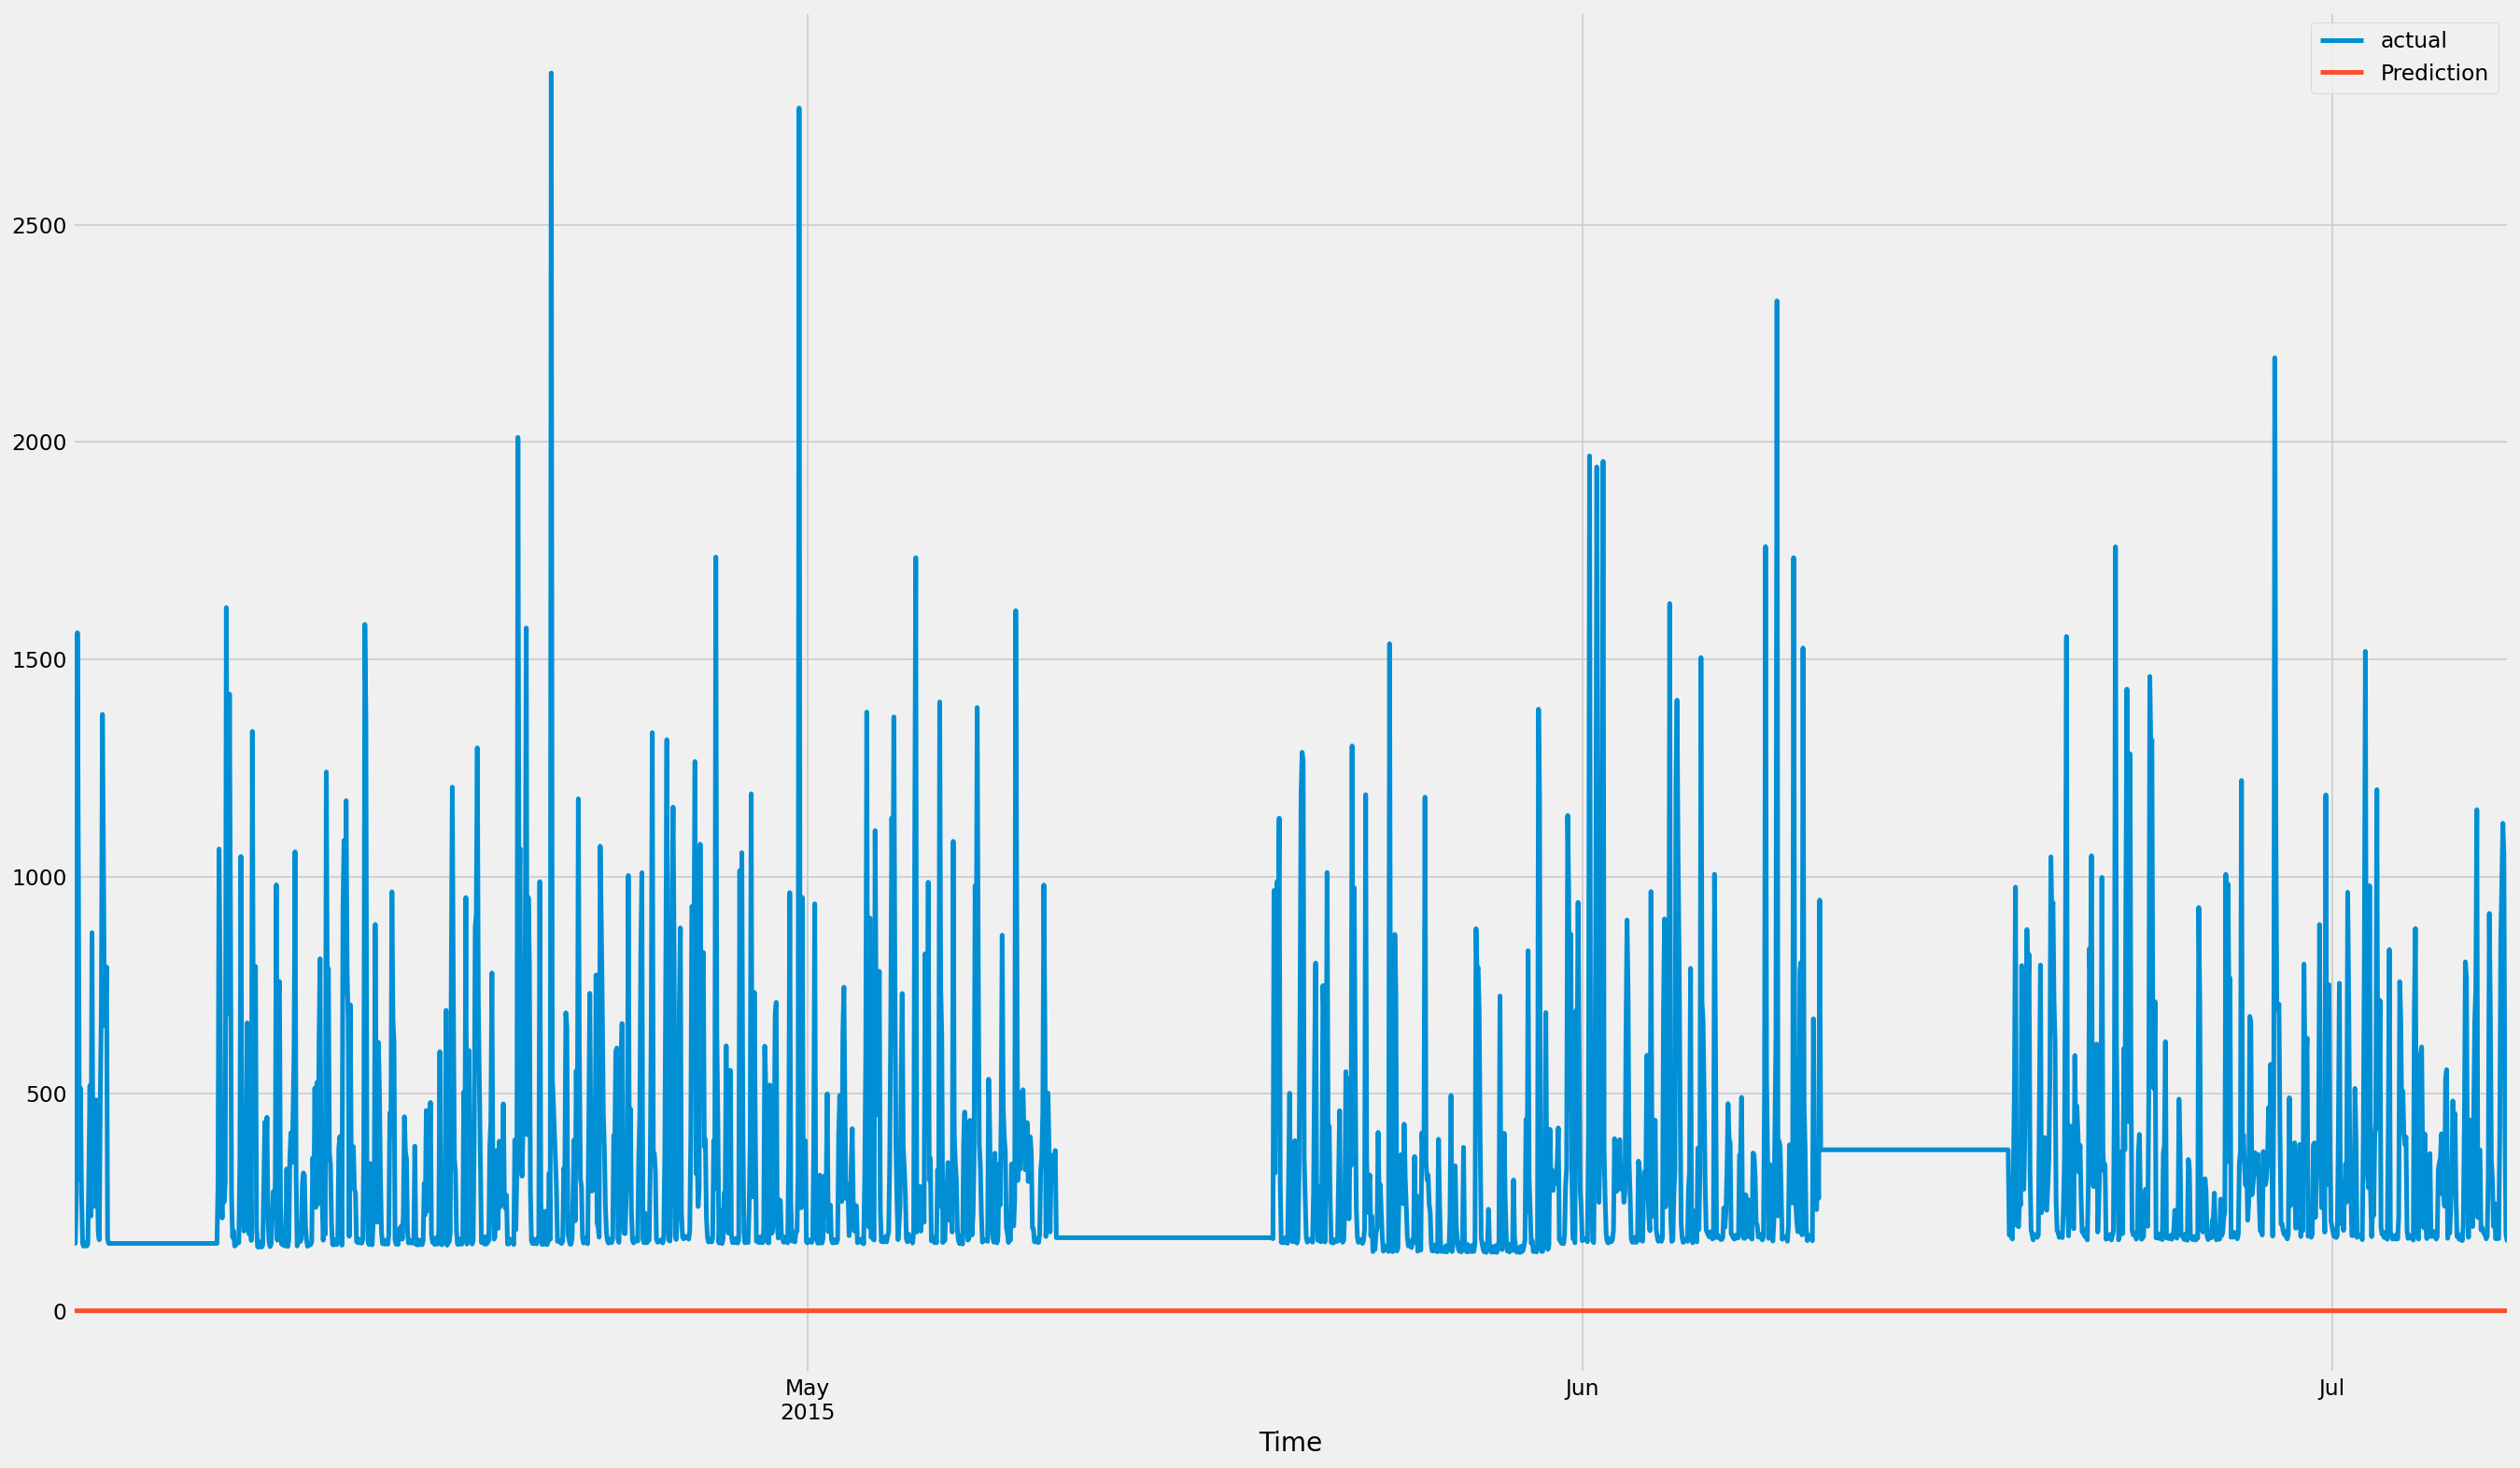

In [109]:
X_test[['actual','Prediction']].plot(lw=3, figsize=(25,15))
#X_test[['actual','Prediction']].loc[(X_test.index>'2015-07-01')&(X_test.index<="2015-08-01")].plot(lw=1)

In [310]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(X_test['actual'], X_test['Prediction'])


6.801784154011548e-06

In [311]:


mean_absolute_error(X_test['actual'], X_test['Prediction'])

0.0019872941795379406

In [313]:
X_test['error']= X_test['actual']-X_test['Prediction']
X_test['abs_error'] = X_test['error'].apply(np.abs)

In [316]:
error_by_day = X_test.groupby(['month','dayofmonth']) \
    .mean()[['actual','Prediction','error','abs_error']]

In [324]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(25)

actual  Prediction     error  abs_error
month dayofmonth                                           
4     3           1.123419    1.125550 -0.002131   0.002197
5     16          1.124302    1.125914 -0.001612   0.002009
4     4           1.123390    1.124946 -0.001557   0.001618
5     11          1.124302    1.125817 -0.001515   0.001953
      17          1.124302    1.125696 -0.001394   0.001849
4     5           1.123390    1.124775 -0.001385   0.001466
      6           1.123390    1.124739 -0.001350   0.001412
5     12          1.124302    1.125566 -0.001264   0.001786
      13          1.124302    1.125557 -0.001255   0.001714
      14          1.124302    1.125509 -0.001206   0.001653
      26          1.124144    1.125337 -0.001192   0.002456
      15          1.124302    1.125384 -0.001082   0.001558
6     24          1.126022    1.127067 -0.001046   0.001844
5     28          1.124179    1.125049 -0.000870   0.001992
      29          1.124375    1.125185 -0.000809   0.001893
4     15          1.125689    1.126465 -0.000775   0.002056
6     7           1.126475    1.127215 -0.000739   0.002167
5     18          1.124302    1.124860 -0.000558   0.001184
6     25          1.126156    1.126654 -0.000498   0.001967
5     27          1.125122    1.125501 -0.000379   0.001959
6     6           1.126553    1.126887 -0.000334   0.001887
5     23          1.126140    1.126388 -0.000248   0.002315
6     26          1.126915    1.127134 -0.000219   0.001965
5     1           1.126368    1.126506 -0.000138   0.001633
4     24          1.127247    1.127379 -0.000132   0.001859

In [325]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

actual  Prediction     error  abs_error
month dayofmonth                                           
4     2           1.128882    1.126884  0.001999   0.002904
5     31          1.128620    1.127832  0.000789   0.002817
      24          1.126935    1.126506  0.000429   0.002815
4     1           1.128288    1.126957  0.001331   0.002803
      8           1.128244    1.126914  0.001330   0.002769
      25          1.127998    1.127538  0.000460   0.002621
5     30          1.126519    1.126107  0.000412   0.002565
4     10          1.126975    1.126479  0.000496   0.002509
6     29          1.127707    1.127399  0.000308   0.002504
5     3           1.127622    1.127571  0.000051   0.002485